In [1]:
from minority_report.clean_data import CleanData
from minority_report.scaling import Scaling

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
from skimage import io, color
from scipy.ndimage import gaussian_filter

# Load data

In [2]:
df = Scaling()
df.load_data()

,precinct_number,offense_type,crime_completed,offense_level,premise_desc,premise,jurisdiction,park_name,suspect_age,suspect_race,suspect_sex,latitude,longitude,metro,victim_age,victim_race,victim_sex,period,borough,patrol_borough
0,73,OFFENSES AGAINST PUBLIC ADMINI,COMPLETED,MISDEMEANOR,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,NOT PARK,25-44,BLACK,M,40.664239,-73.908425,NOT SUBWAY,<18,BLACK,M,2015-02-11 15:00:00,BROOKLYN,PATROL BORO BKLYN NORTH
1,69,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,INSIDE,RESIDENCE-HOUSE,N.Y. POLICE DEPT,NOT PARK,UNKNOWN,UNKNOWN,UNKNOWN,40.644590,-73.892672,NOT SUBWAY,45-64,BLACK,F,2012-03-17 10:00:00,BROOKLYN,PATROL BORO BKLYN SOUTH
2,71,HARRASSMENT 2,COMPLETED,VIOLATION,INSIDE,PUBLIC SCHOOL,N.Y. POLICE DEPT,NOT PARK,<18,BLACK,M,40.658758,-73.942435,NOT SUBWAY,18-24,BLACK,M,2016-10-27 13:00:00,BROOKLYN,PATROL BORO BKLYN SOUTH
3,112,RAPE,COMPLETED,FELONY,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,NOT PARK,25-44,WHITE HISPANIC,M,40.722364,-73.851474,NOT SUBWAY,25-44,WHITE,F,2014-11-27 19:00:00,QUEENS,PATROL BORO QUEENS NORTH
4,24,GRAND LARCENY,COMPLETED,FELONY,INSIDE,DOCTOR/DENTIST OFFICE,N.Y. POLICE DEPT,NOT PARK,UNKNOWN,UNKNOWN,UNKNOWN,40.793465,-73.968950,NOT SUBWAY,45-64,WHITE,F,2013-12-11 13:00:00,MANHATTAN,PATROL BORO MAN NORTH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983202,109,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,NOT PARK,25-44,WHITE HISPANIC,M,40.785050,-73.856852,NOT SUBWAY,25-44,ASIAN / PACIFIC ISLANDER,F,2018-12-02 04:00:00,QUEENS,PATROL BORO QUEENS NORTH
6983203,25,OFF. AGNST PUB ORD SENSBLTY &,COMPLETED,MISDEMEANOR,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,NOT PARK,25-44,BLACK,F,40.801717,-73.937283,NOT SUBWAY,25-44,BLACK,M,2018-01-20 00:00:00,MANHATTAN,PATROL BORO MAN NORTH
6983204,41,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,FELONY,FRONT OF,STREET,N.Y. POLICE DEPT,NOT PARK,UNKNOWN,UNKNOWN,UNKNOWN,40.814612,-73.903637,NOT SUBWAY,25-44,BLACK HISPANIC,F,2018-08-03 22:00:00,BRONX,PATROL BORO BRONX
6983205,107,FRAUDS,COMPLETED,MISDEMEANOR,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,NOT PARK,UNKNOWN,UNKNOWN,U,40.724699,-73.808549,NOT SUBWAY,18-24,ASIAN / PACIFIC ISLANDER,M,2018-12-10 11:00:00,QUEENS,PATROL BORO QUEENS SOUTH


## filter with NYC boundaries

In [3]:
lat_interv = df.data['latitude'].between(40.49611539518921, 40.91553277600008)
lon_interv = df.data['longitude'].between(-74.25559136315213,-73.70000906387347)

In [4]:
sample = df.data[lat_interv & lon_interv][['period', 'latitude', 'longitude']]
sample

,period,latitude,longitude
0,2015-02-11 15:00:00,40.664239,-73.908425
1,2012-03-17 10:00:00,40.644590,-73.892672
2,2016-10-27 13:00:00,40.658758,-73.942435
3,2014-11-27 19:00:00,40.722364,-73.851474
4,2013-12-11 13:00:00,40.793465,-73.968950
...,...,...,...
6983202,2018-12-02 04:00:00,40.785050,-73.856852
6983203,2018-01-20 00:00:00,40.801717,-73.937283
6983204,2018-08-03 22:00:00,40.814612,-73.903637
6983205,2018-12-10 11:00:00,40.724699,-73.808549


# Group by hour

In [5]:
def group_by_hour_list(df, year, month, day):#, sampling=True):
    '''
    get a sample of a month-time crimes grouped by hour
    inputs = start_date info
    '''
    sample = df.data[['period', 'latitude', 'longitude']]
    
    #if sampling:
    inf = sample['period'] > datetime(year, month, day, 0, 0, 0)
    next_month = month+1
    next_year = year
    if month == 12:
        next_month = 1
        next_year = year+1
    #print(next_year, next_month)
    sup = sample['period'] < datetime(next_year, next_month, day, 0, 0, 0)
    sample = sample[ inf & sup ]
    
    liste = np.sort(np.array(sample['period'].unique()))
    length = len(liste)
    lat_per_image = [[coord[1] for coord in np.array(sample[sample['period']== timestamp][['latitude', 'longitude']])]\
             for index, timestamp in enumerate(liste)]
    lon_per_image = [[coord[0] for coord in np.array(sample[sample['period']== timestamp][['latitude', 'longitude']])]\
             for index, timestamp in enumerate(liste)]
    
    return lat_per_image, lon_per_image

In [7]:
def group_by_hour(df, year, month, day):#, sampling=True):
    '''
    get a sample of a month-time crimes grouped by hour
    inputs = start_date info
    '''
    sample = df.data[['period', 'latitude', 'longitude']]
    
    #if sampling:
    inf = sample['period'] > datetime(year, month, day, 0, 0, 0)
    next_month = month+1
    next_year = year
    if month == 12:
        next_month = 1
        next_year = year+1
    #print(next_year, next_month)
    sup = sample['period'] < datetime(next_year, next_month, day, 0, 0, 0)
    sample = sample[ inf & sup ]
    
    liste = np.sort(np.array(sample['period'].unique()))
    length = len(liste)
    lat_per_image = []
    lon_per_image = []
    for index, timestamp in enumerate(liste):
        if (index+1) % 100 ==0:
            print(f'Grouping timestamp {index+1}/{length}')
        by_hour = np.array(sample[sample['period']== timestamp][['latitude', 'longitude']])
        lat_per_image.append([coord[0] for coord in by_hour])
        lon_per_image.append([coord[1] for coord in by_hour])
    return lat_per_image, lon_per_image

In [8]:
lats, lons = group_by_hour(df, 2013, 8, 5)#, sampling=False)

Grouping timestamp 100/743
Grouping timestamp 200/743
Grouping timestamp 300/743
Grouping timestamp 400/743
Grouping timestamp 500/743
Grouping timestamp 600/743
Grouping timestamp 700/743


In [1]:
# lons

In [2]:
# lats

# save image and take as np.array

<ipython-input-11-0390994cd360>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


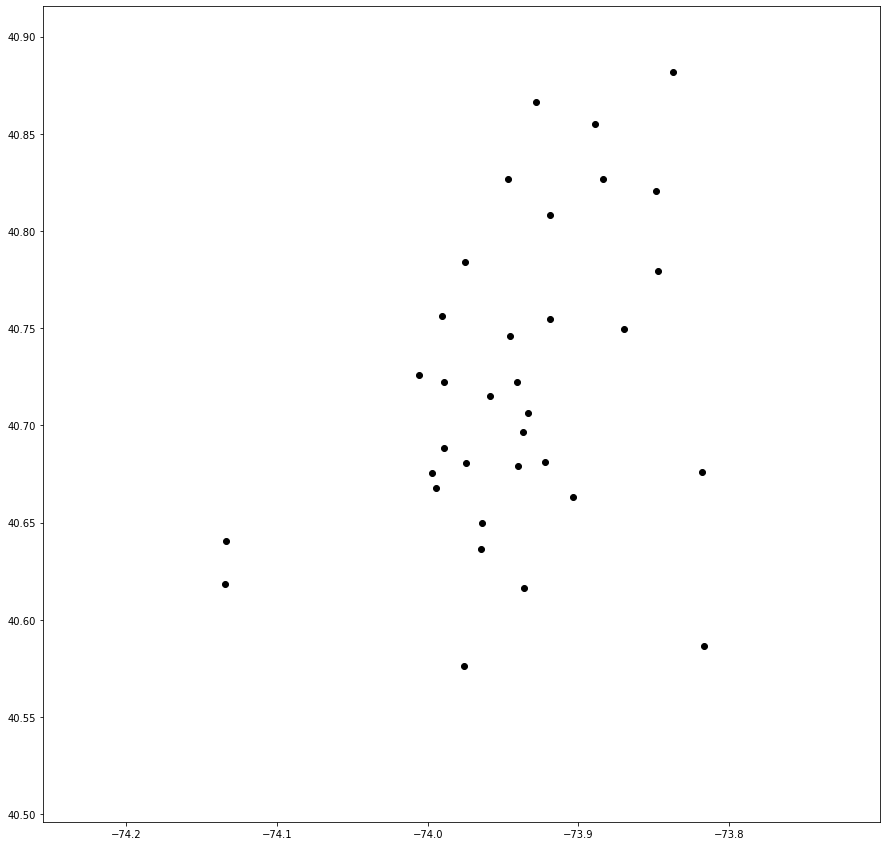

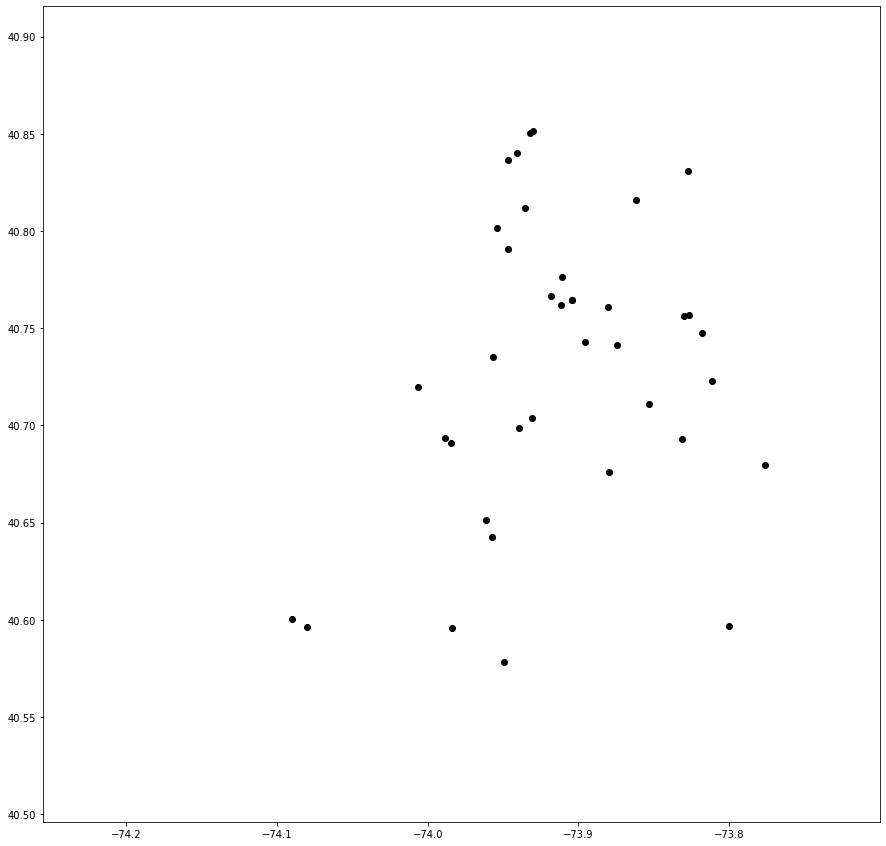

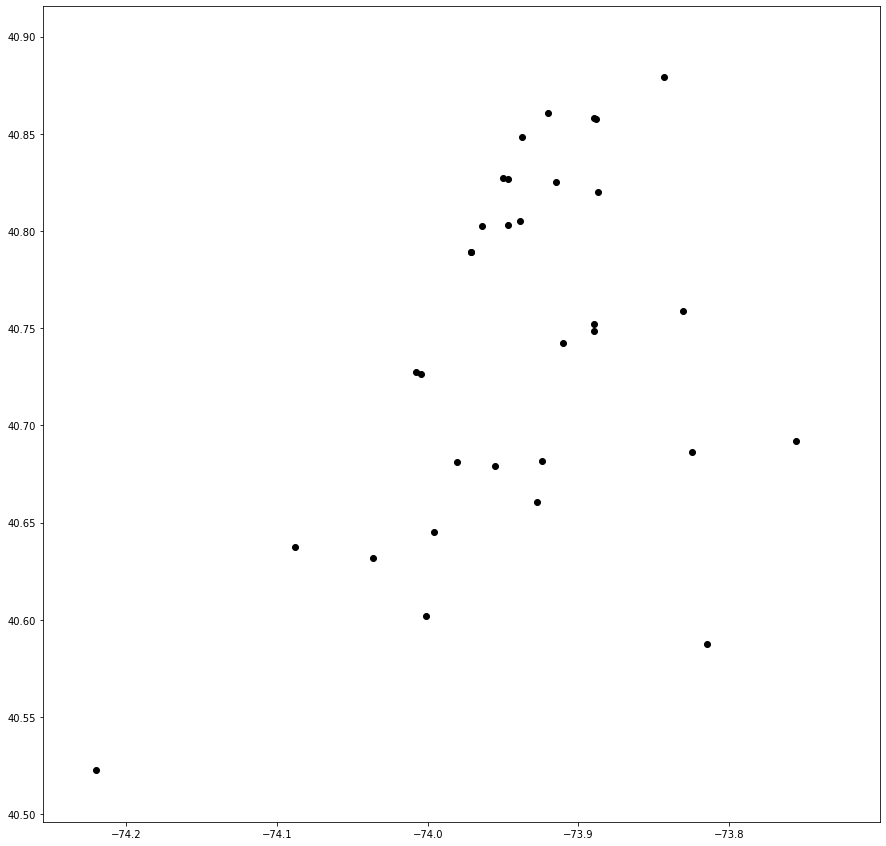

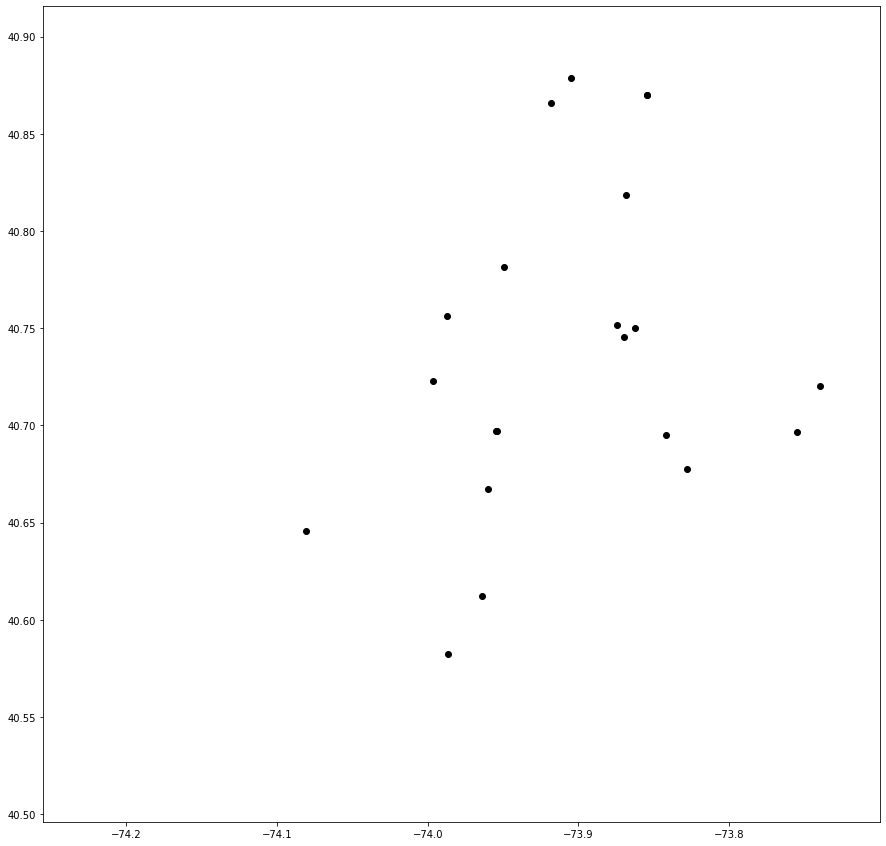

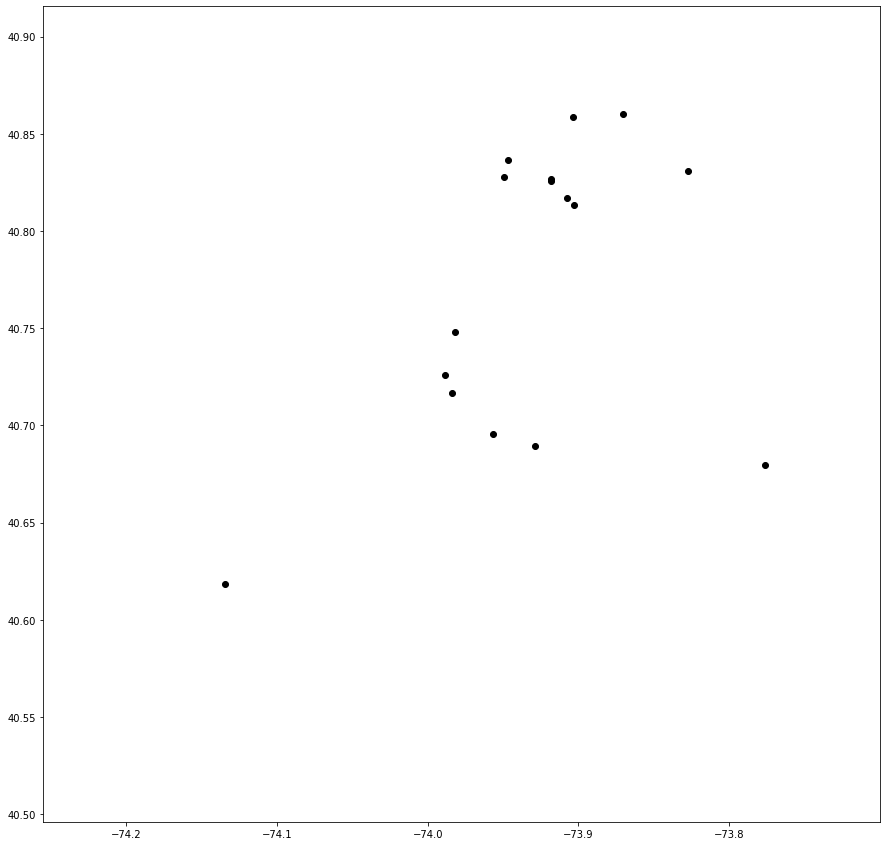

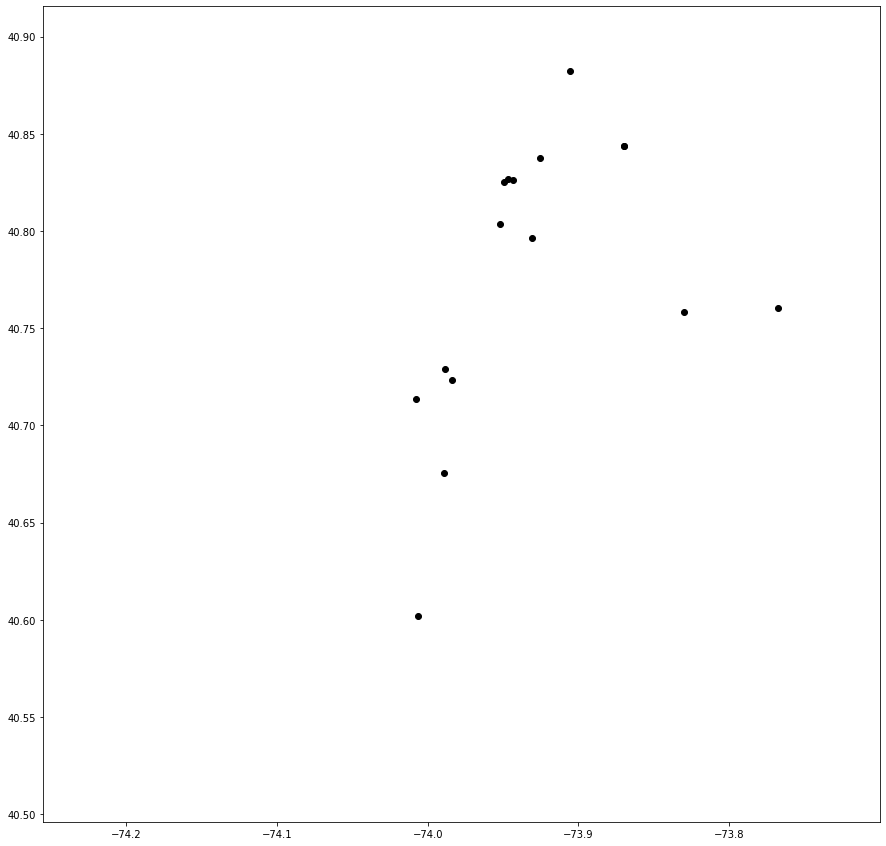

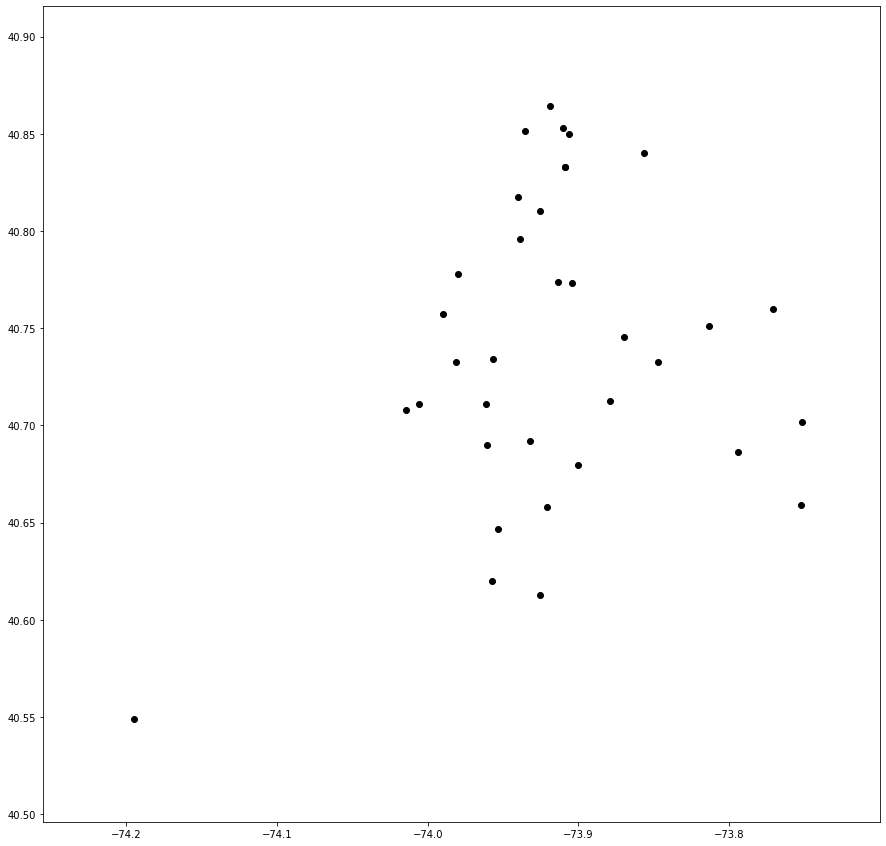

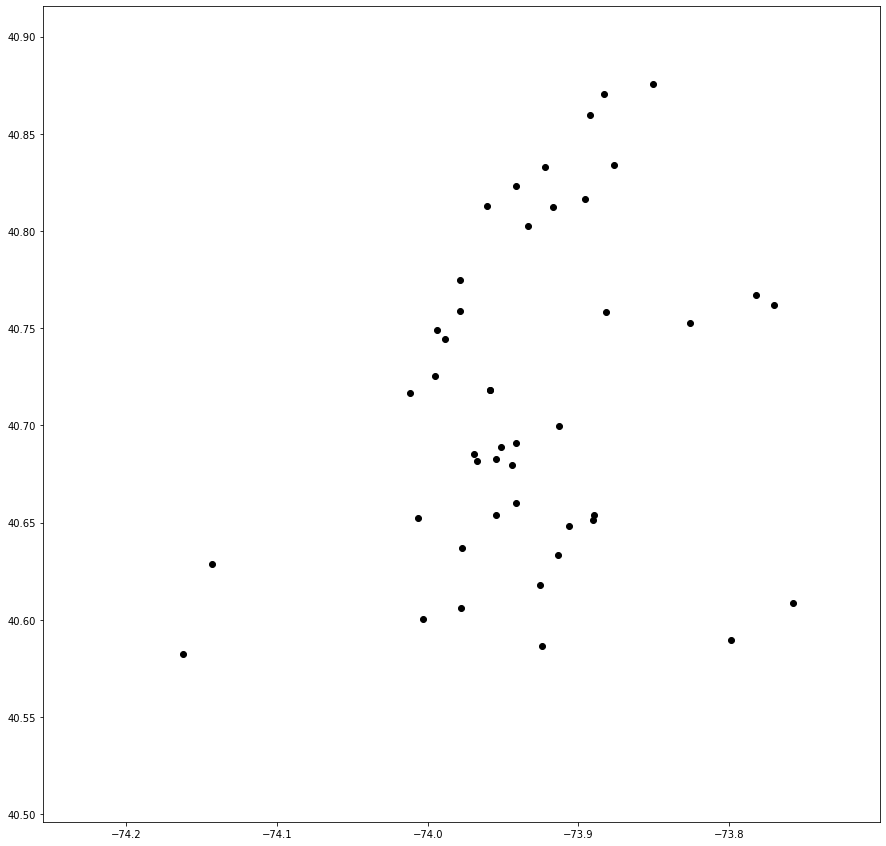

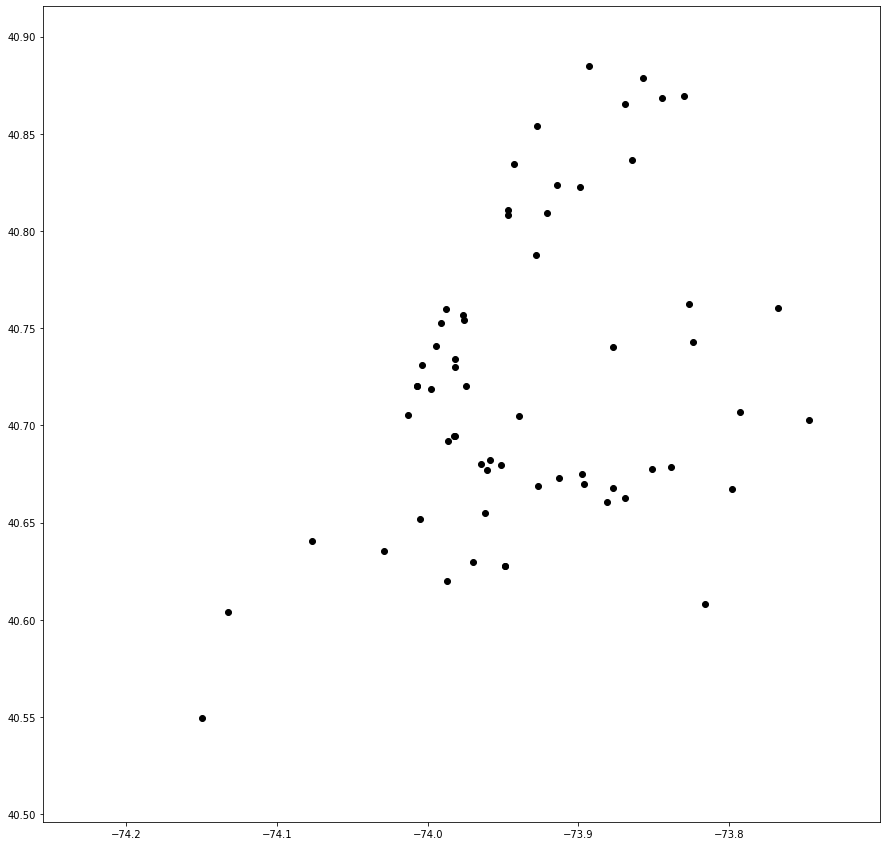

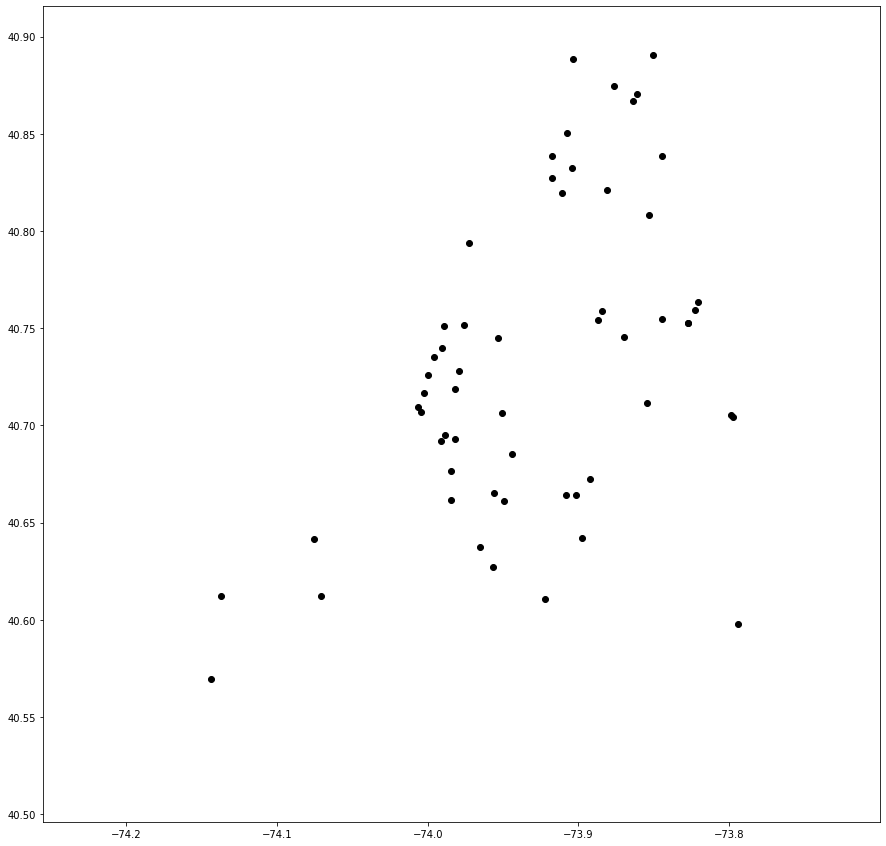

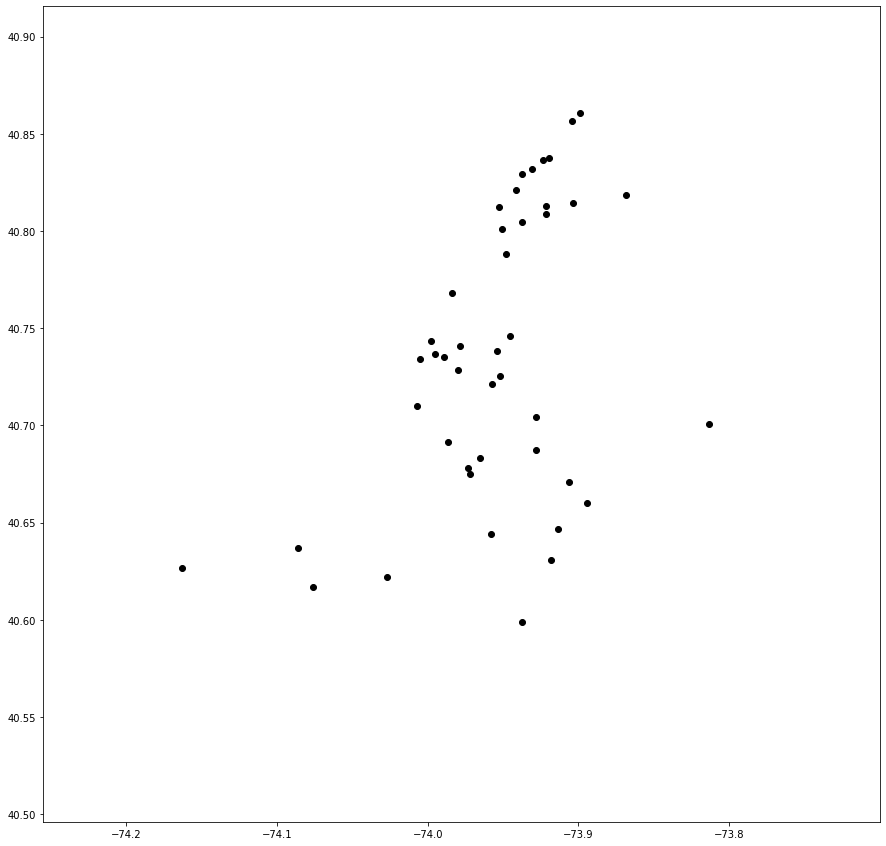

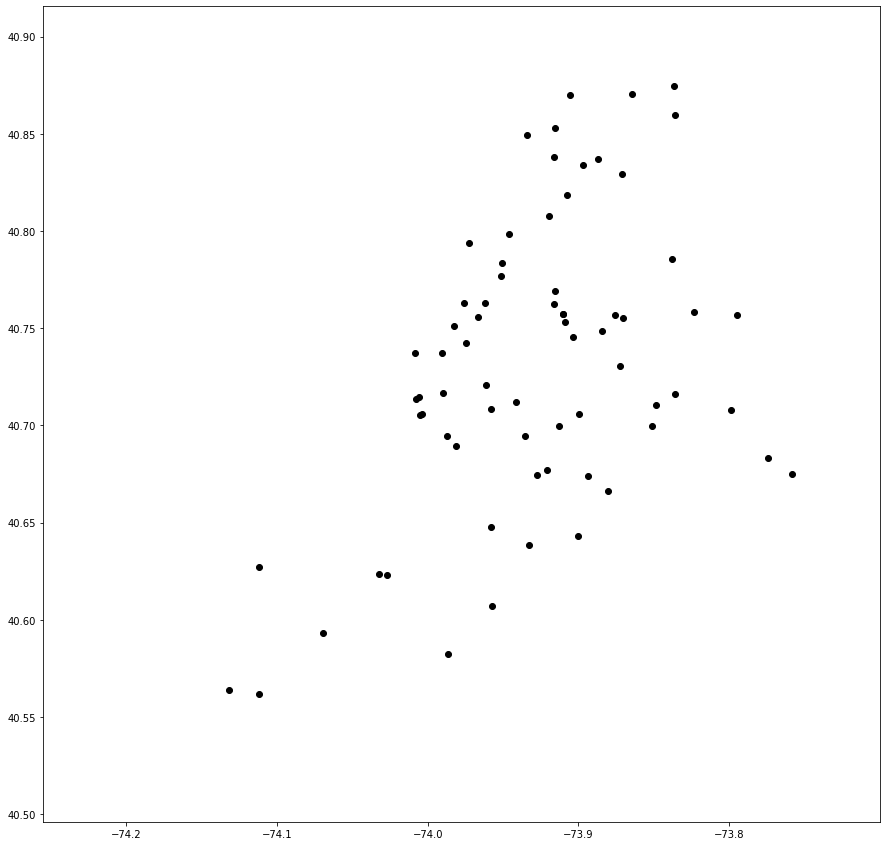

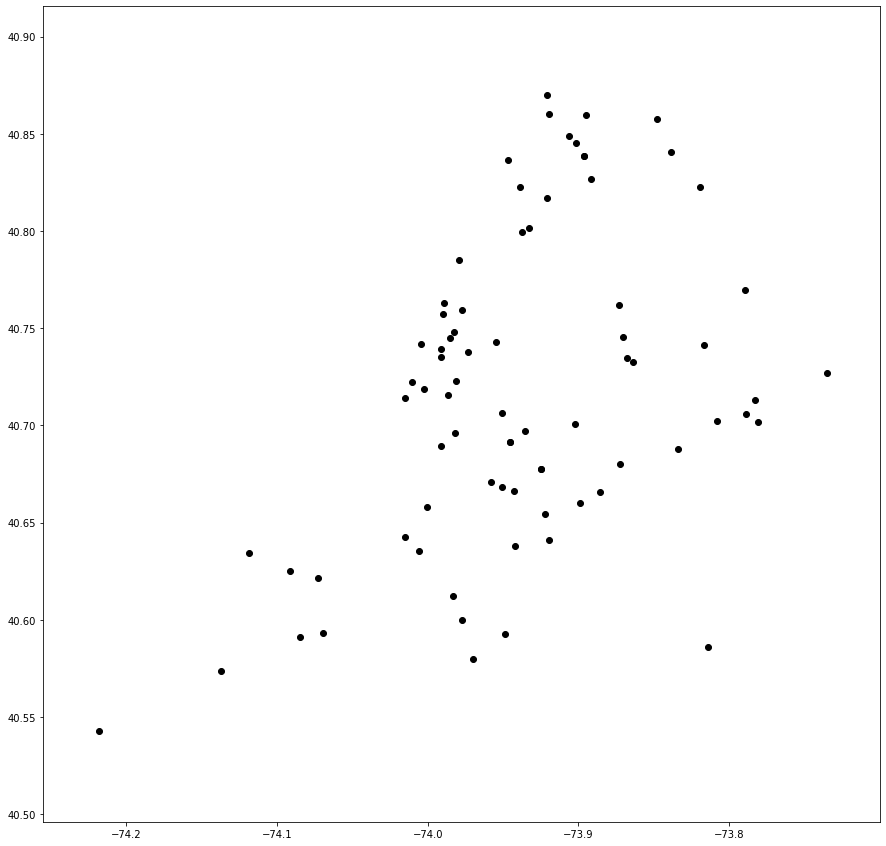

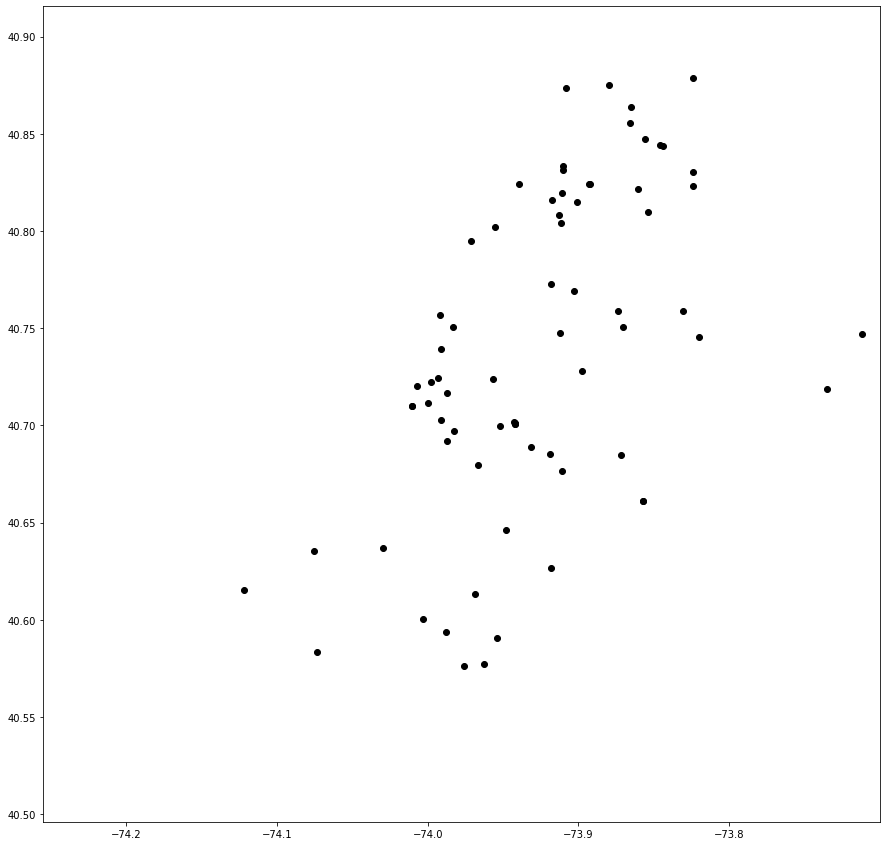

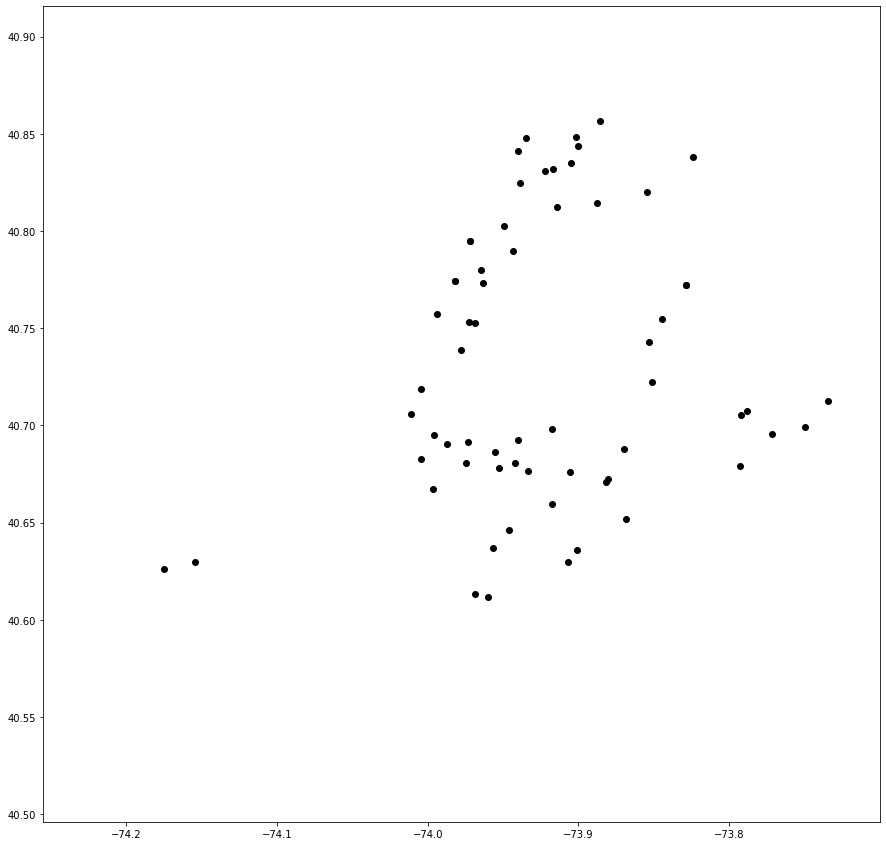

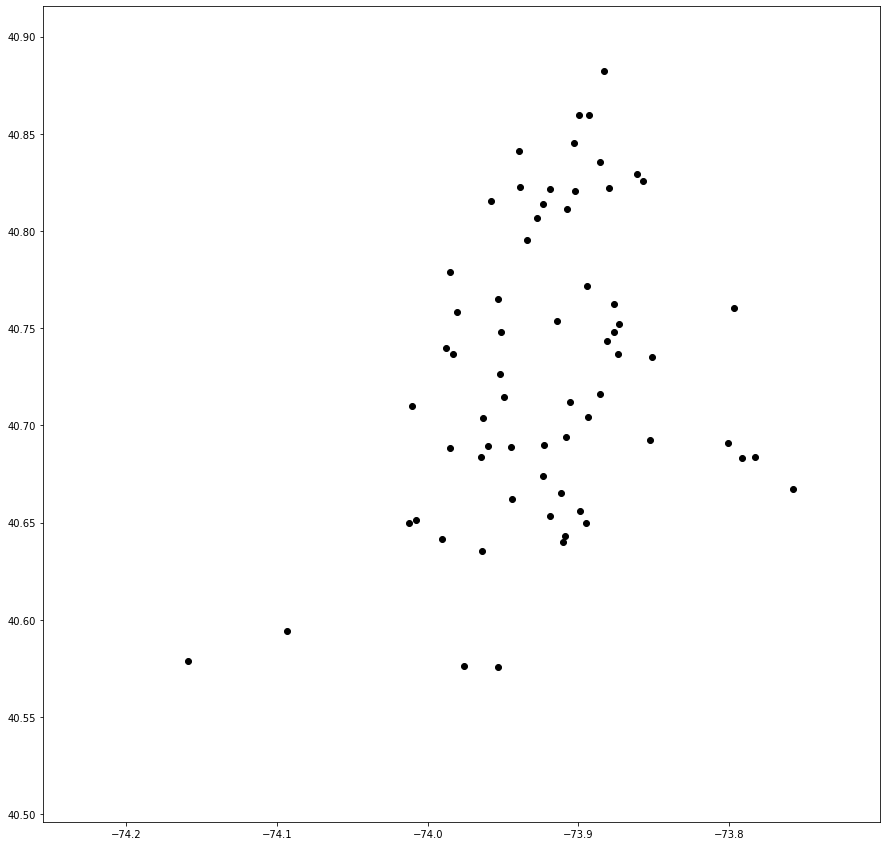

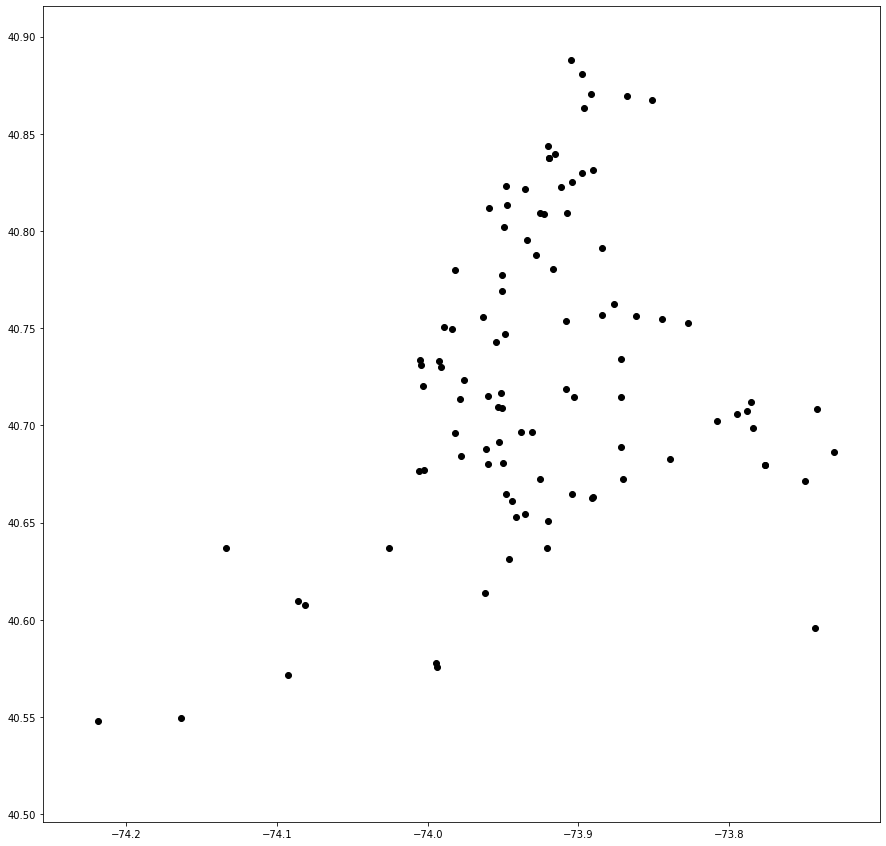

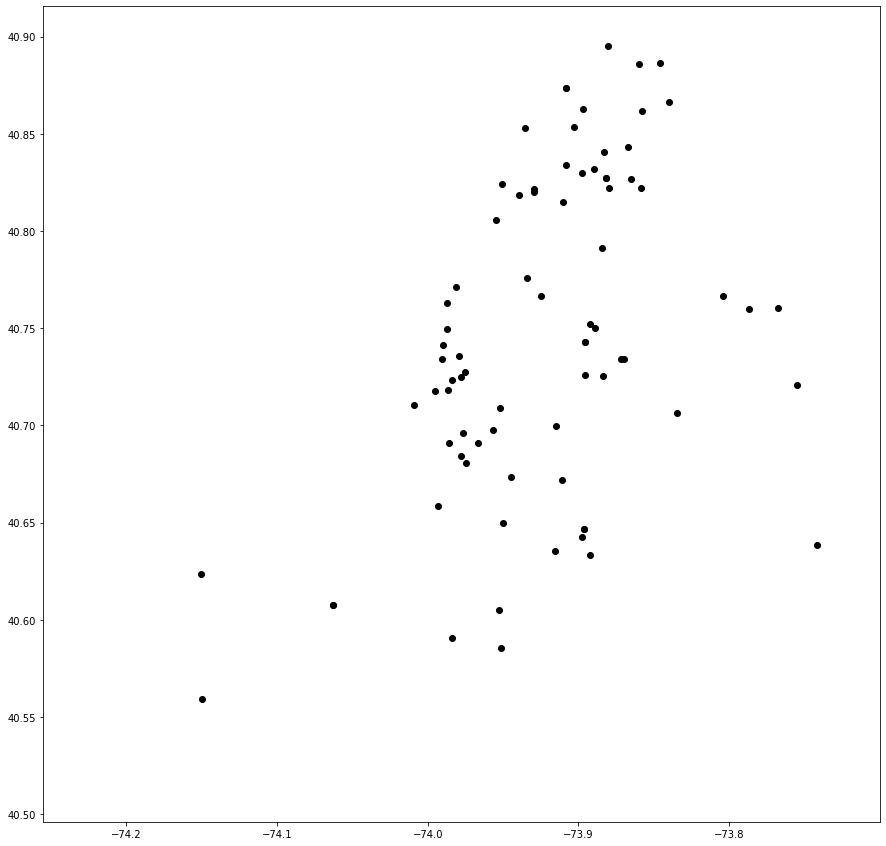

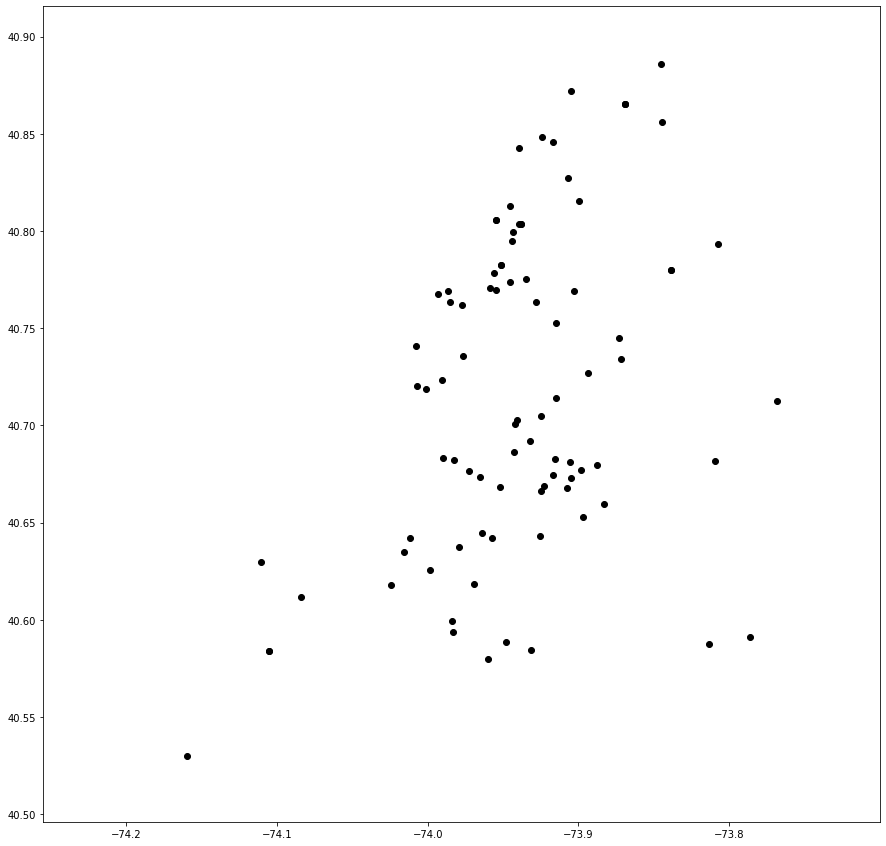

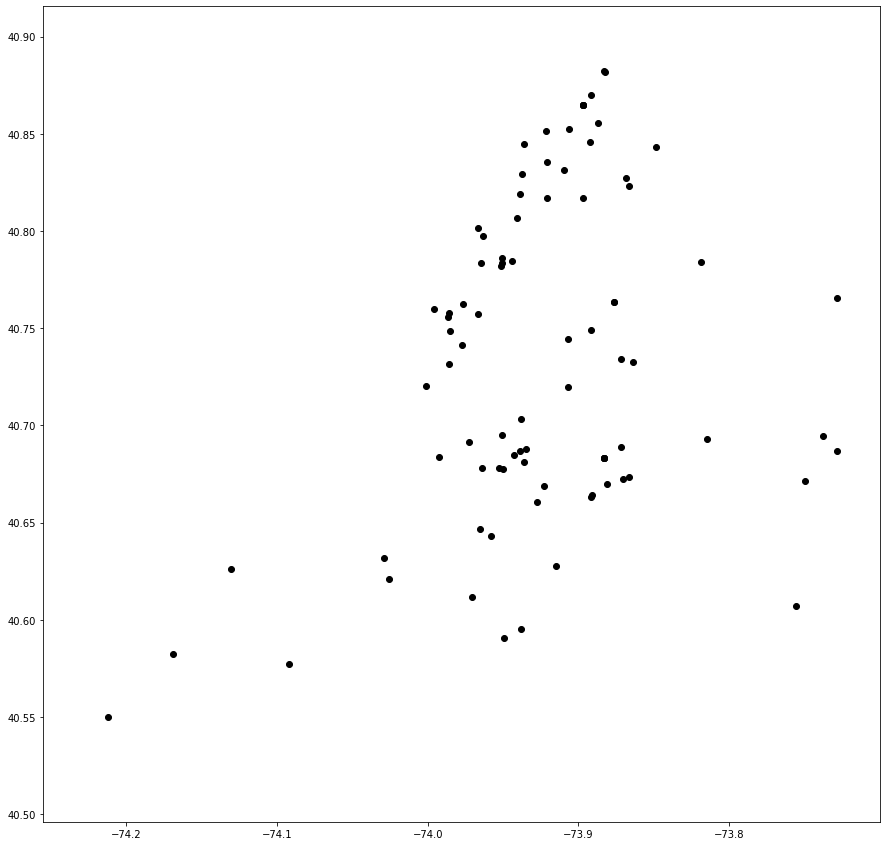

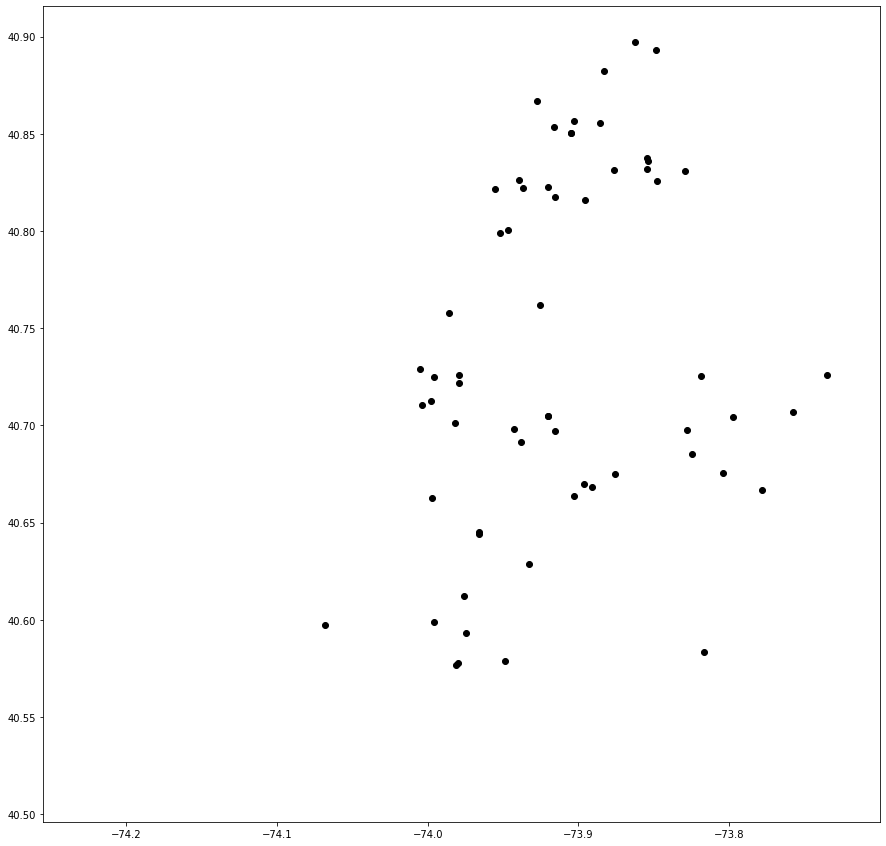

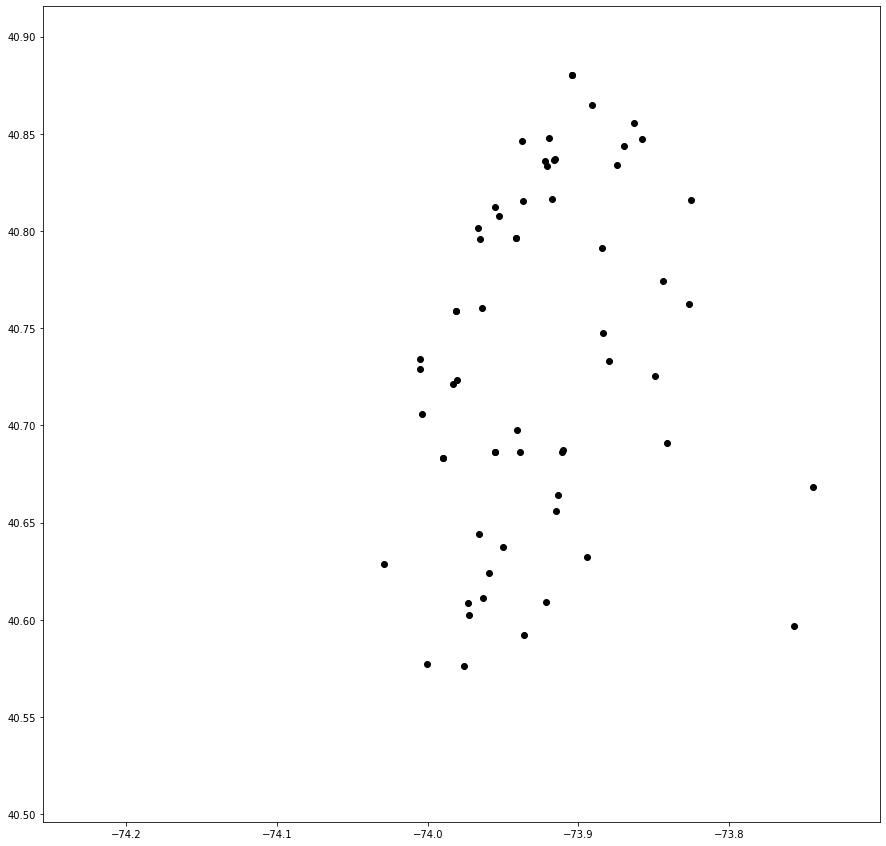

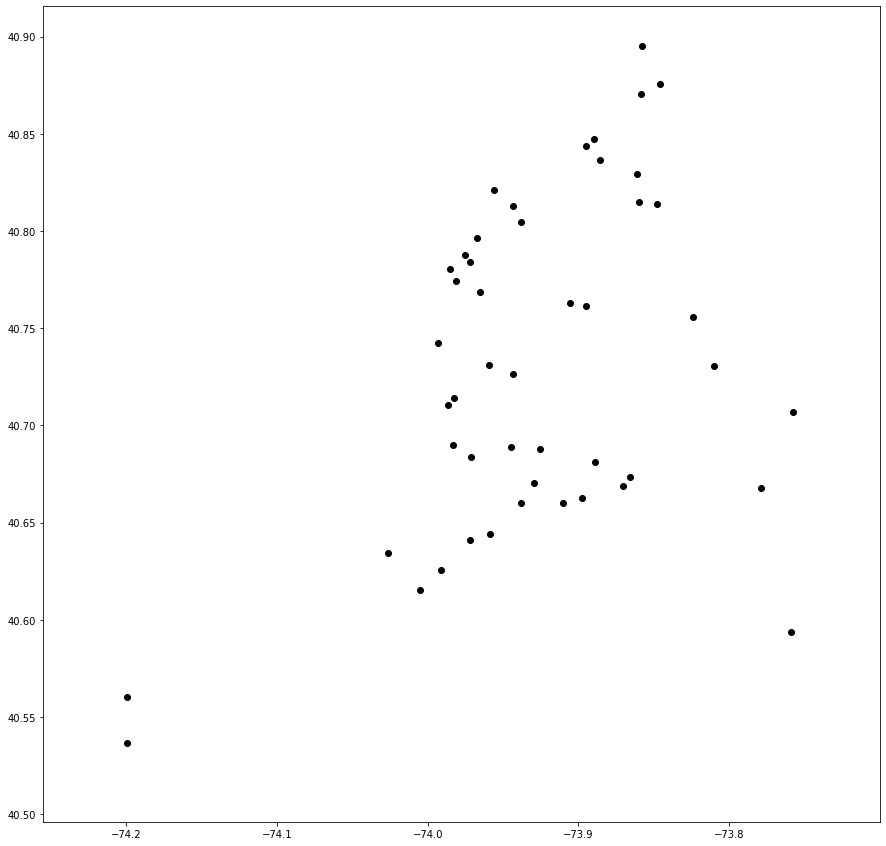

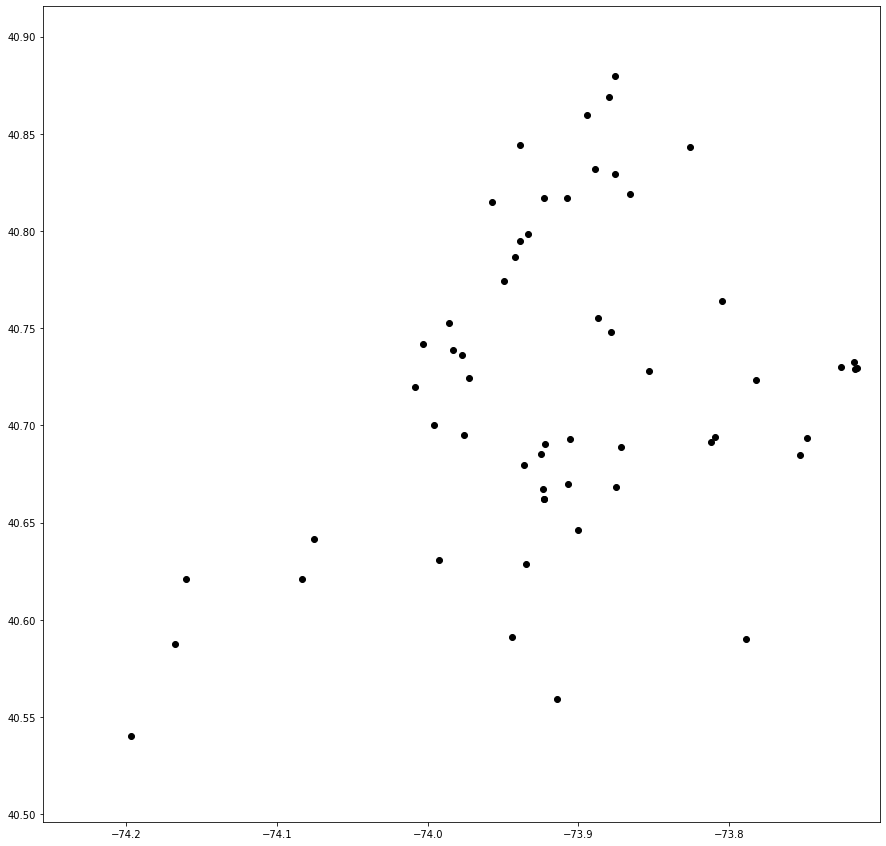

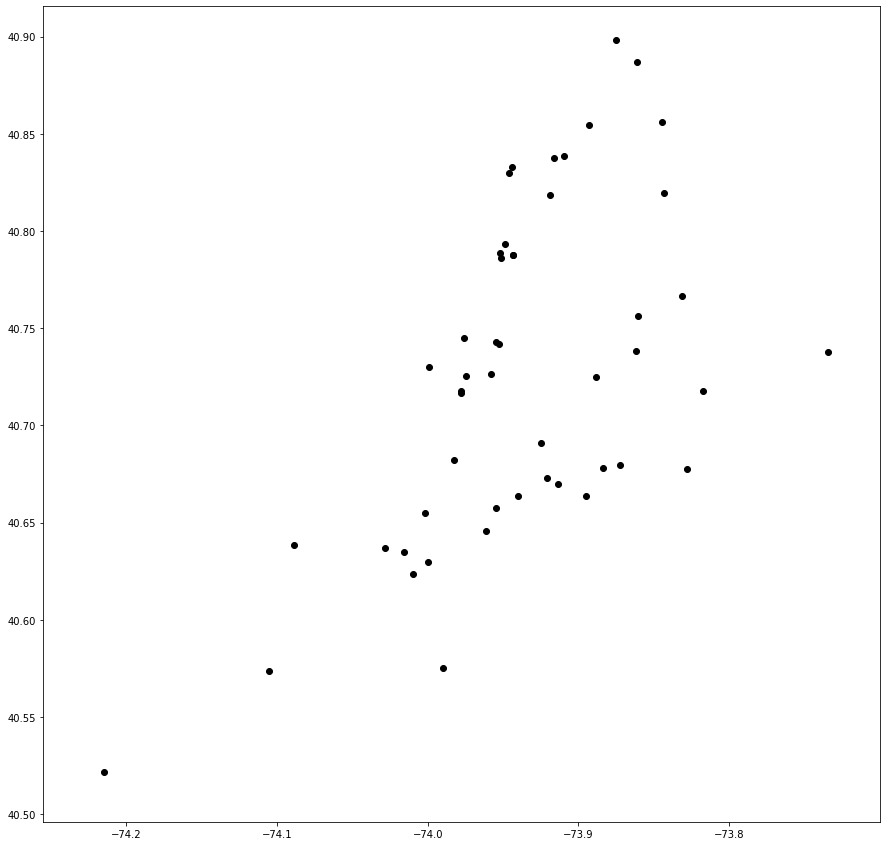

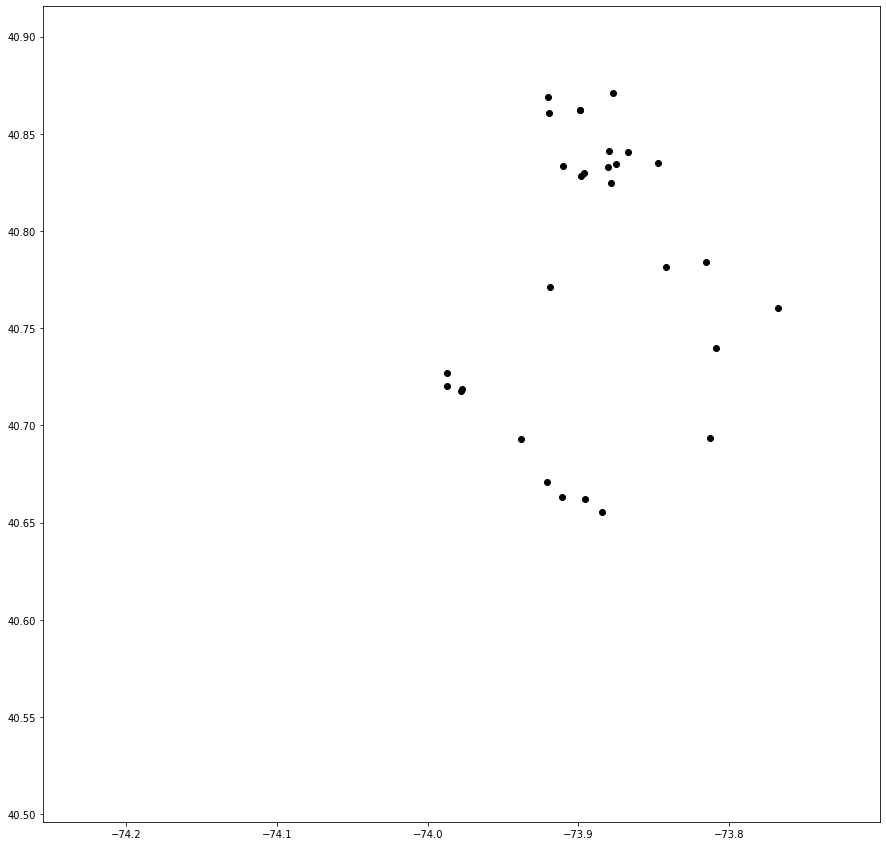

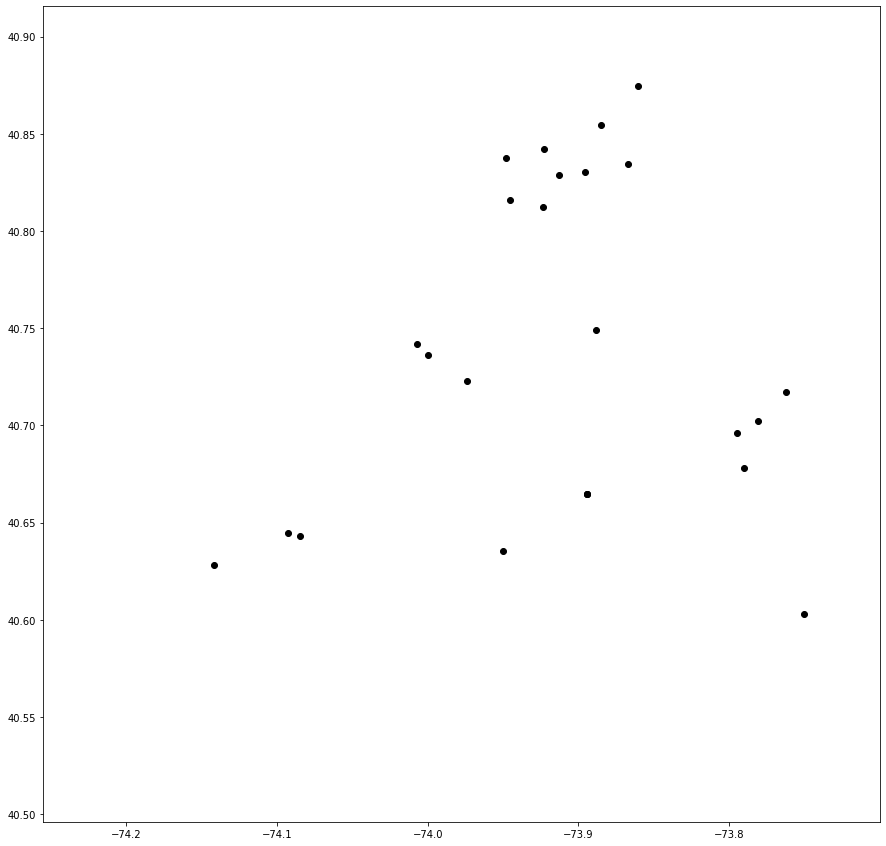

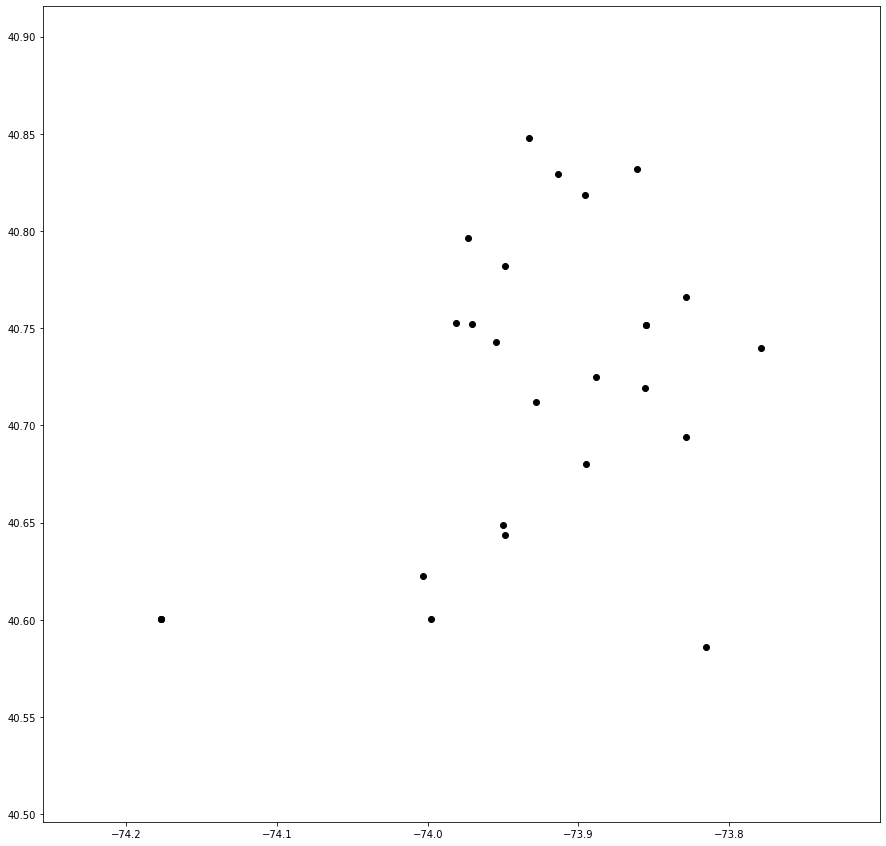

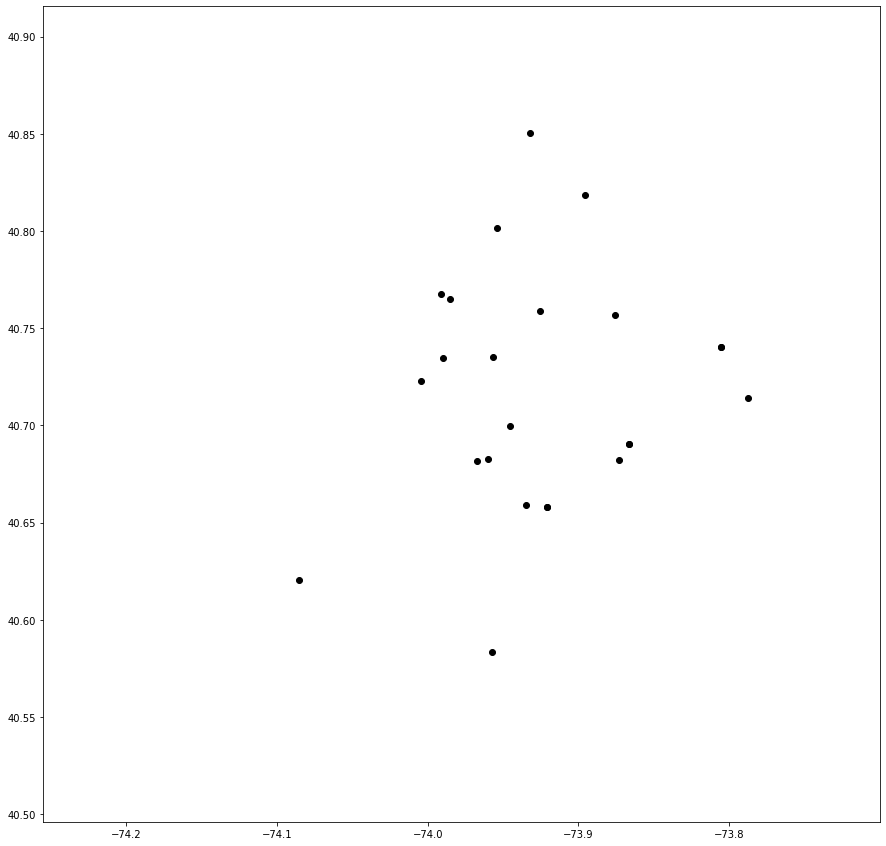

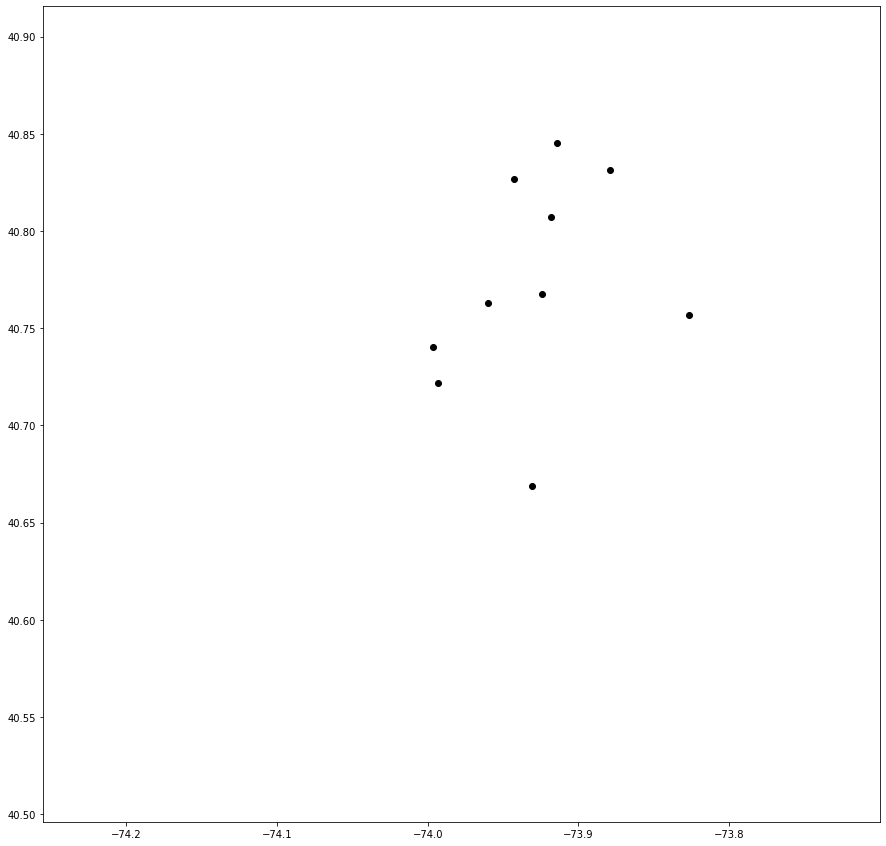

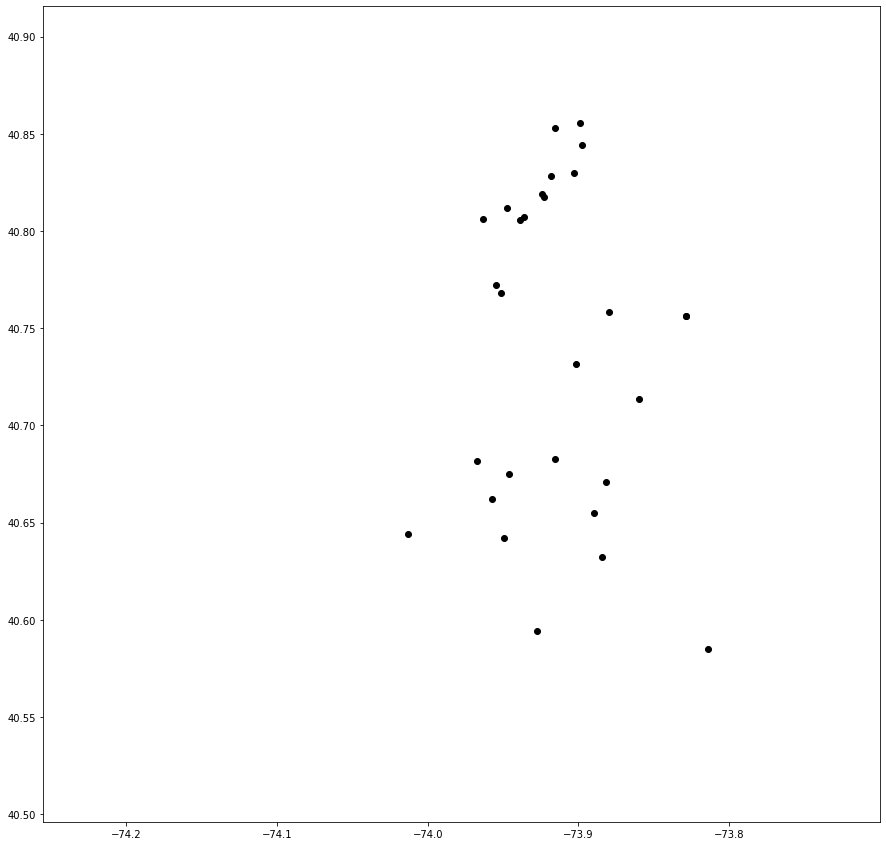

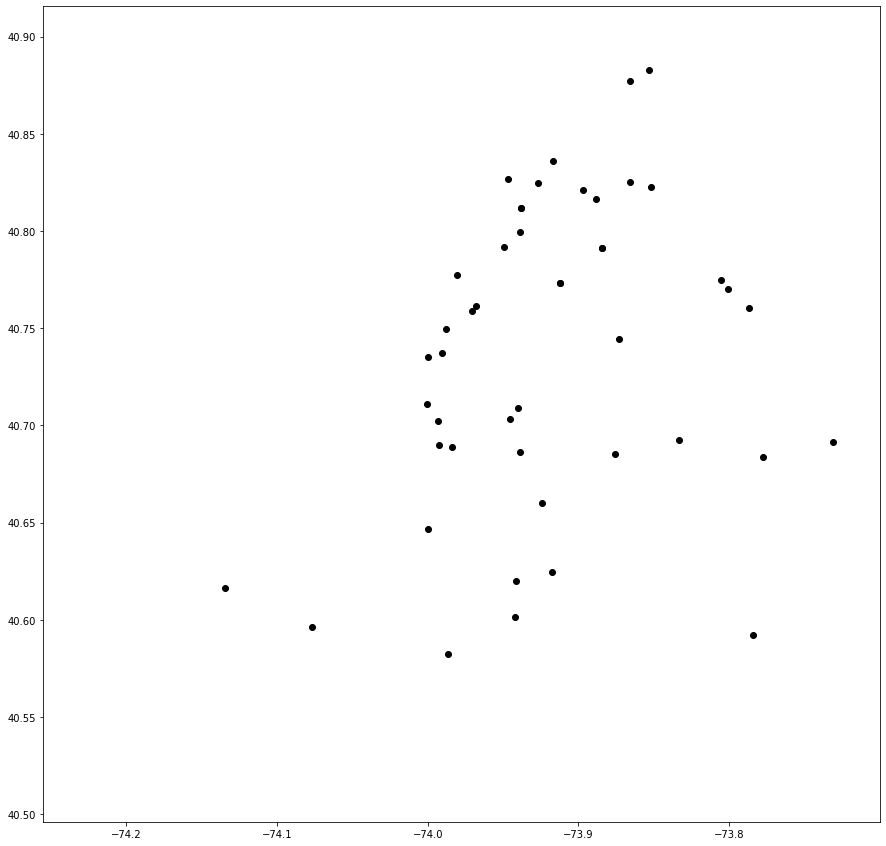

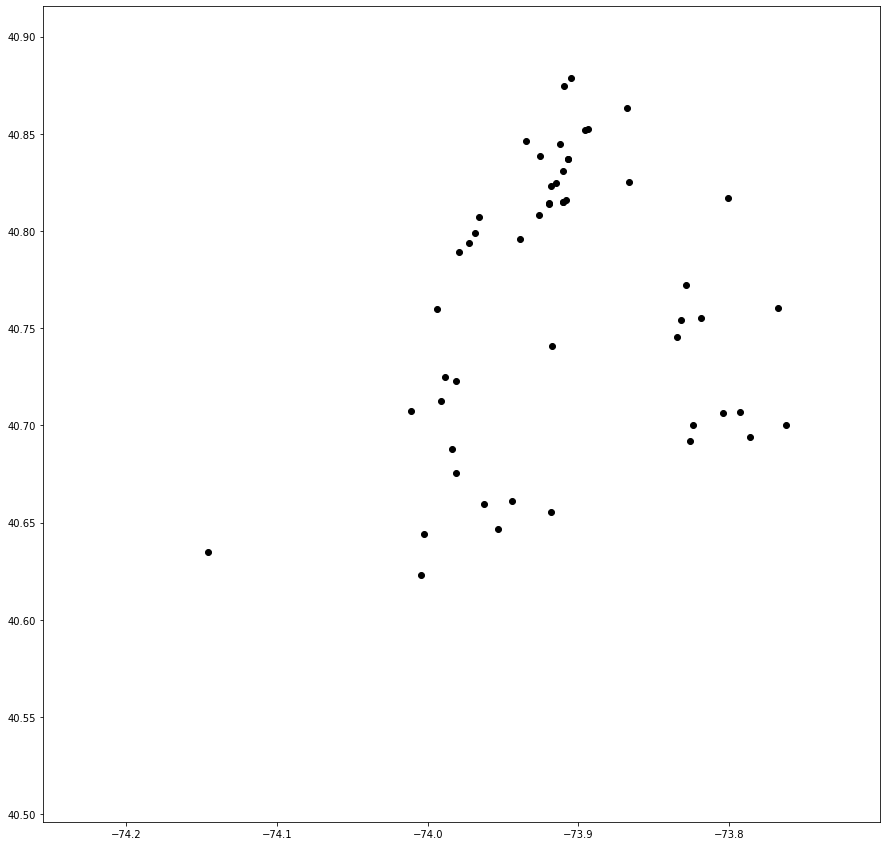

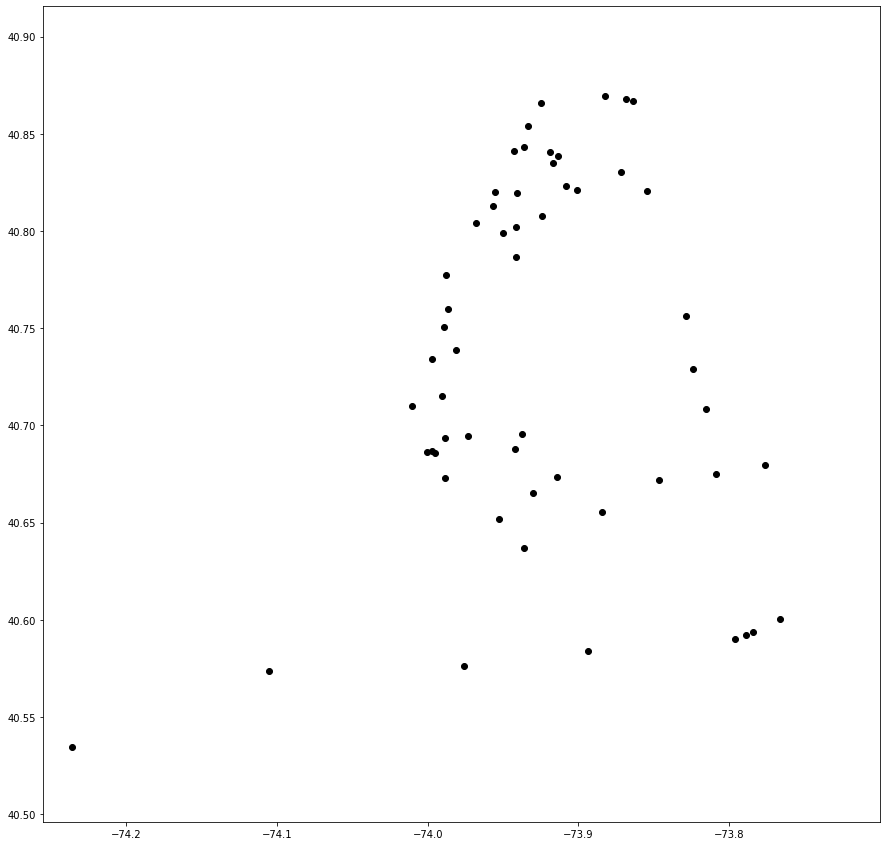

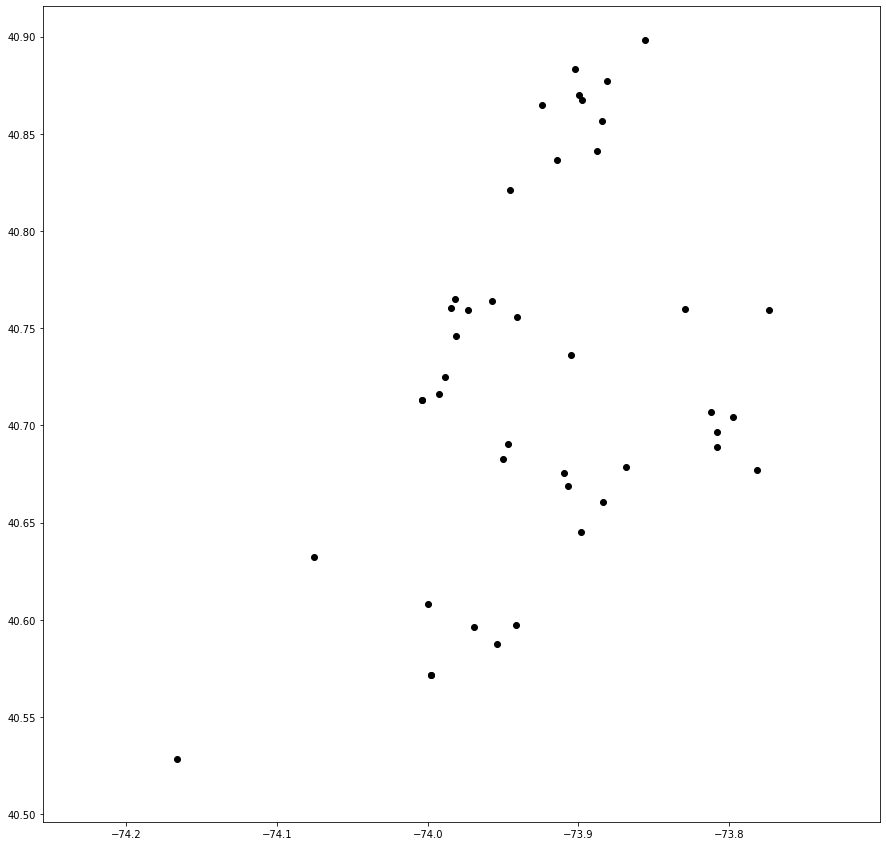

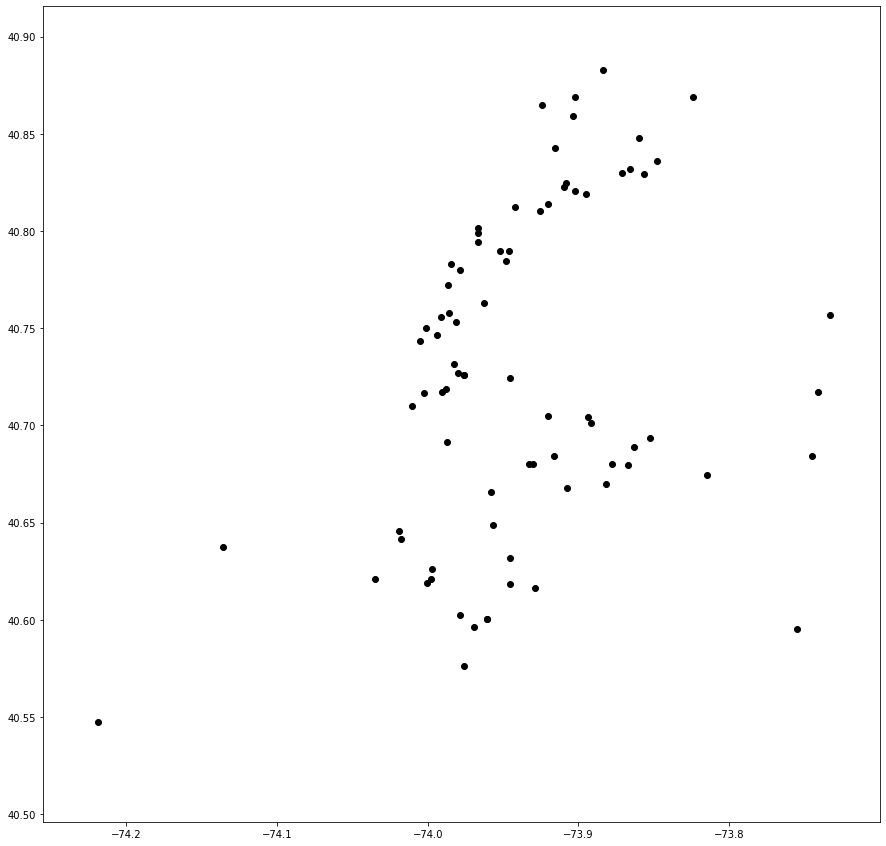

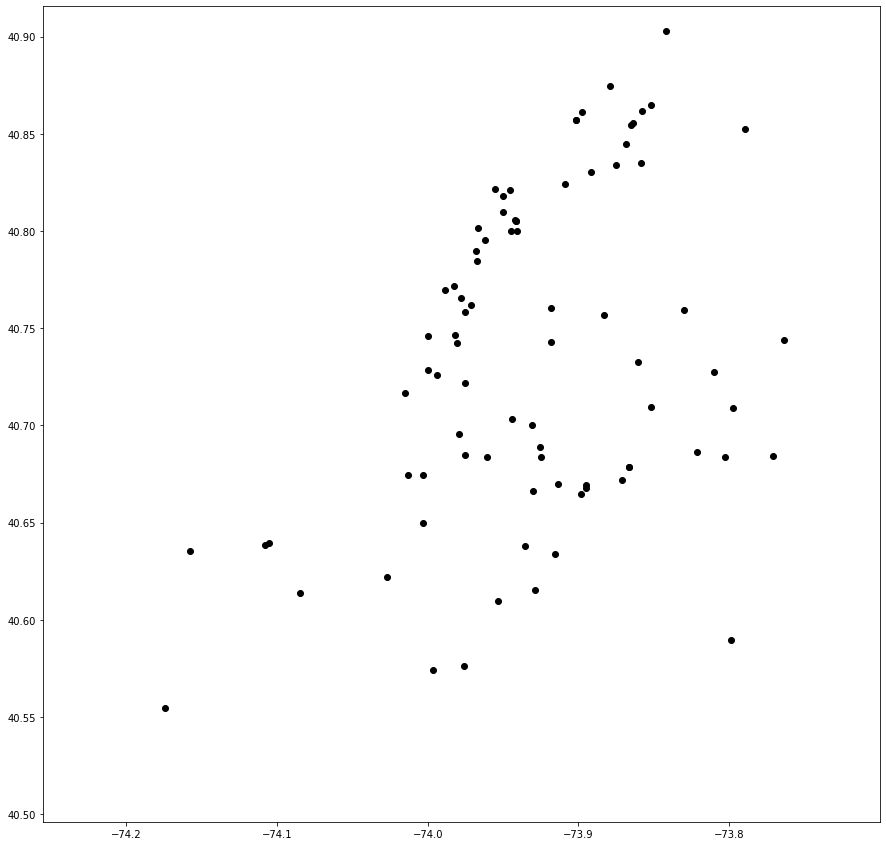

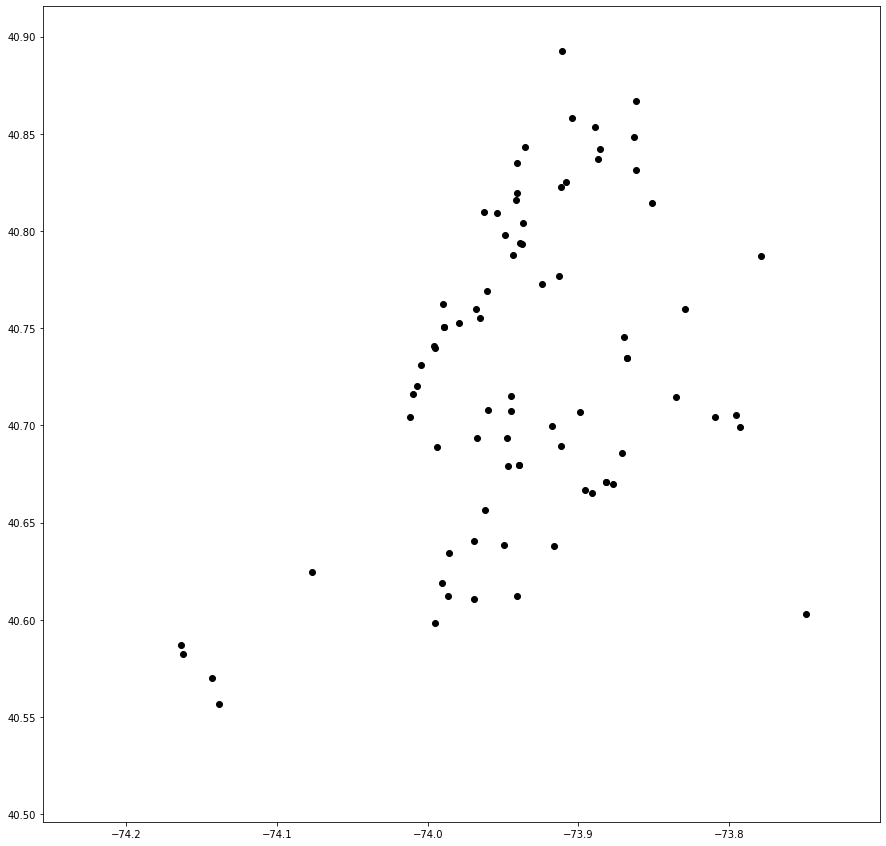

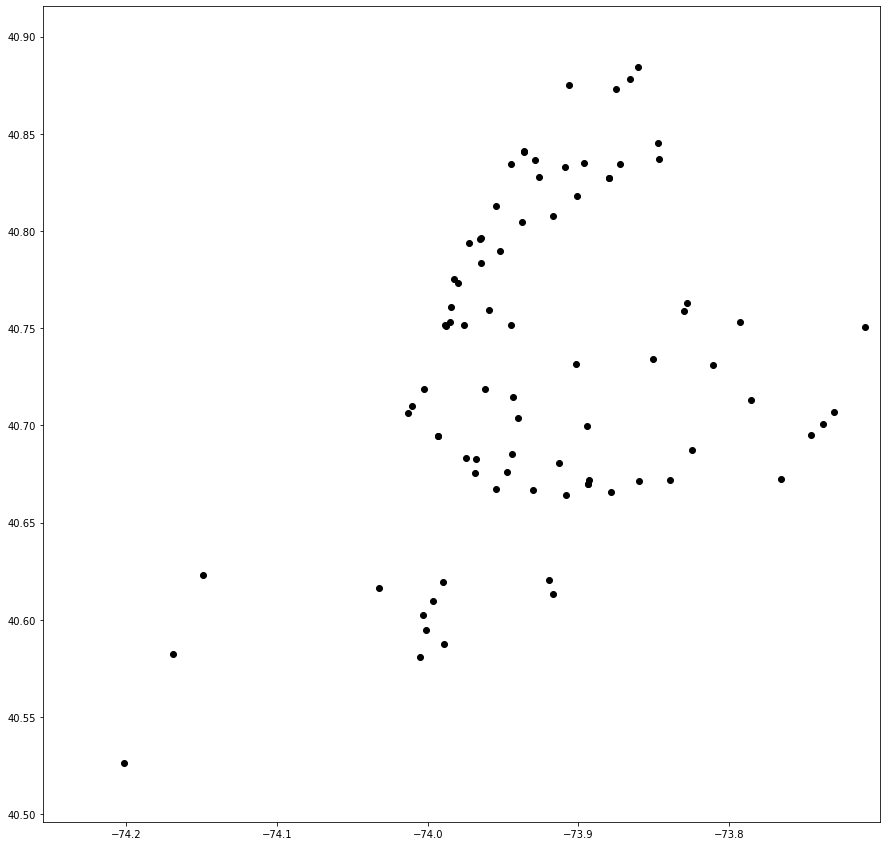

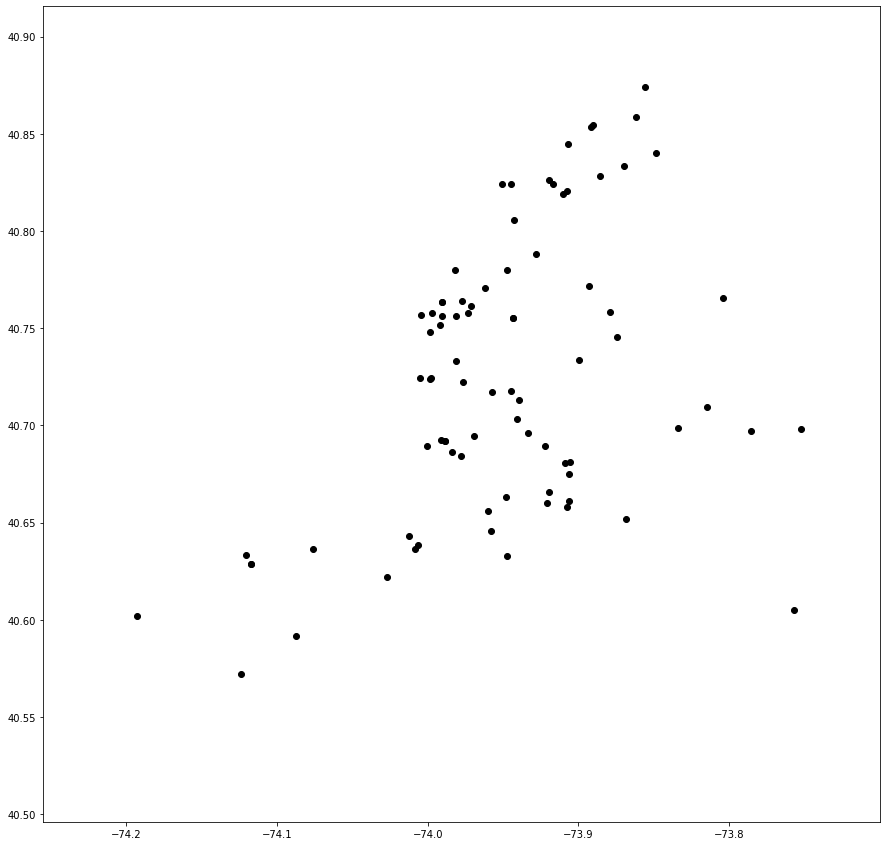

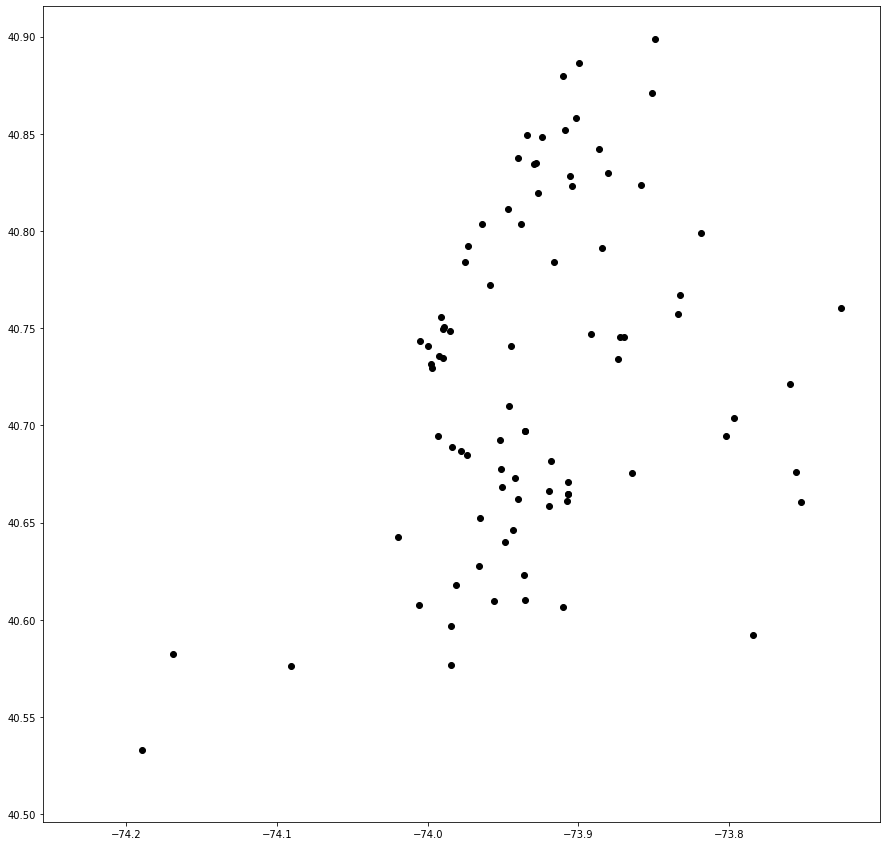

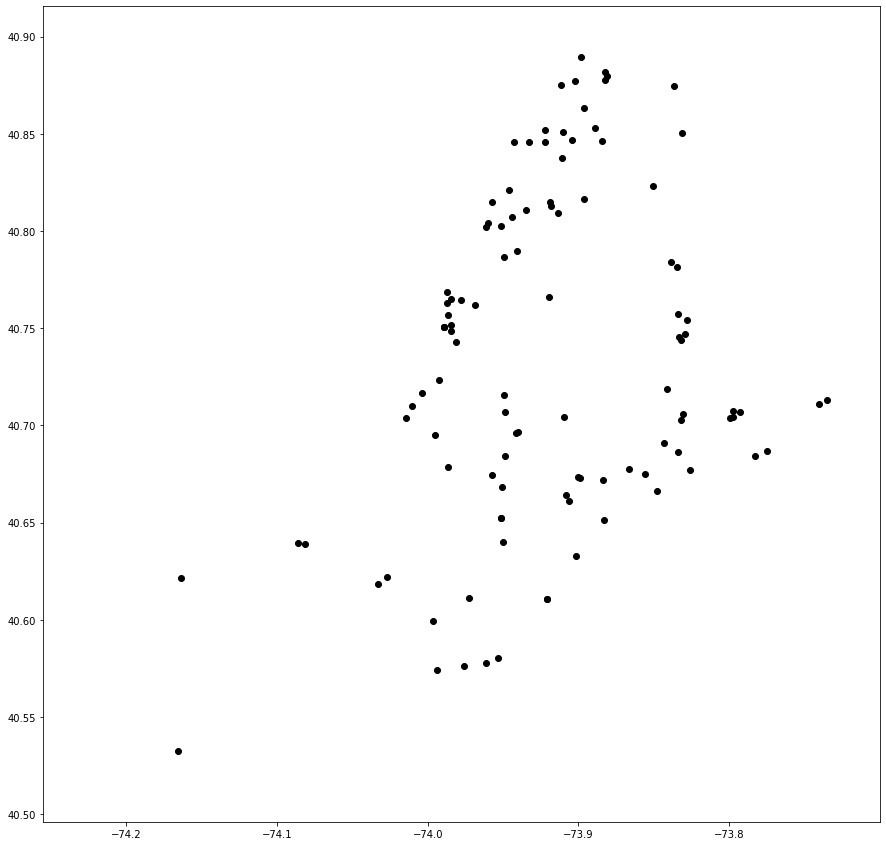

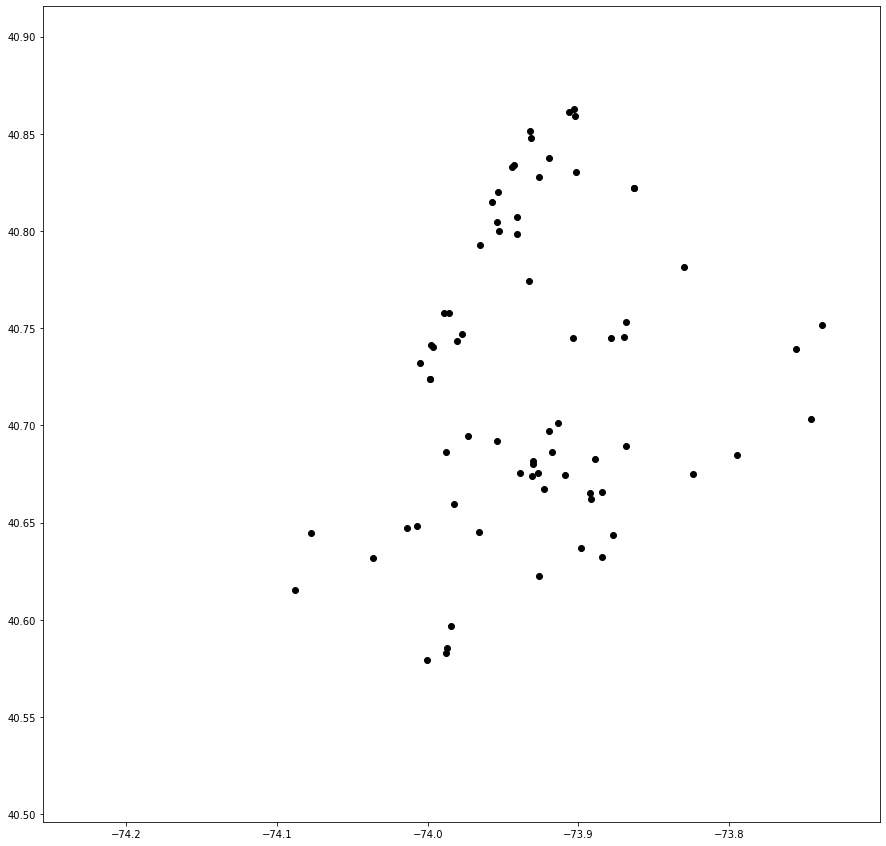

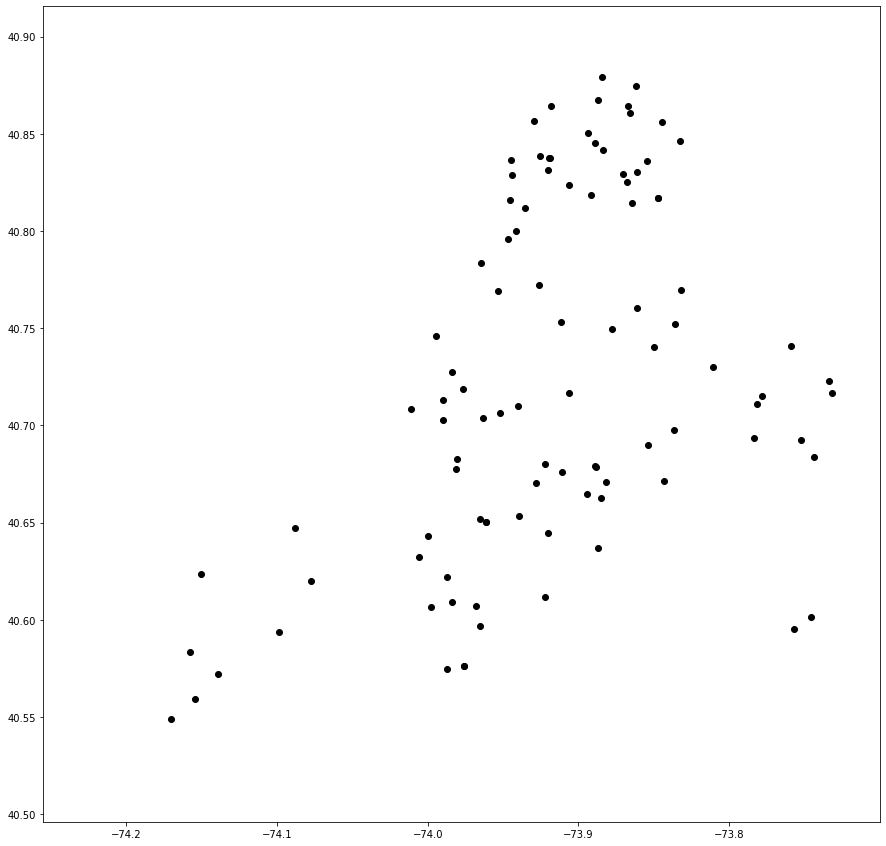

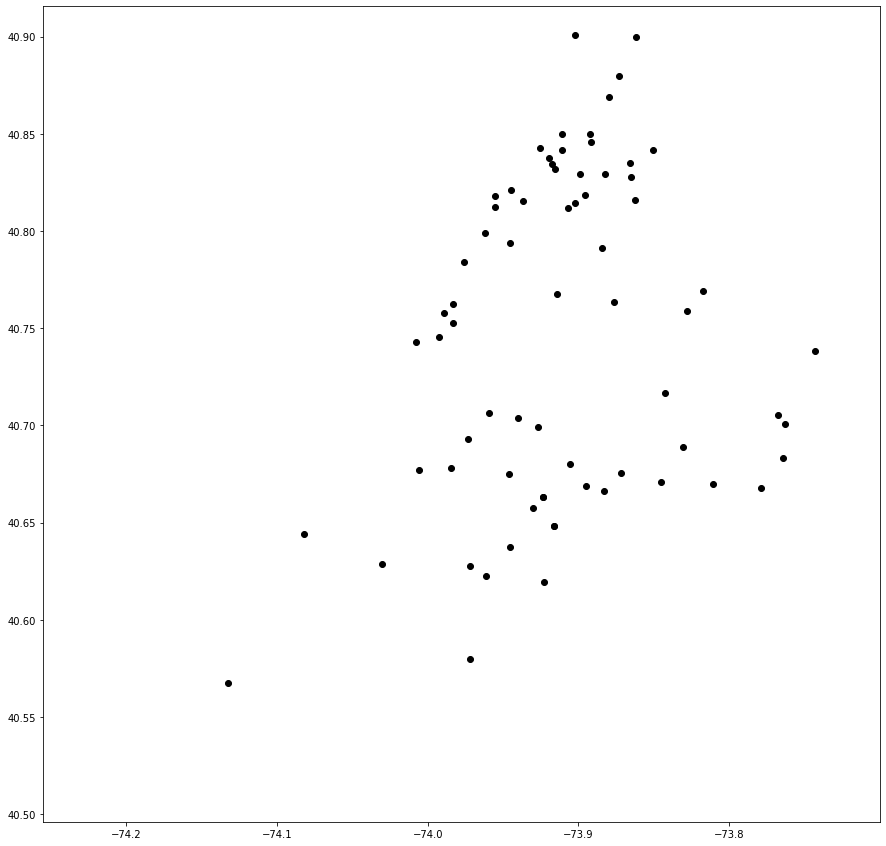

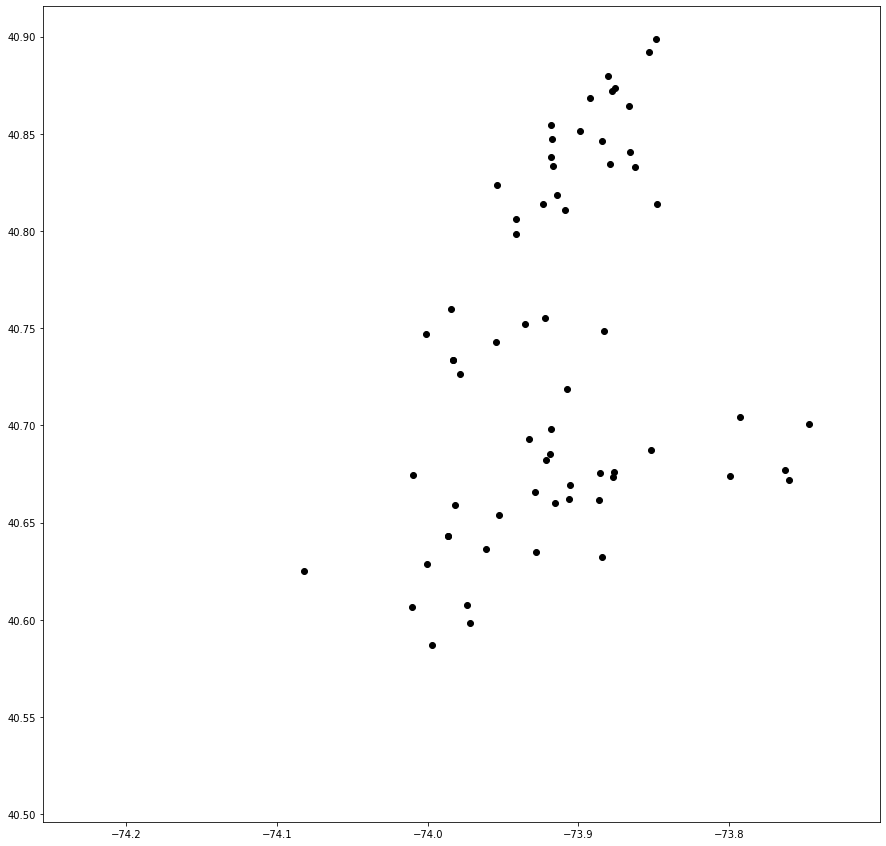

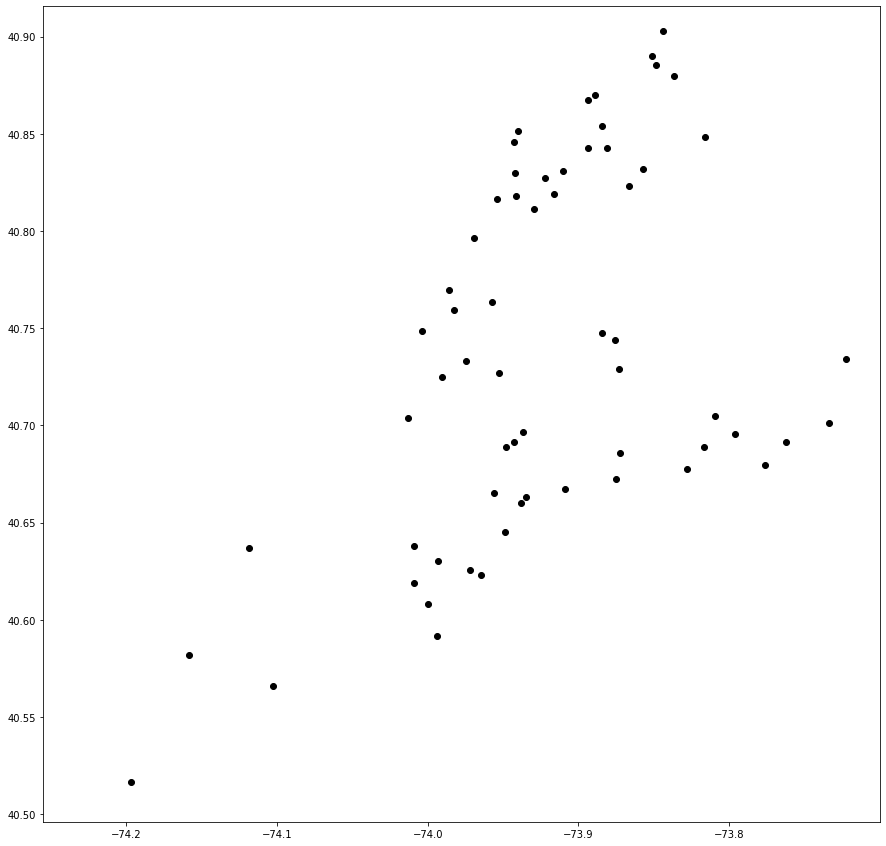

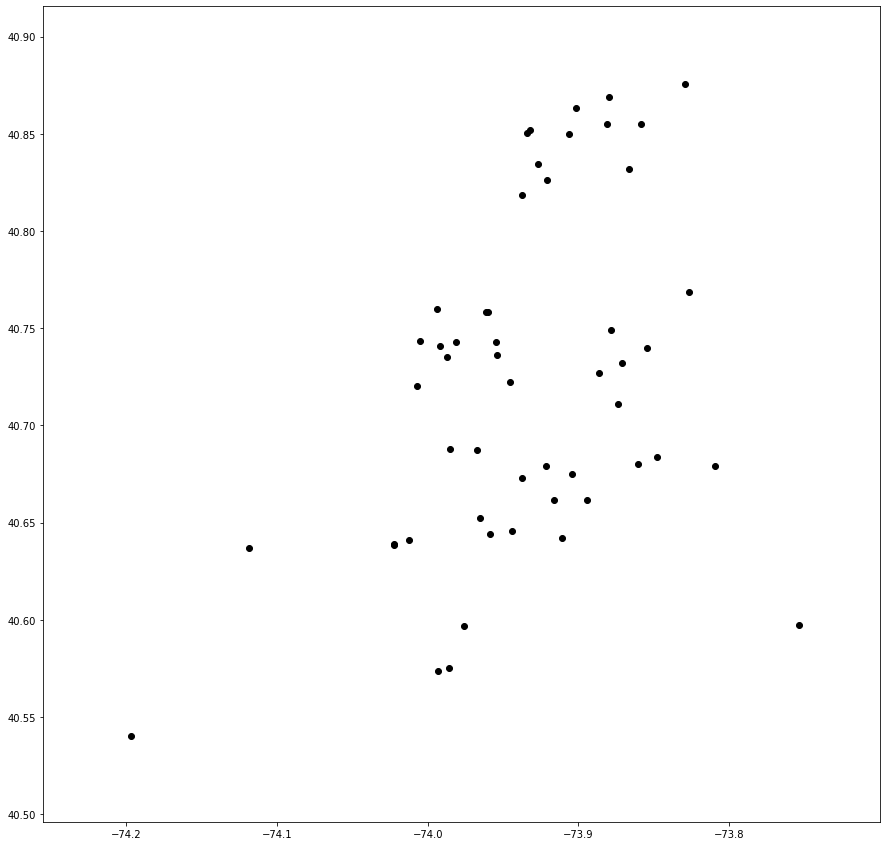

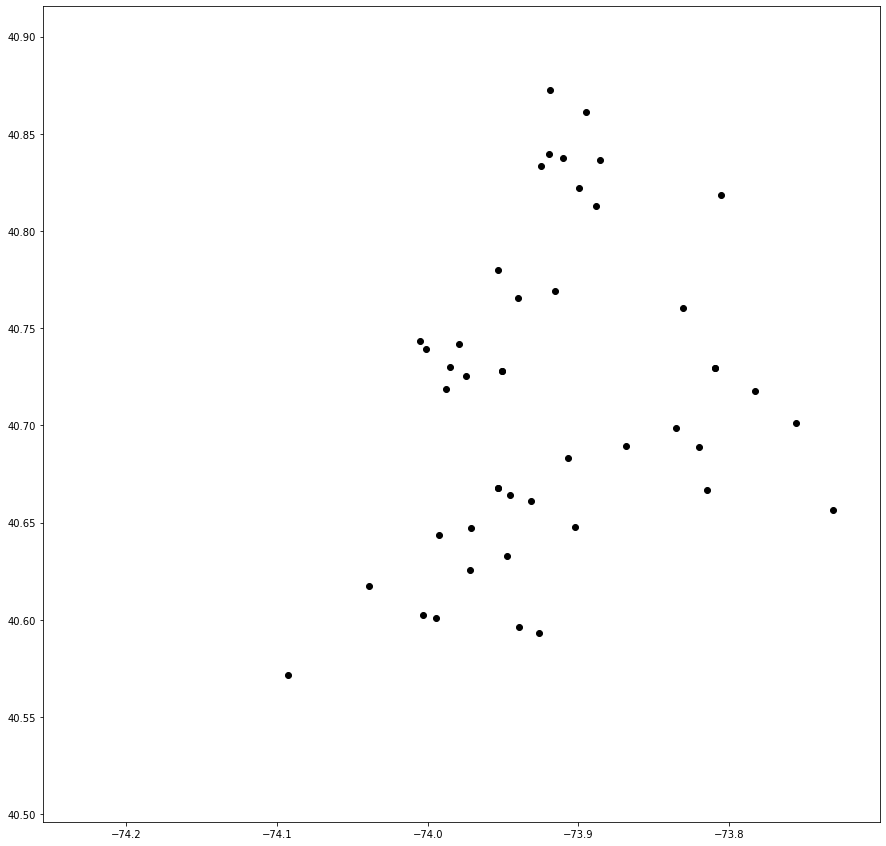

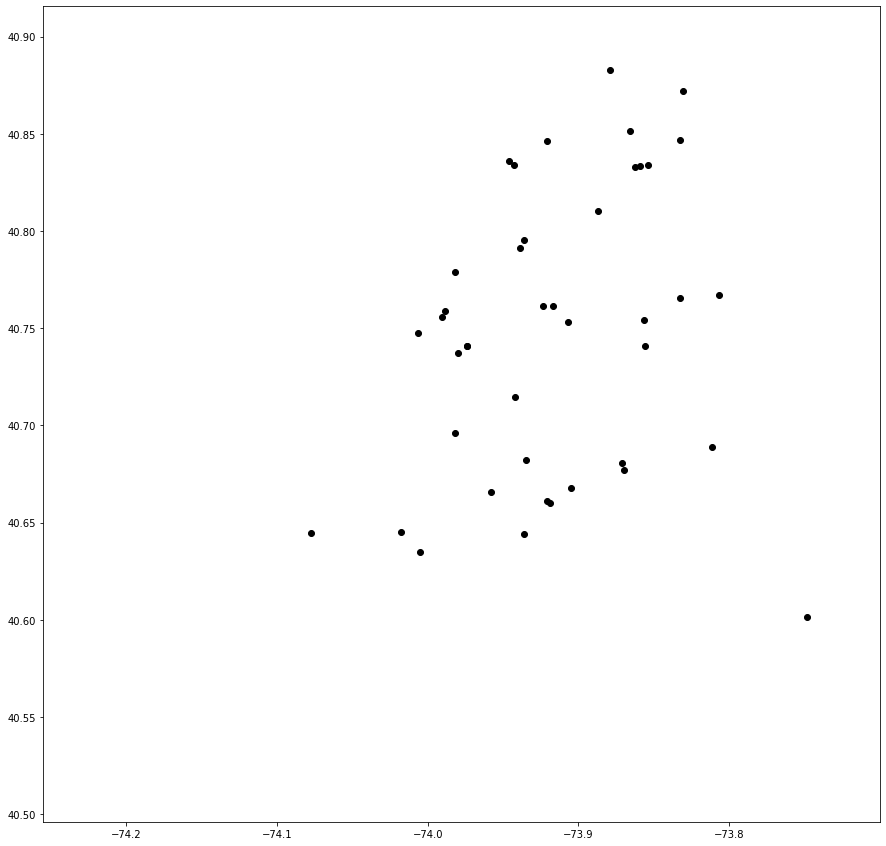

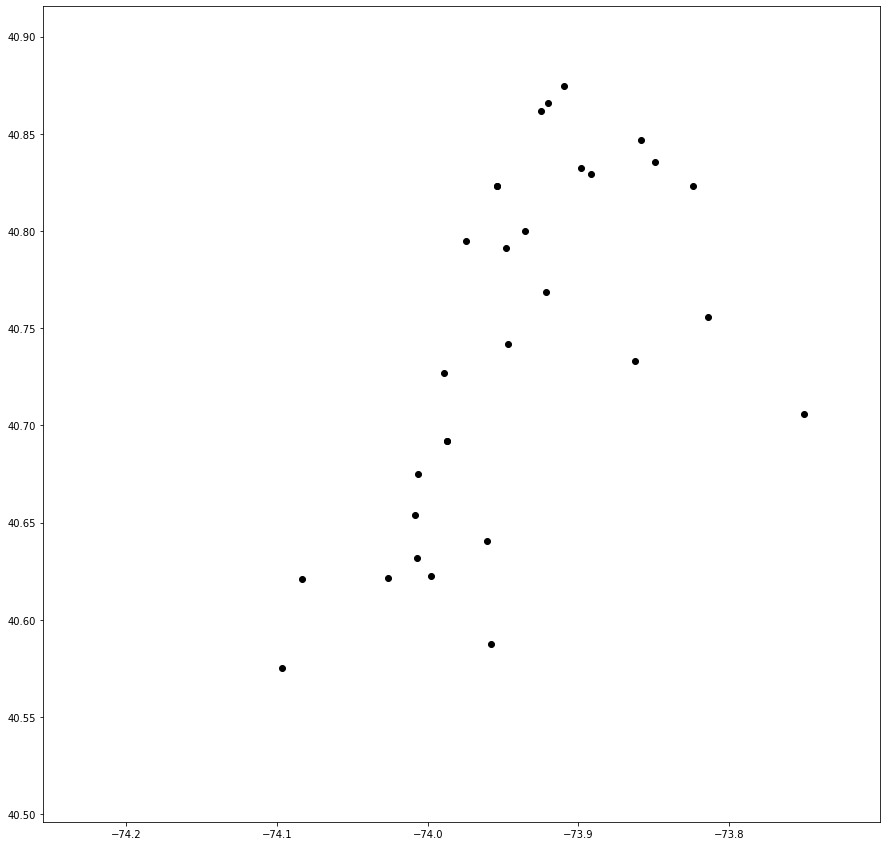

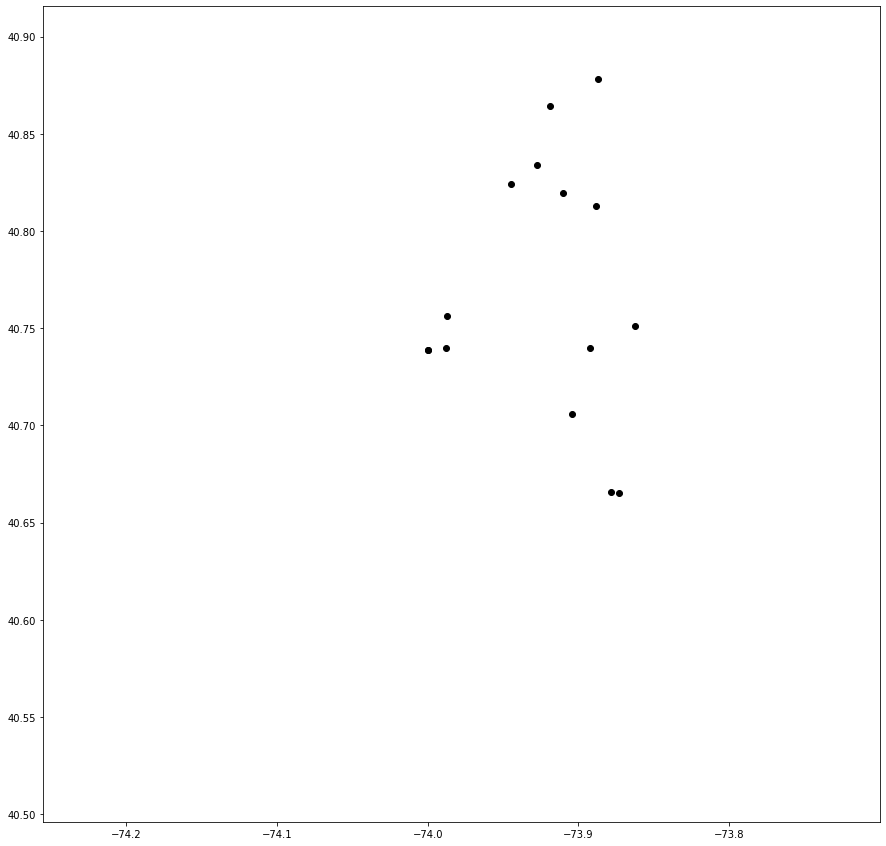

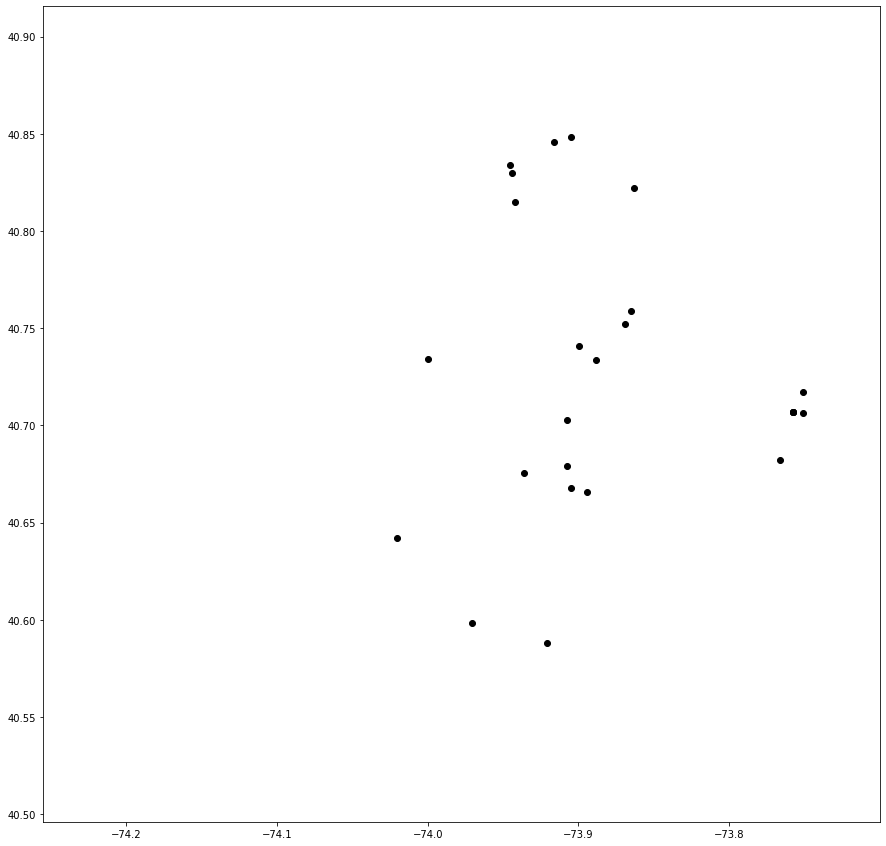

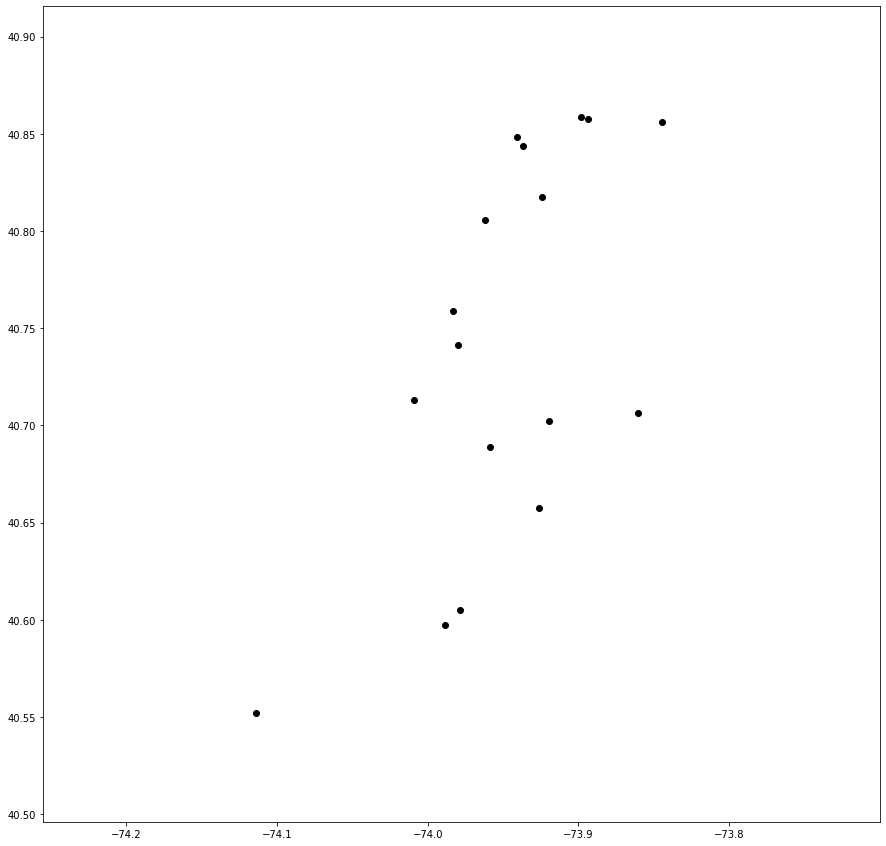

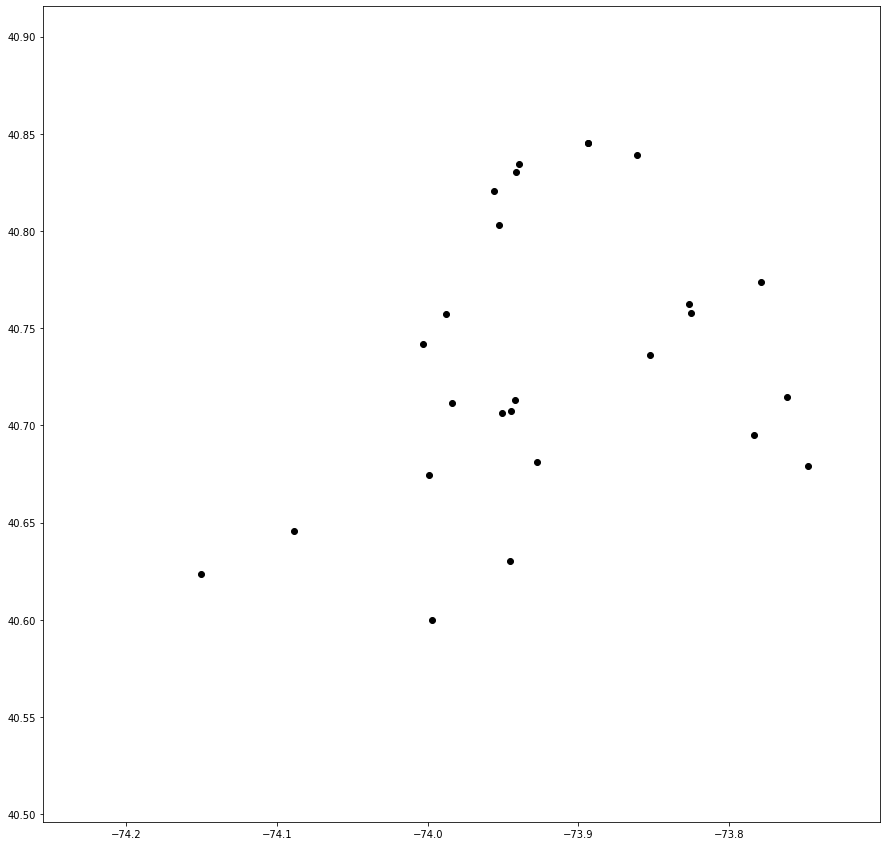

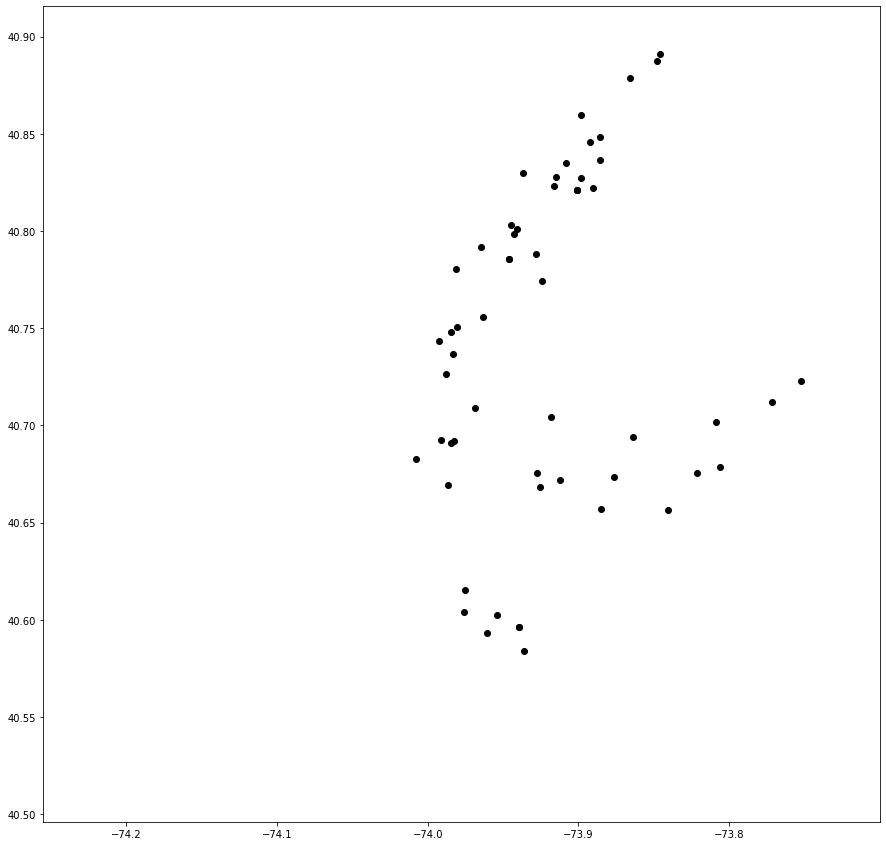

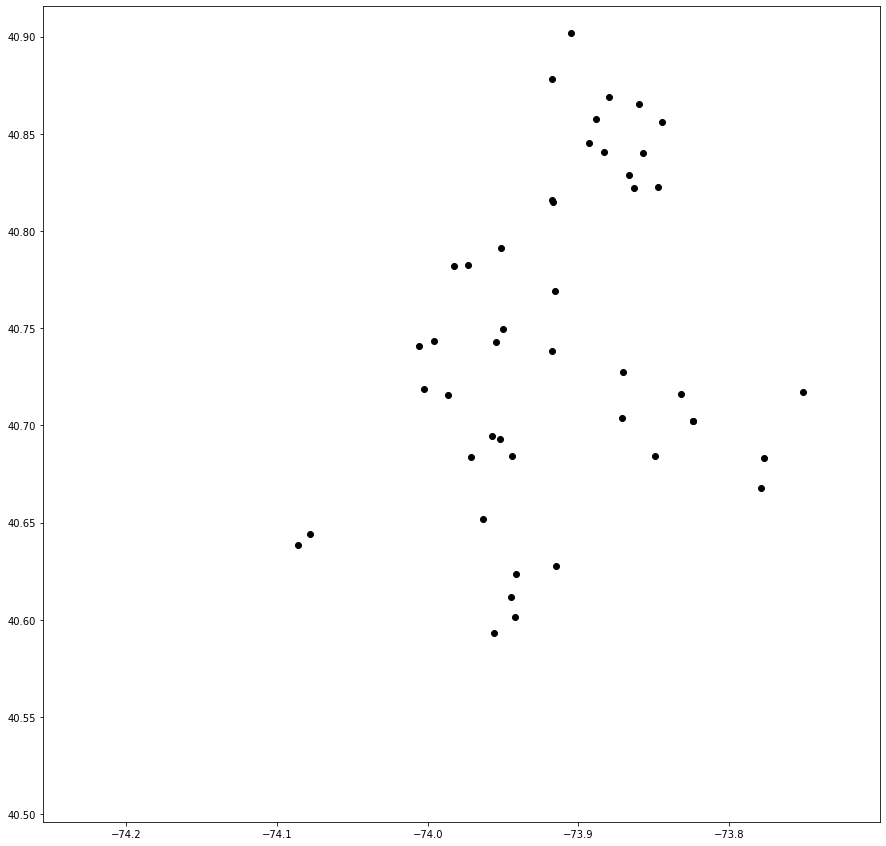

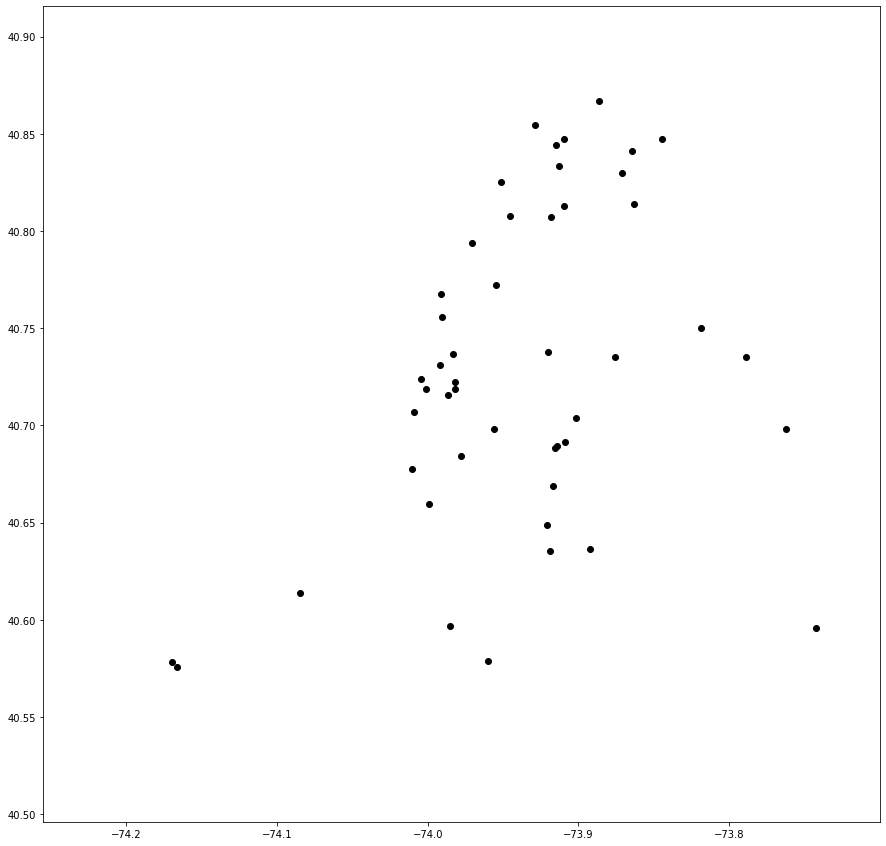

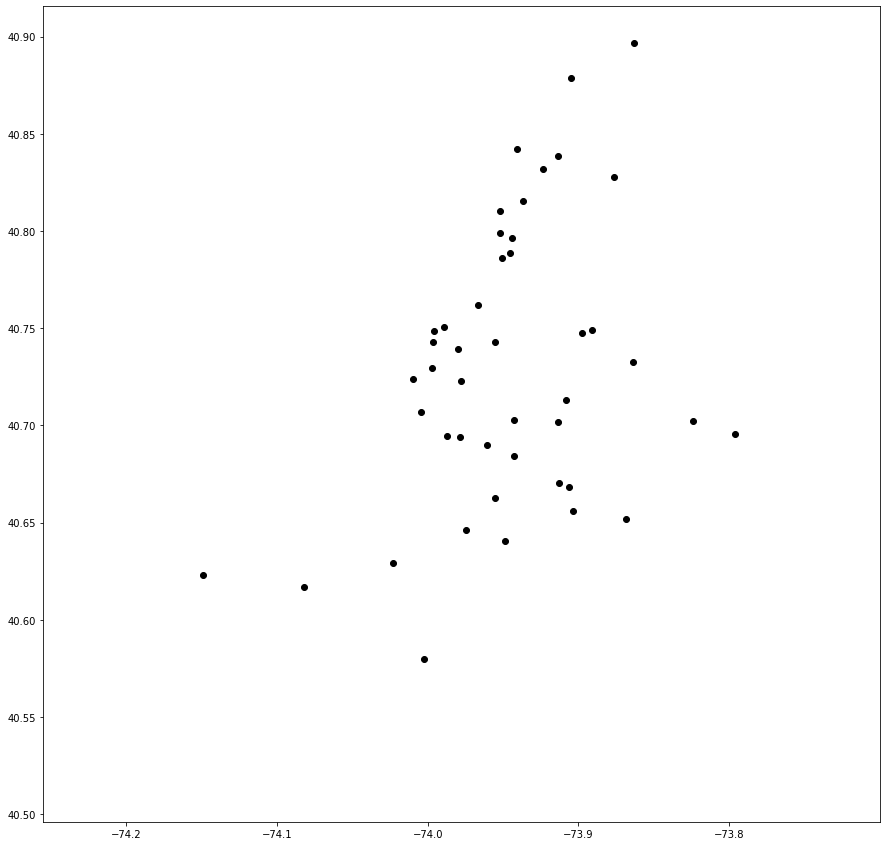

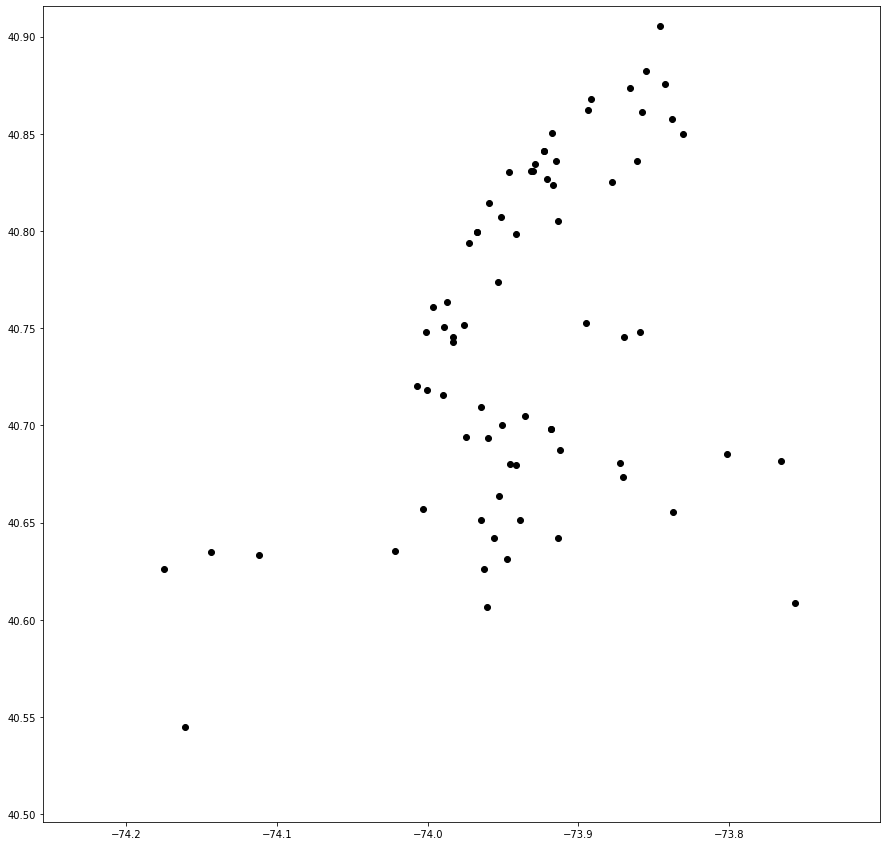

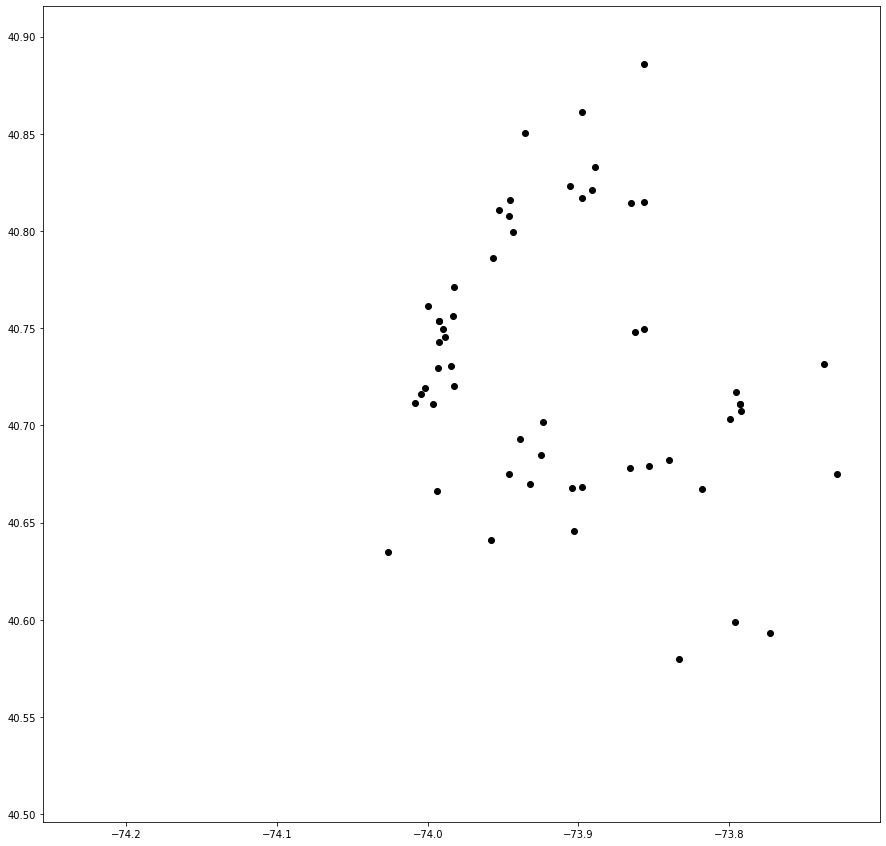

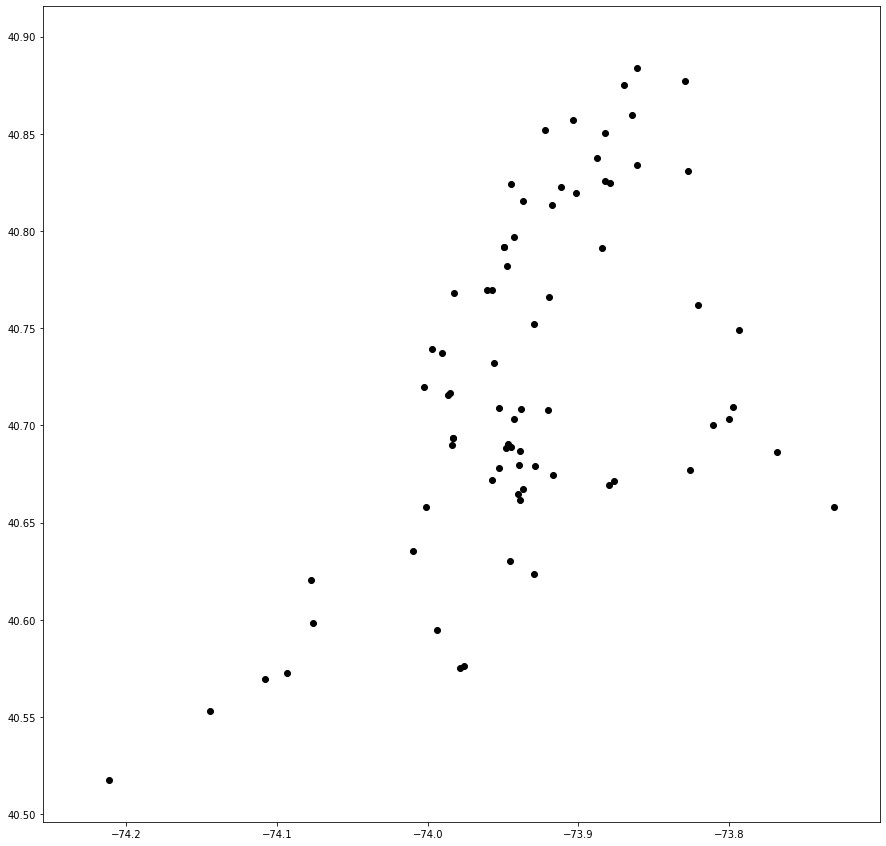

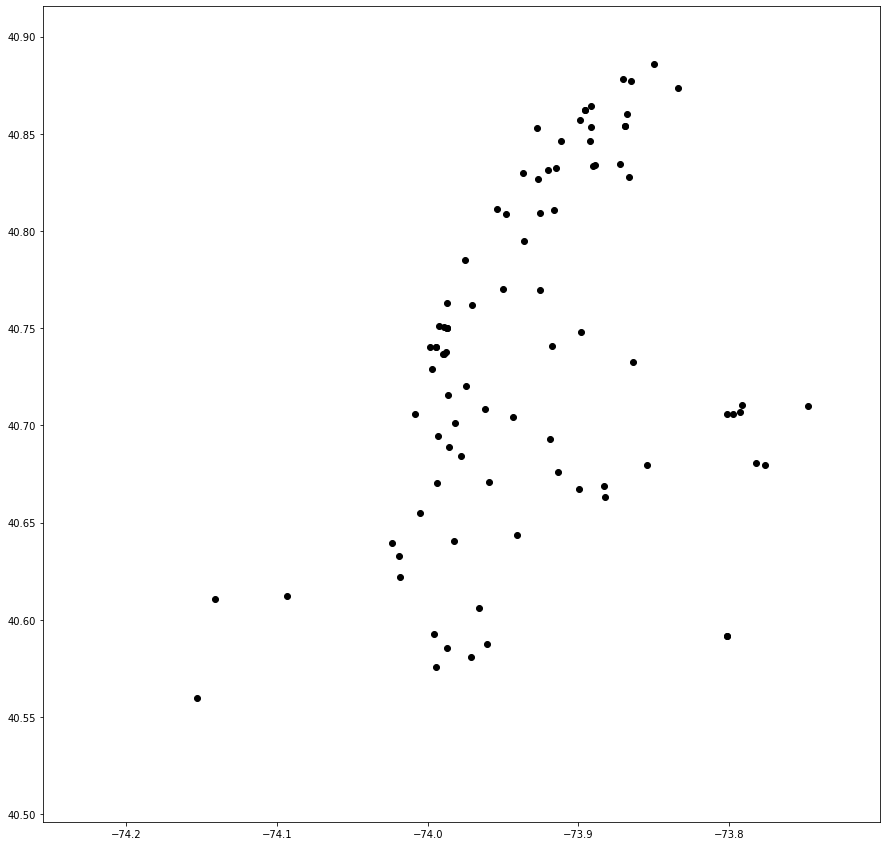

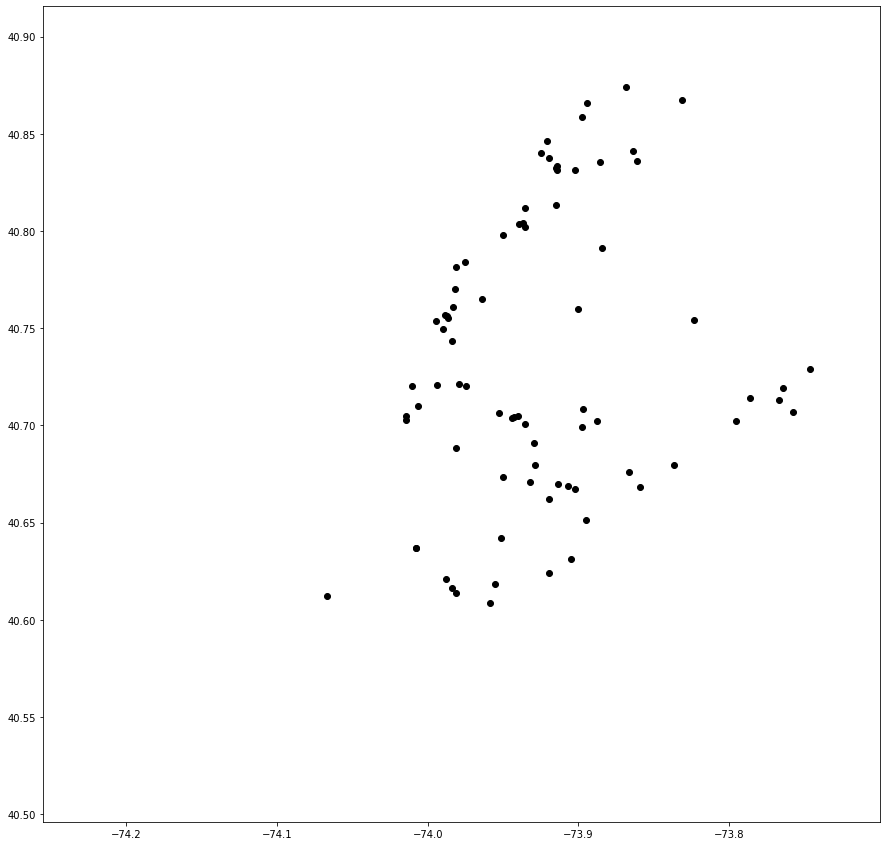

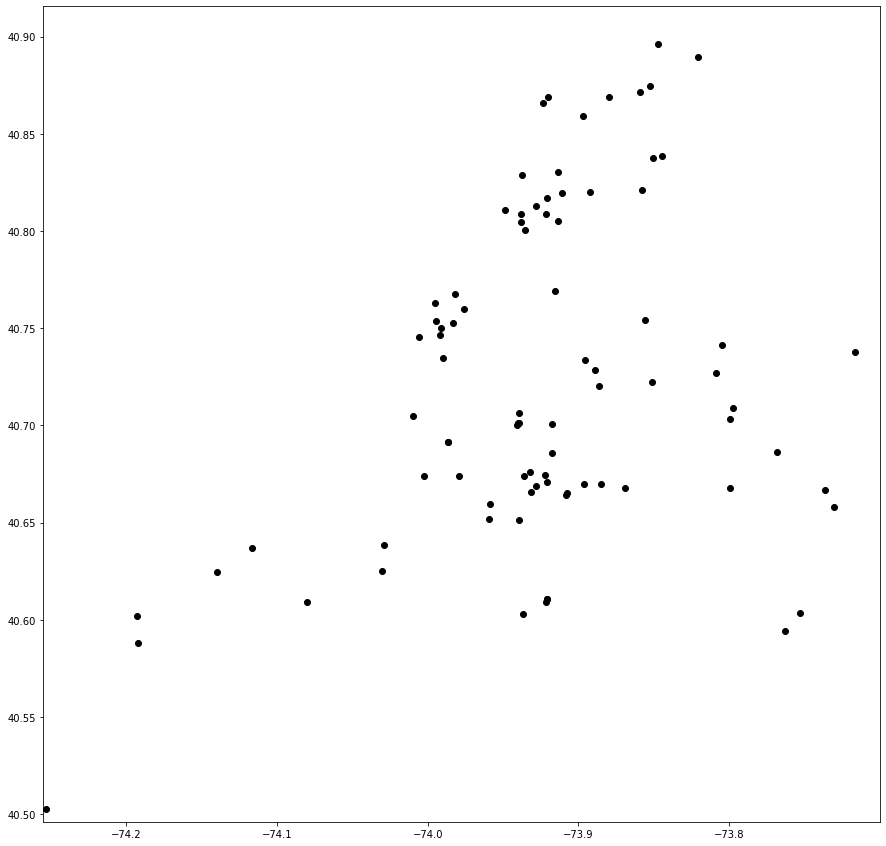

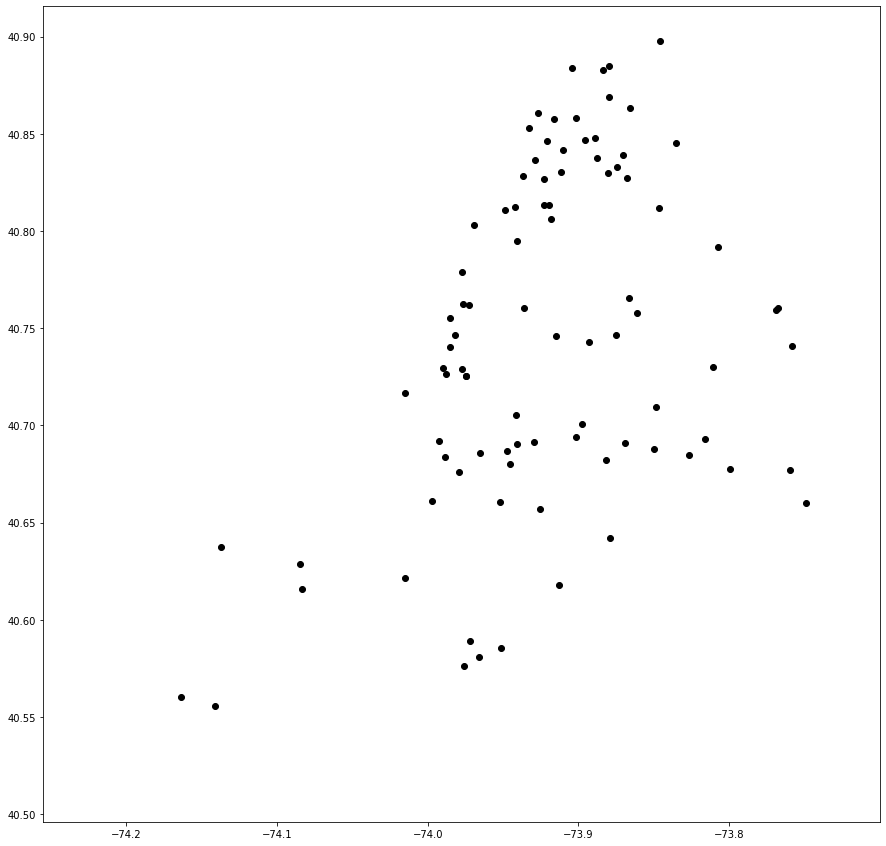

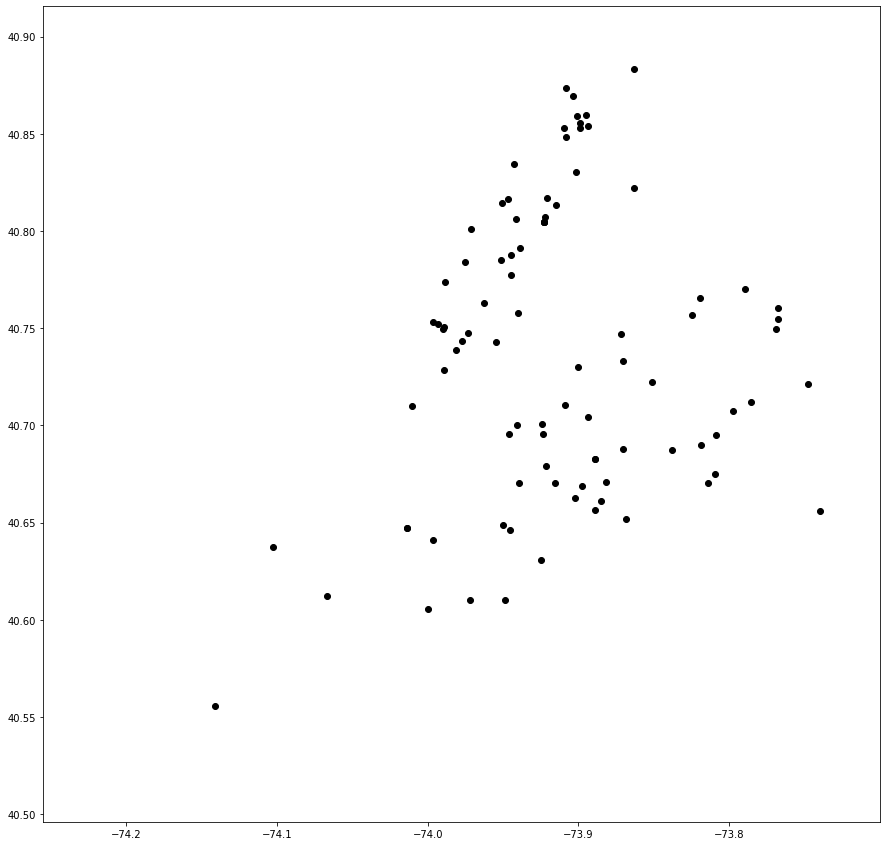

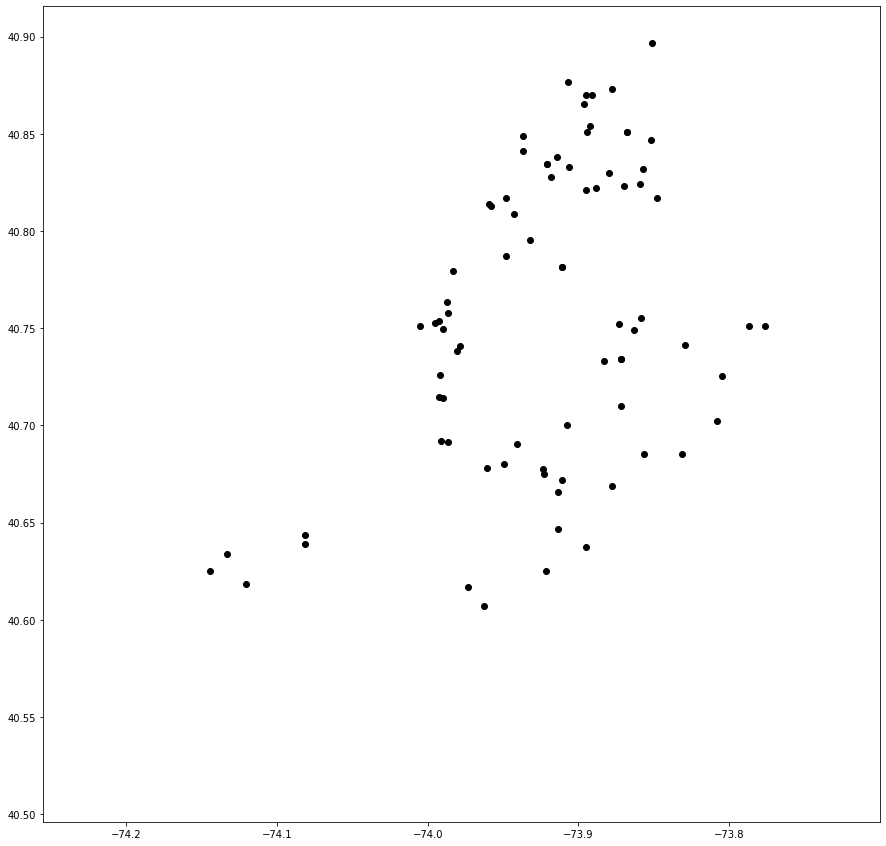

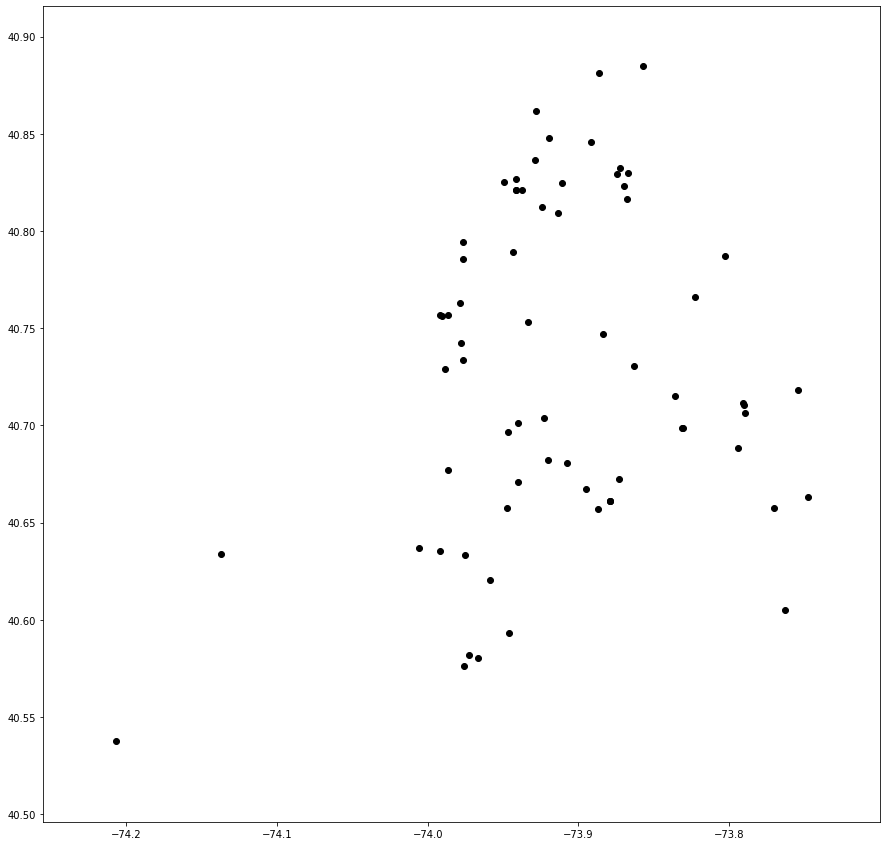

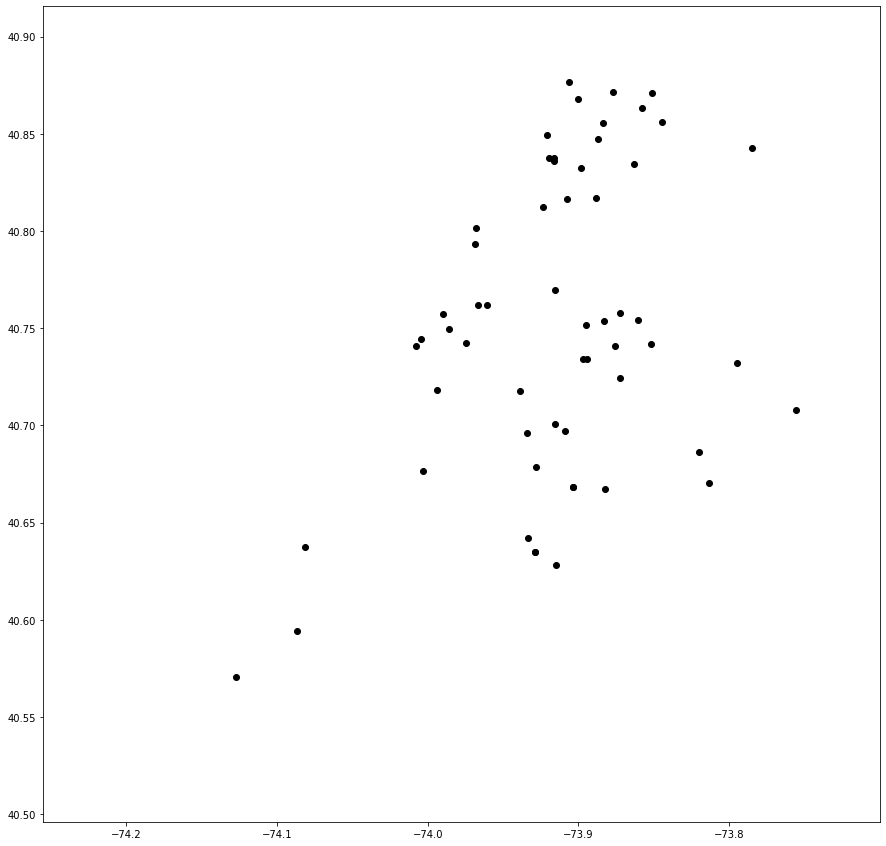

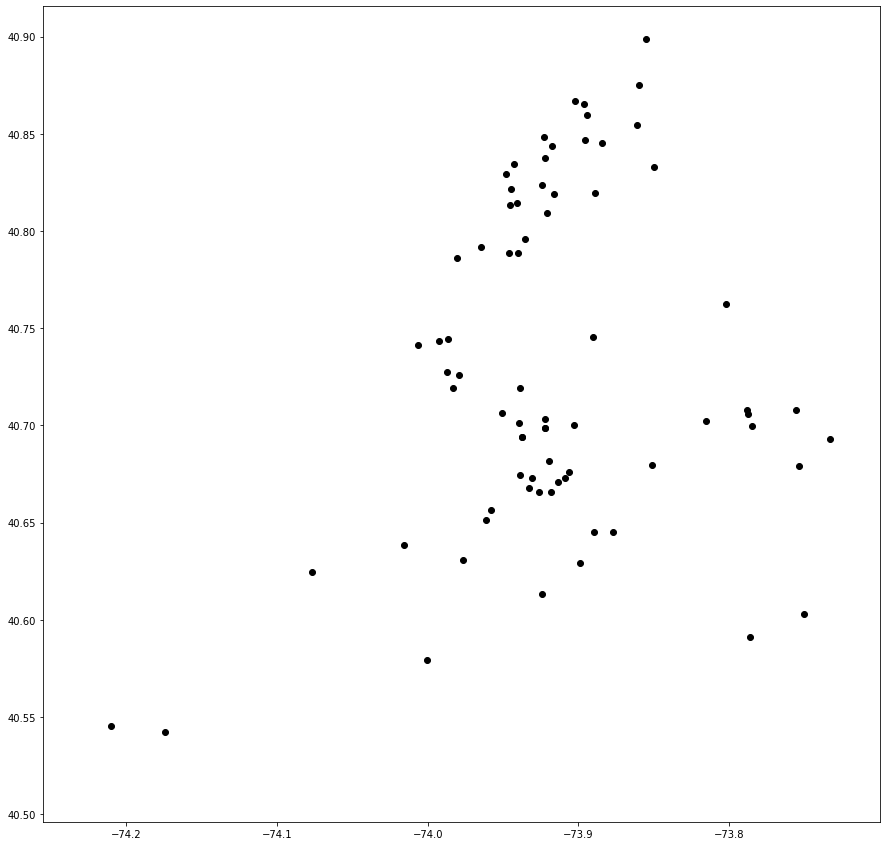

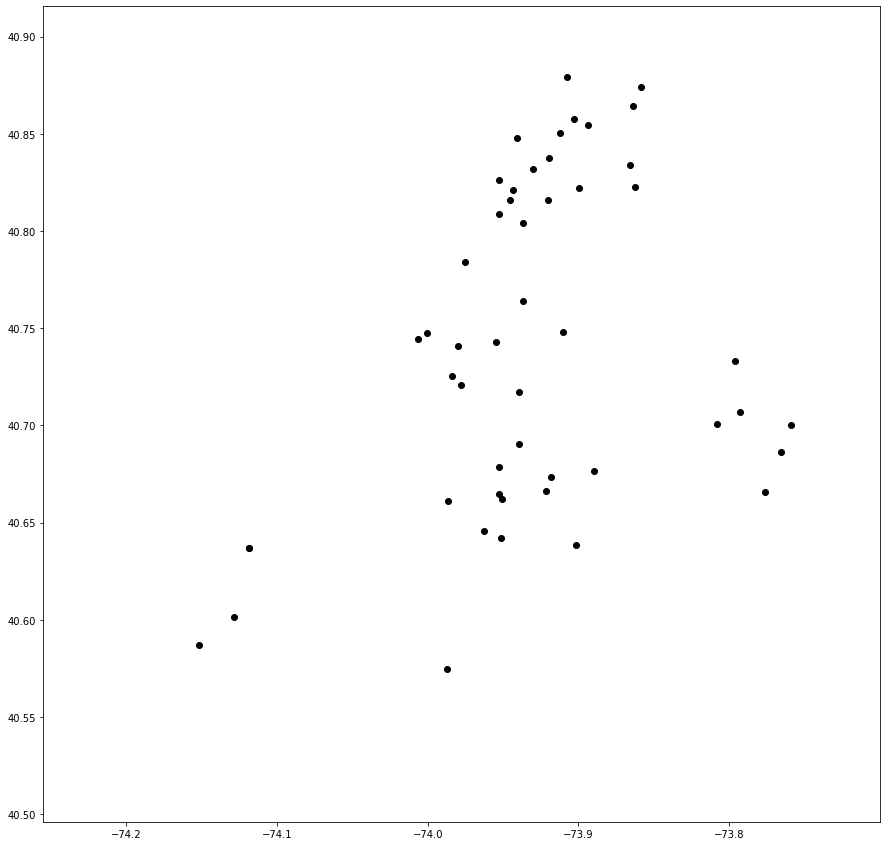

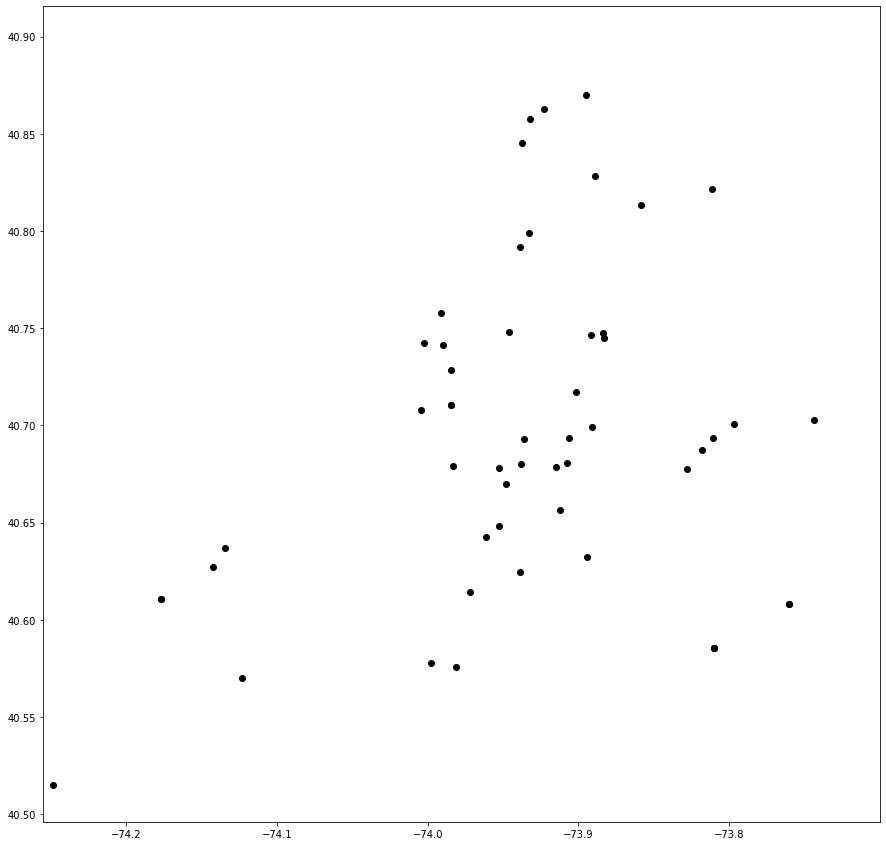

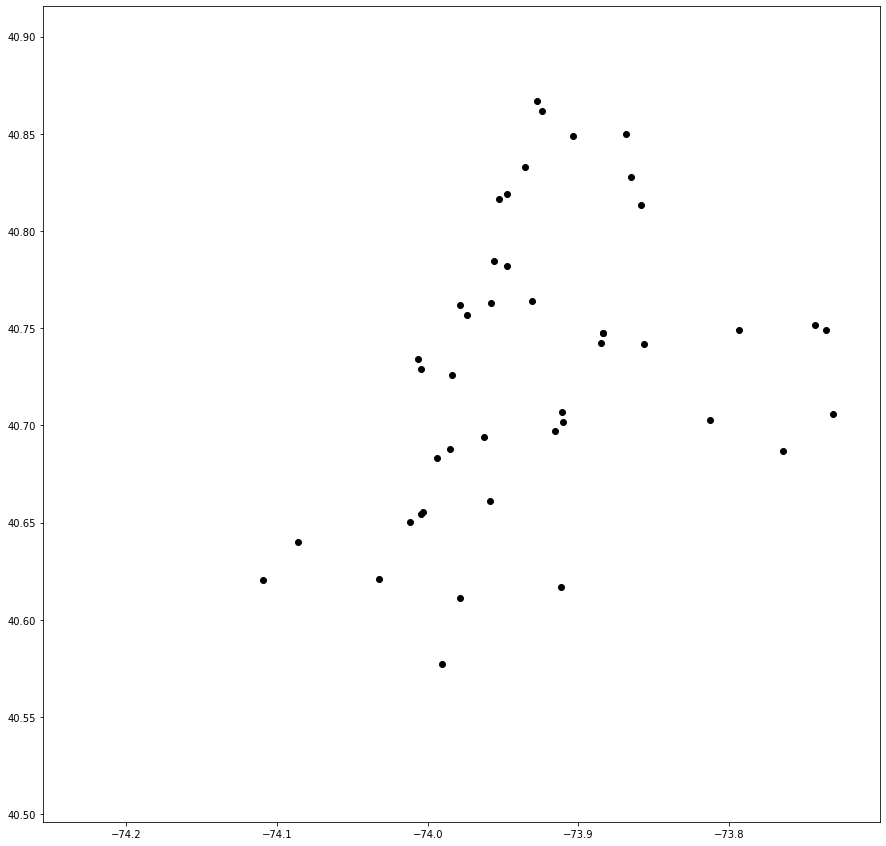

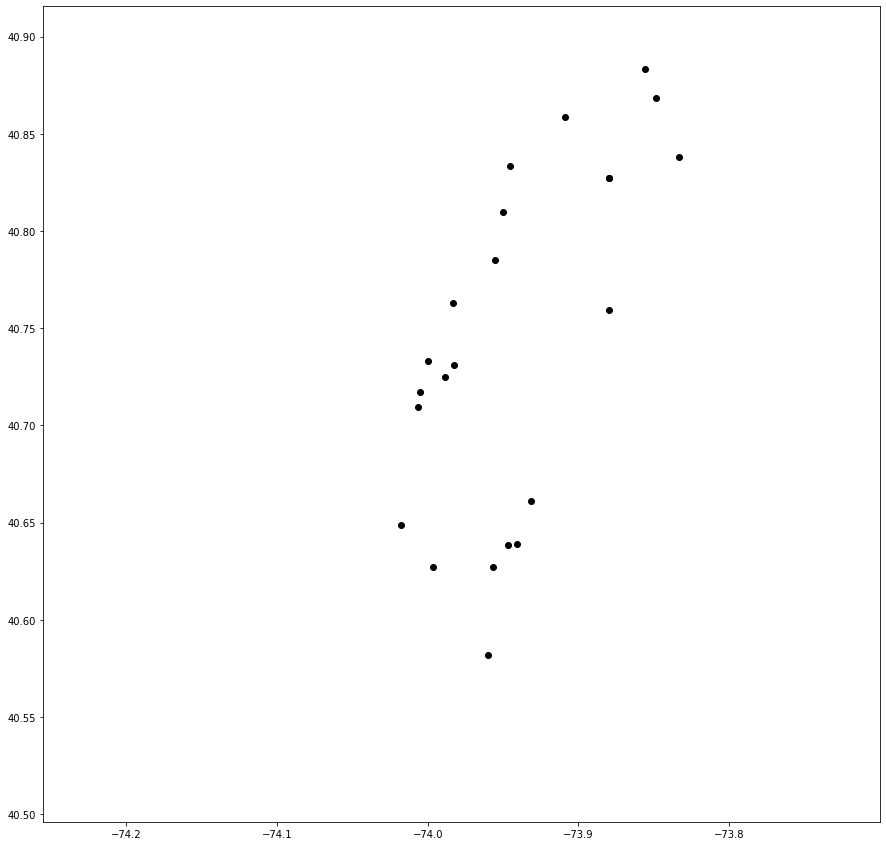

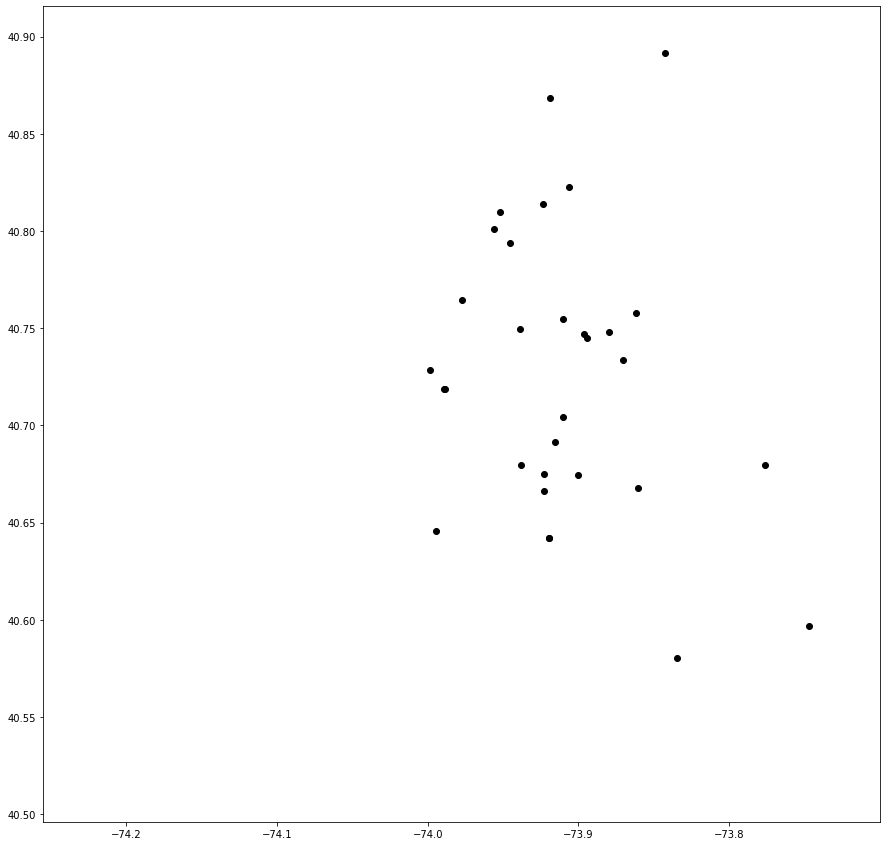

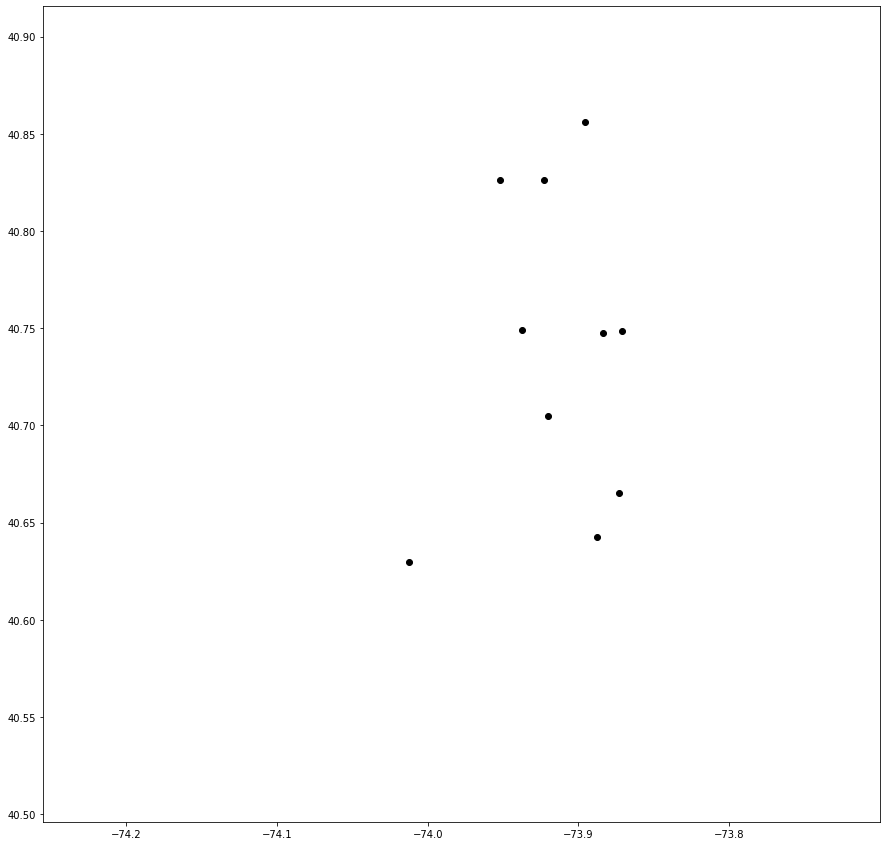

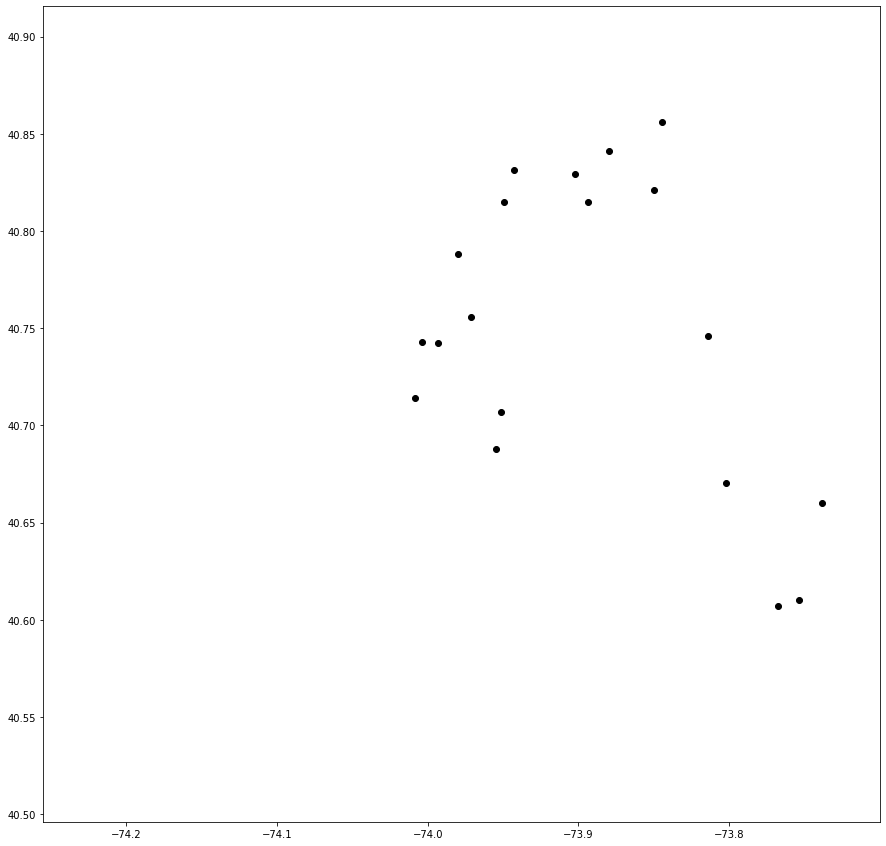

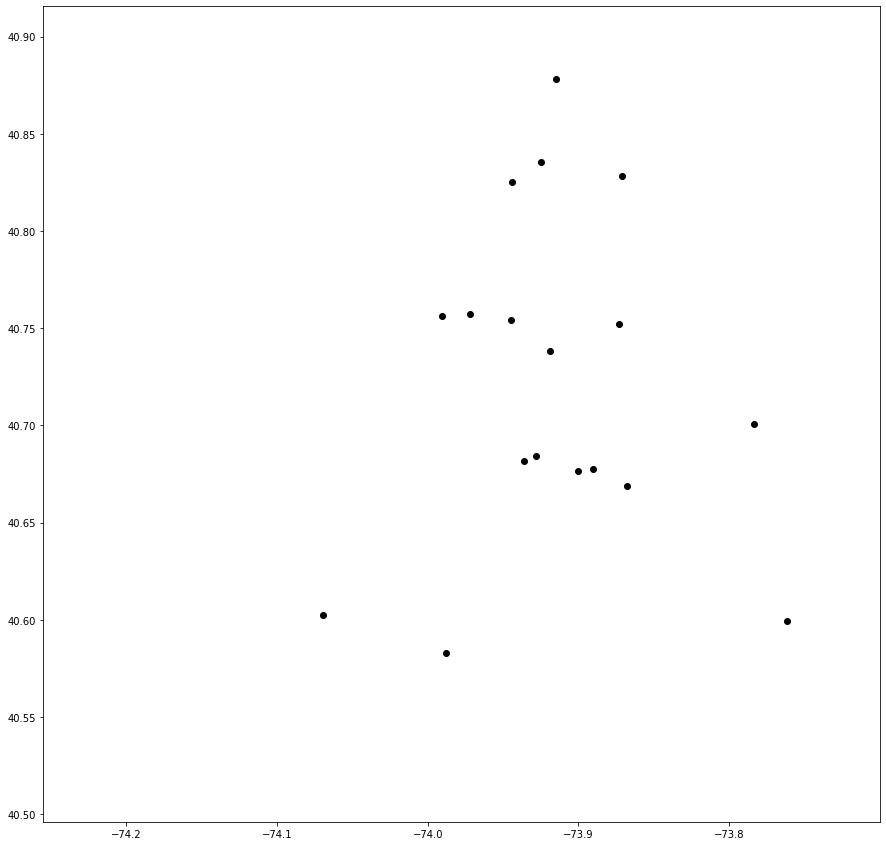

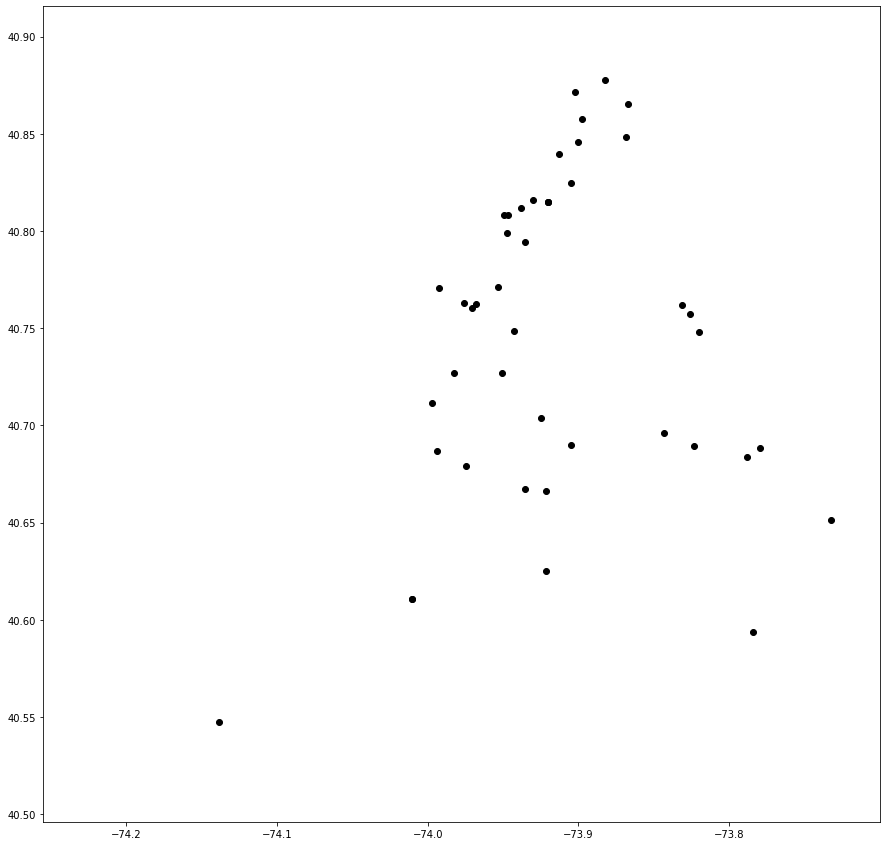

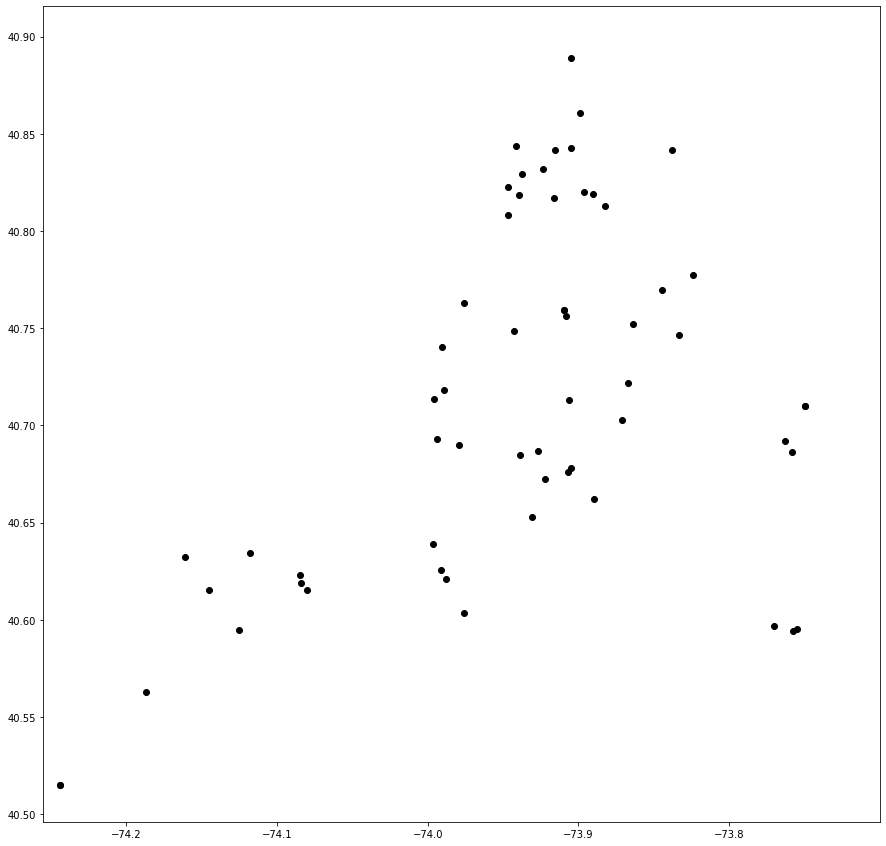

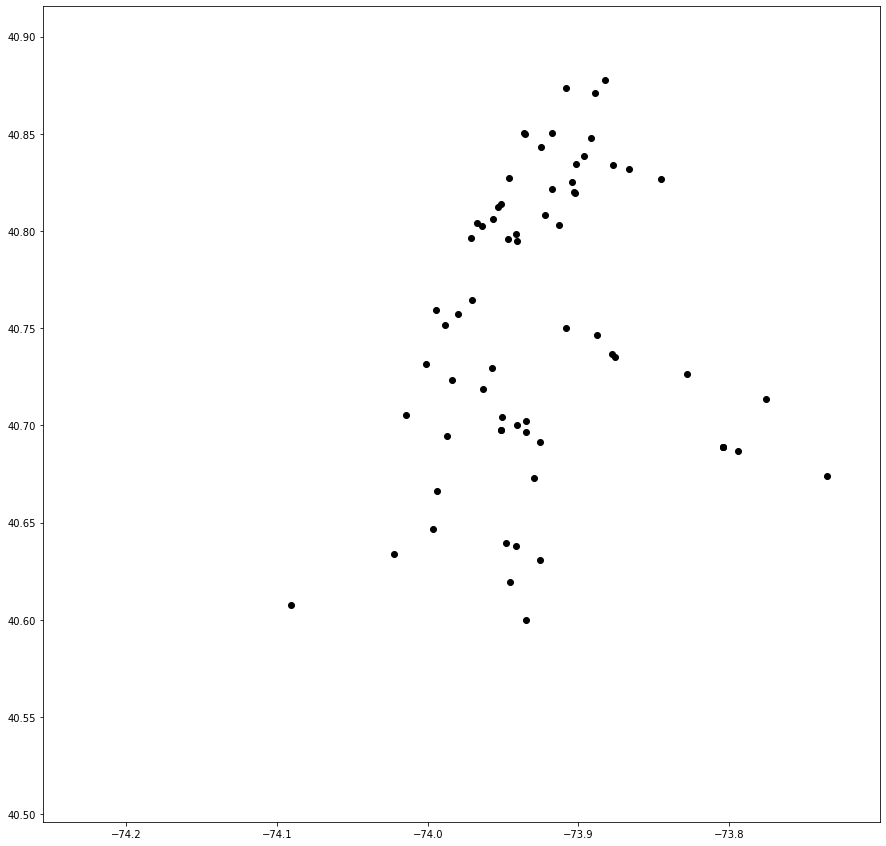

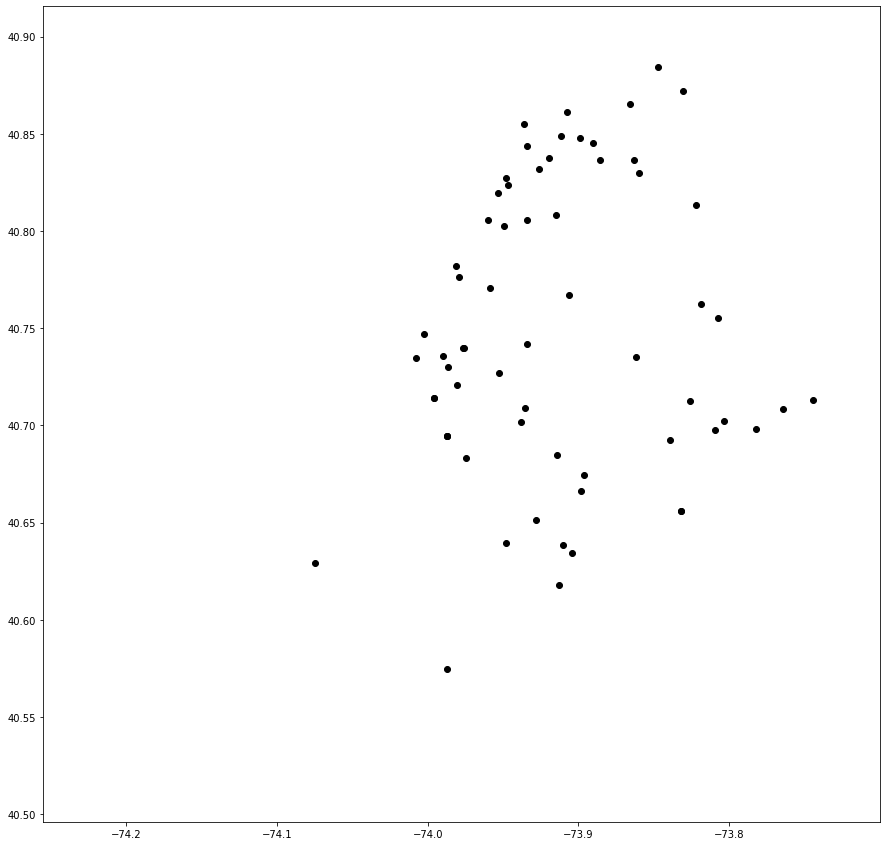

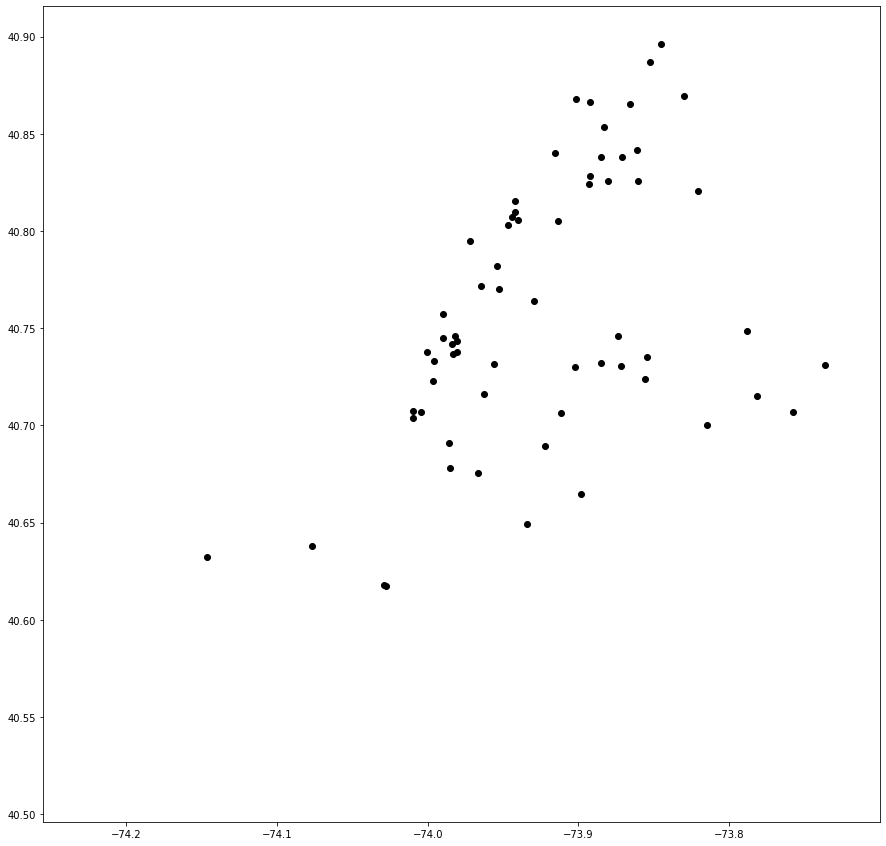

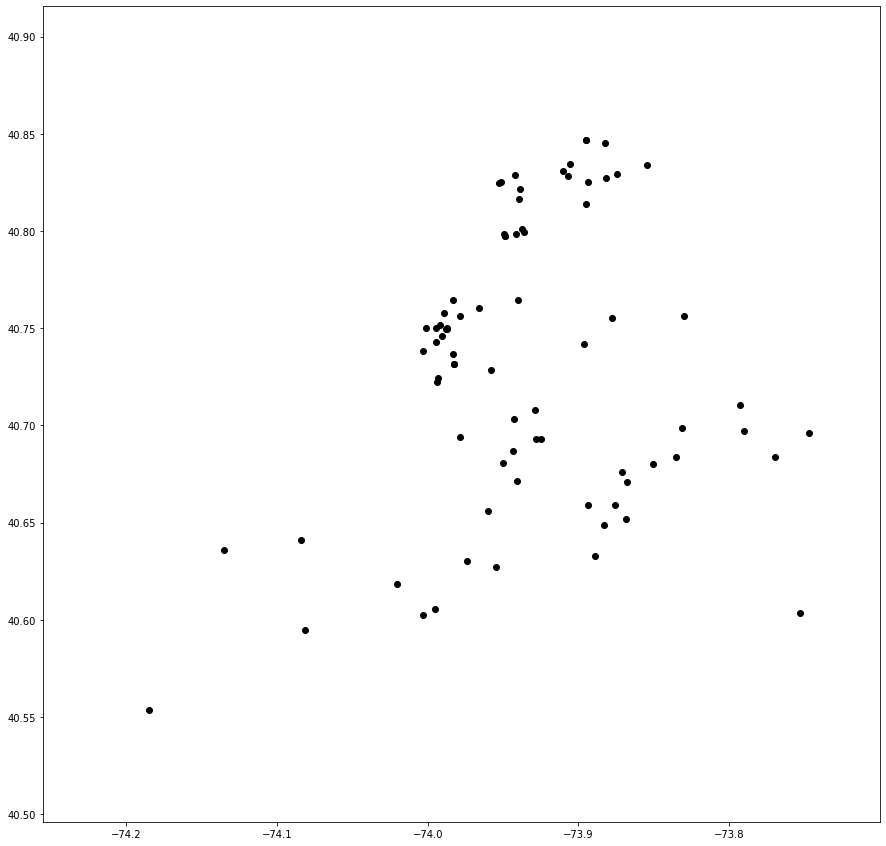

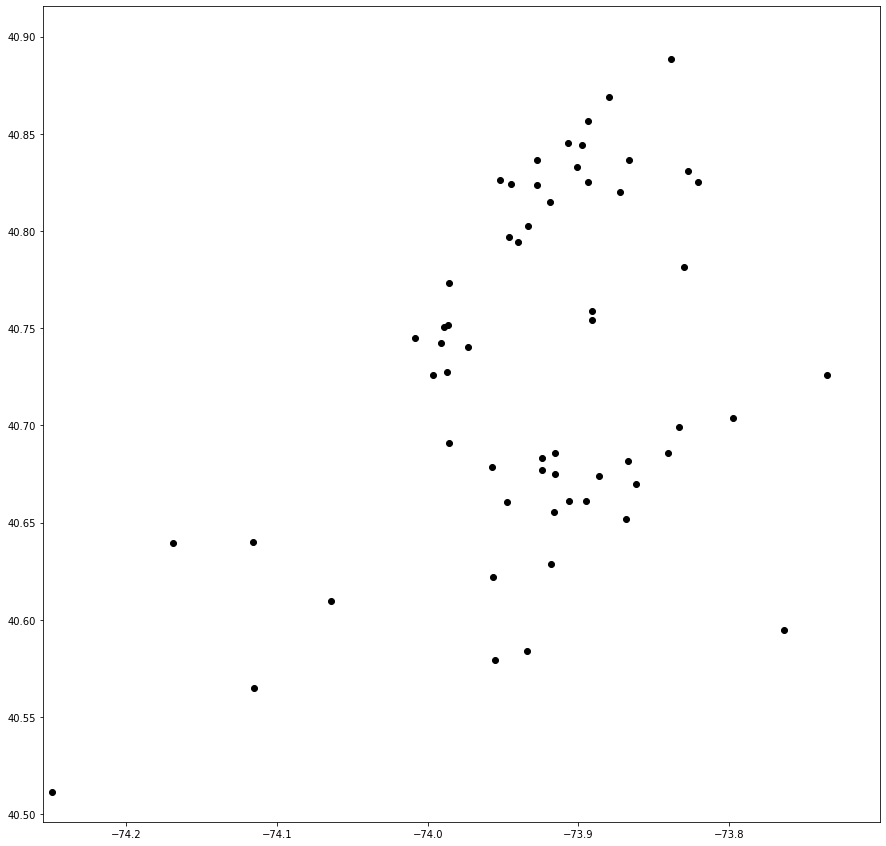

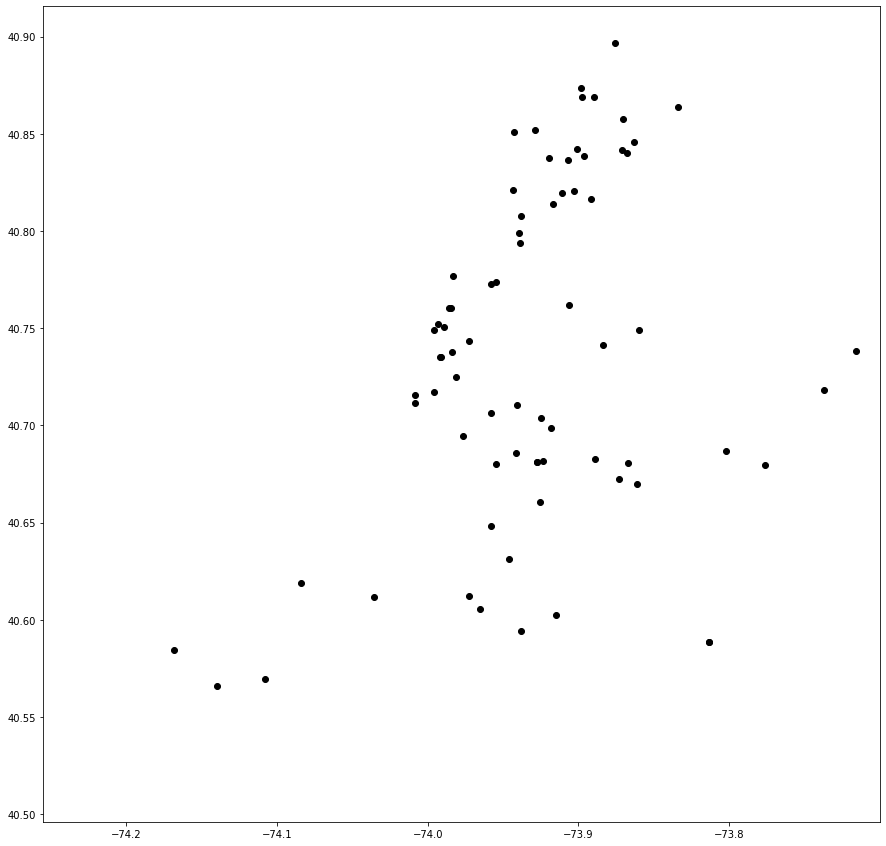

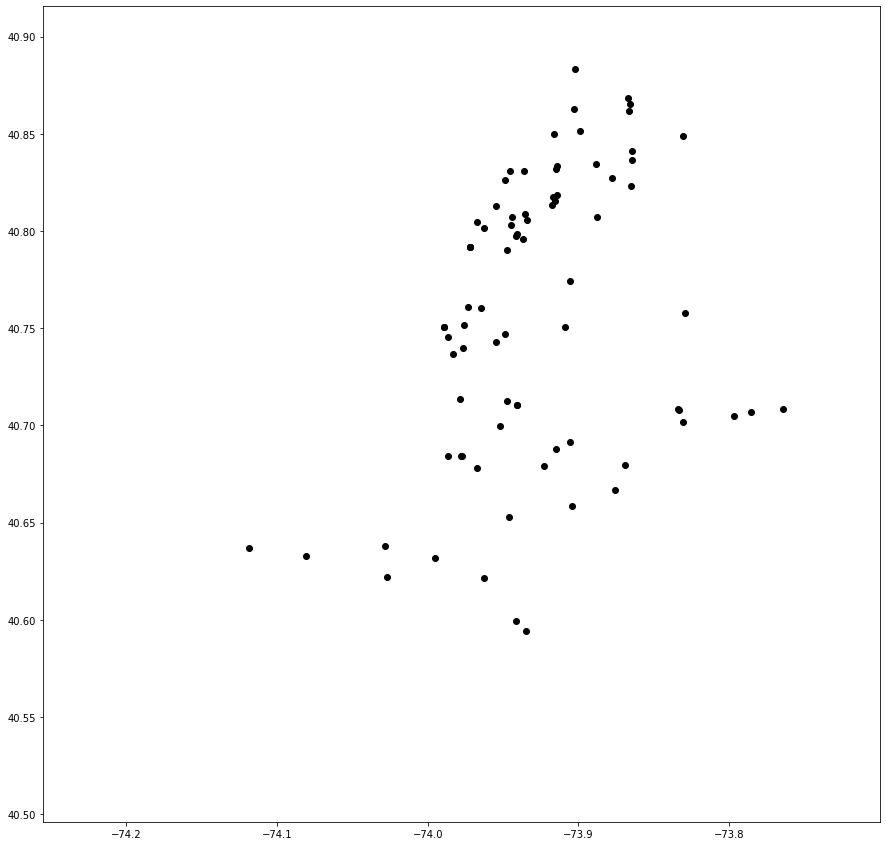

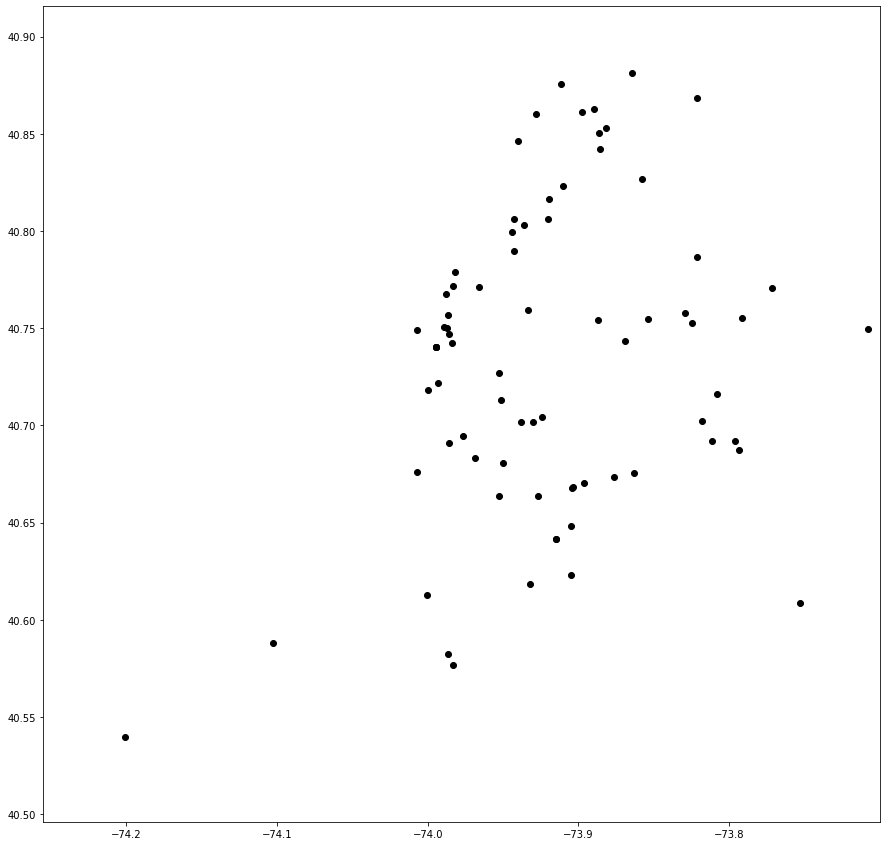

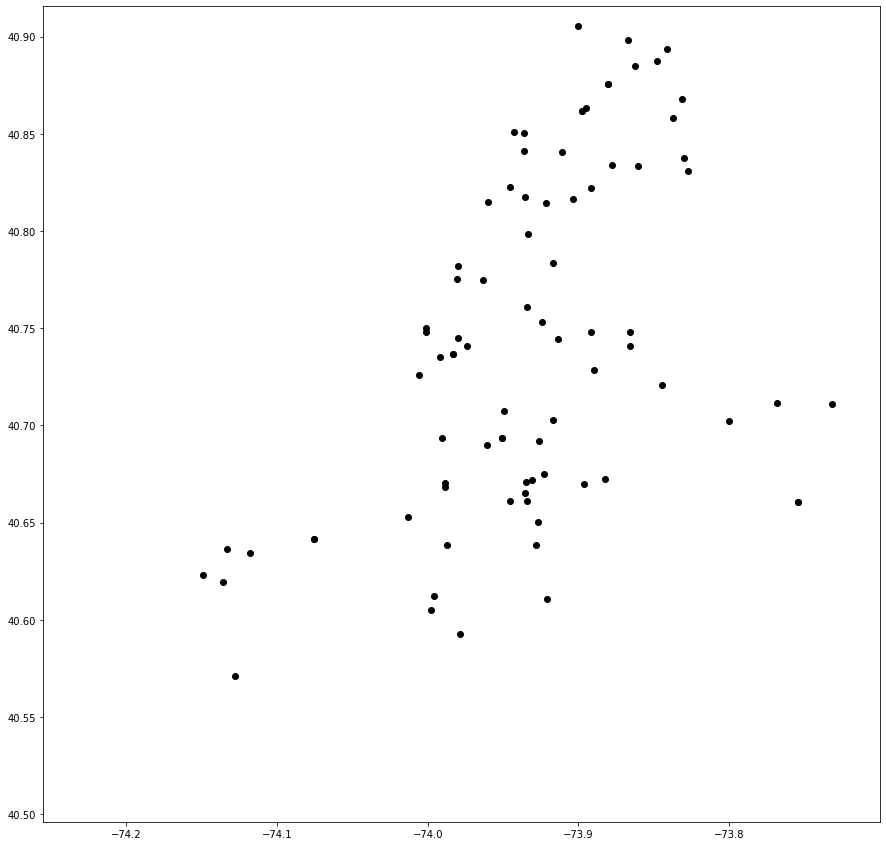

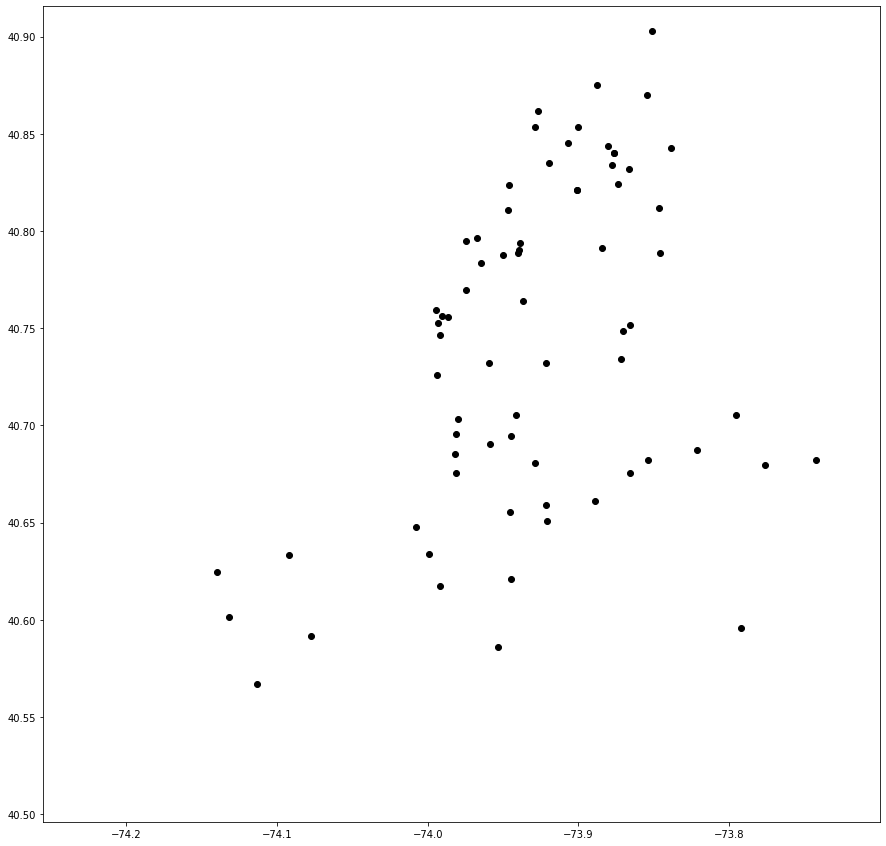

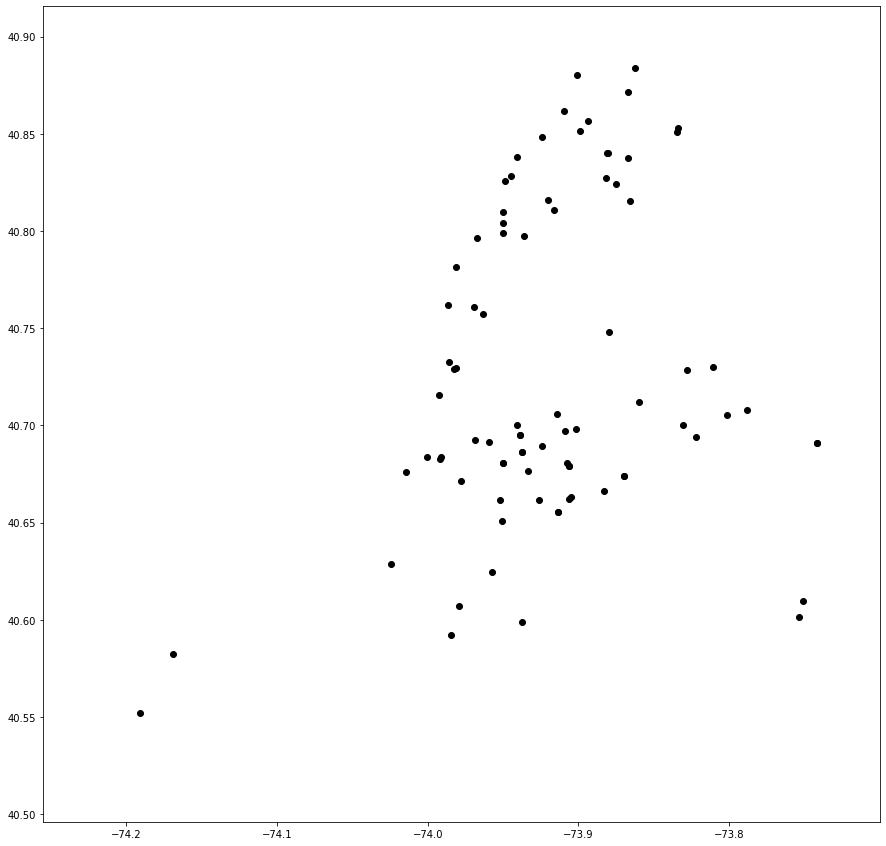

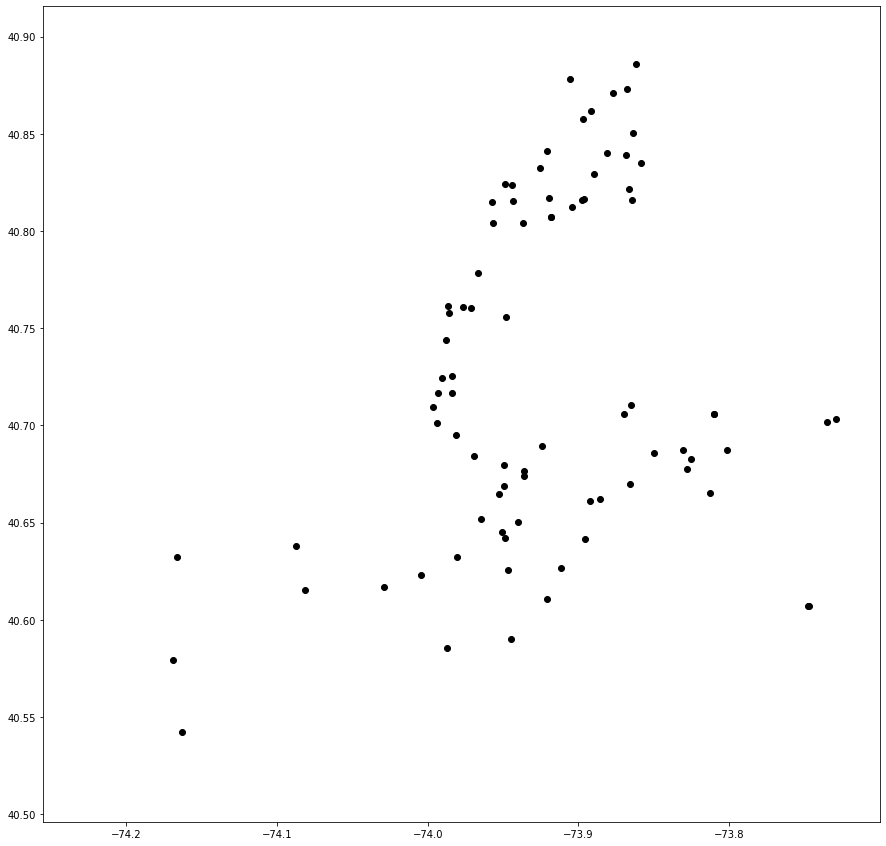

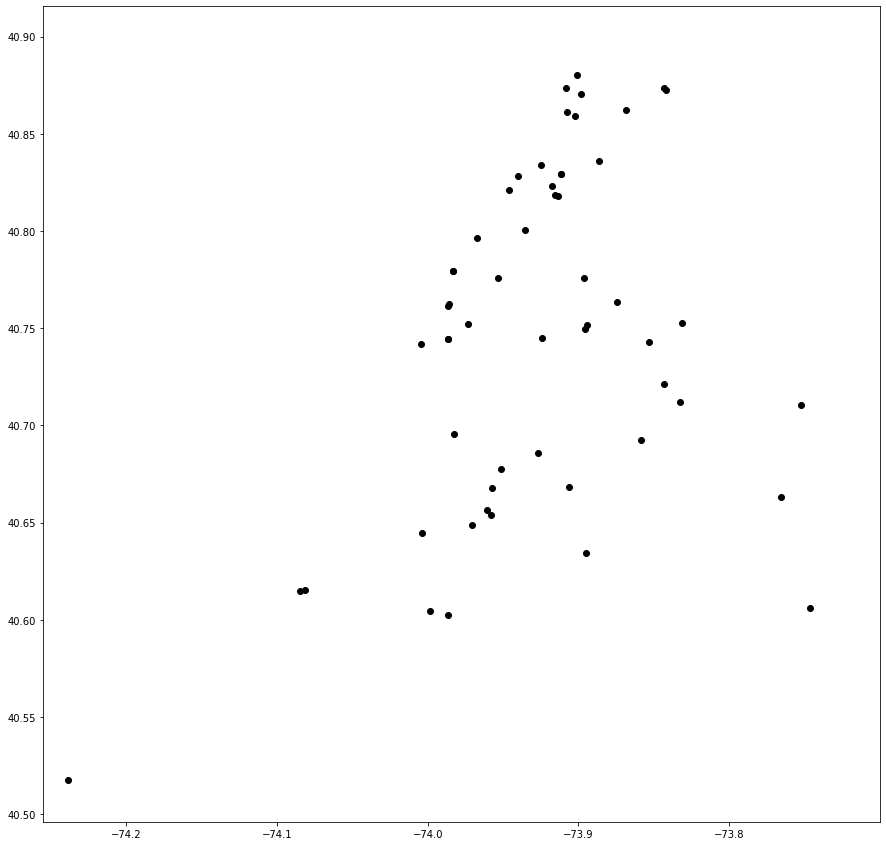

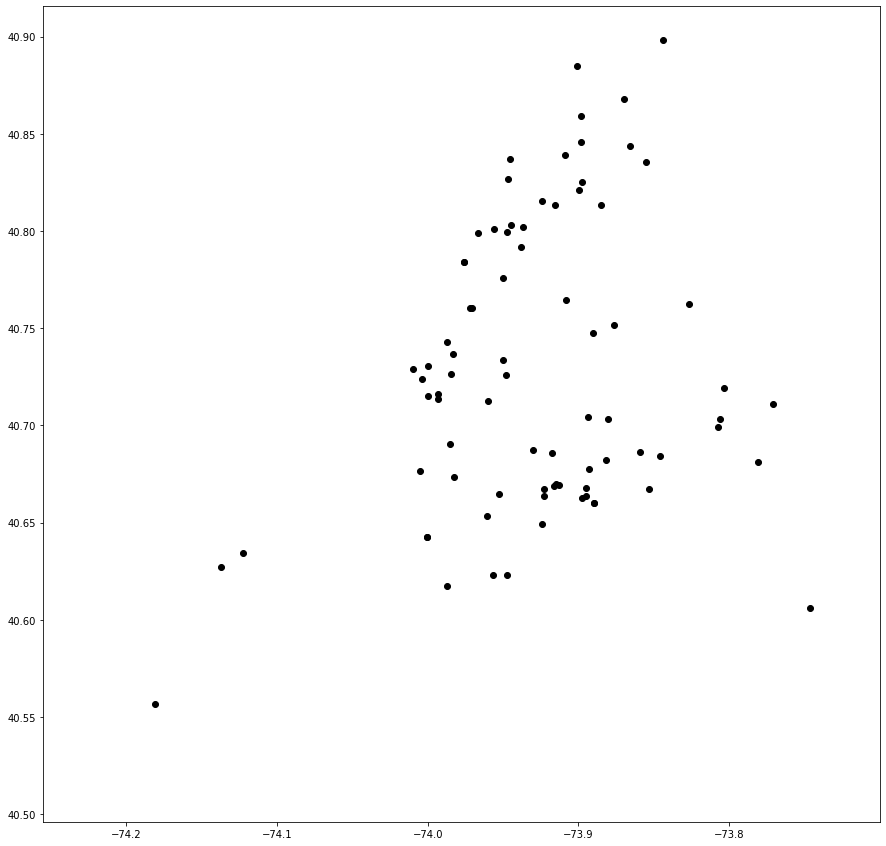

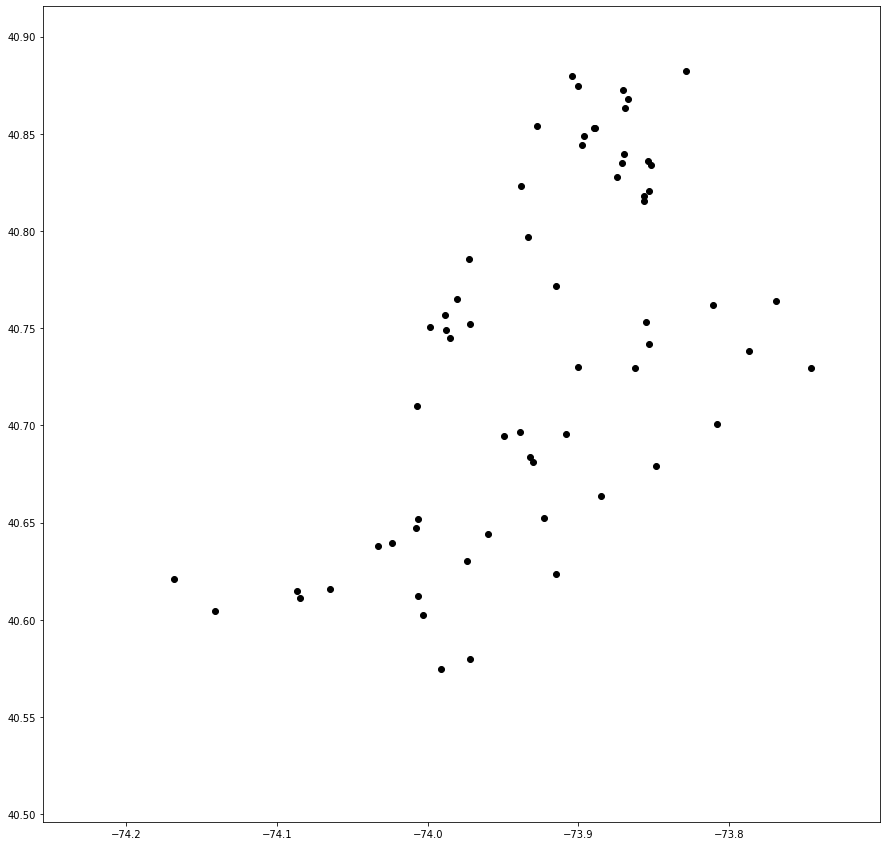

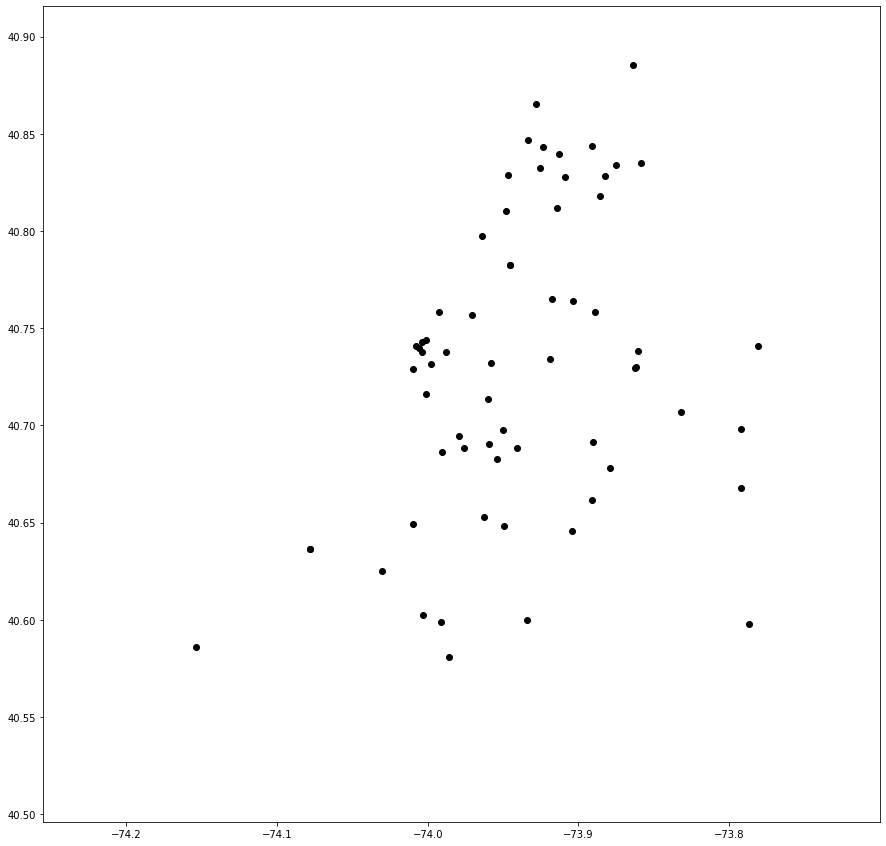

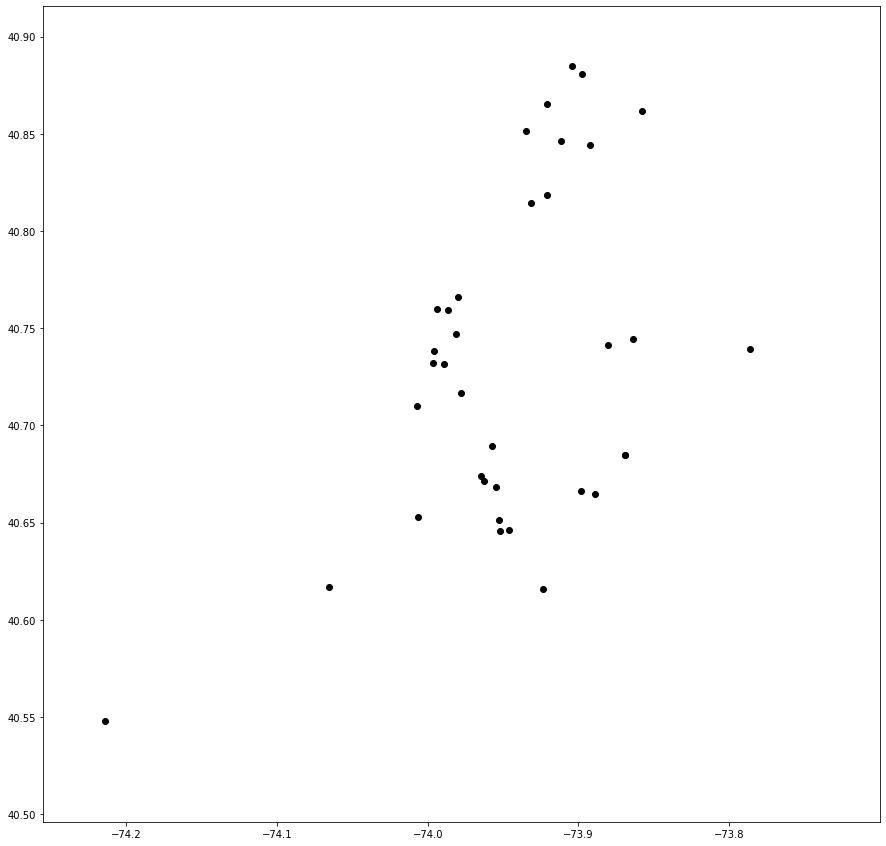

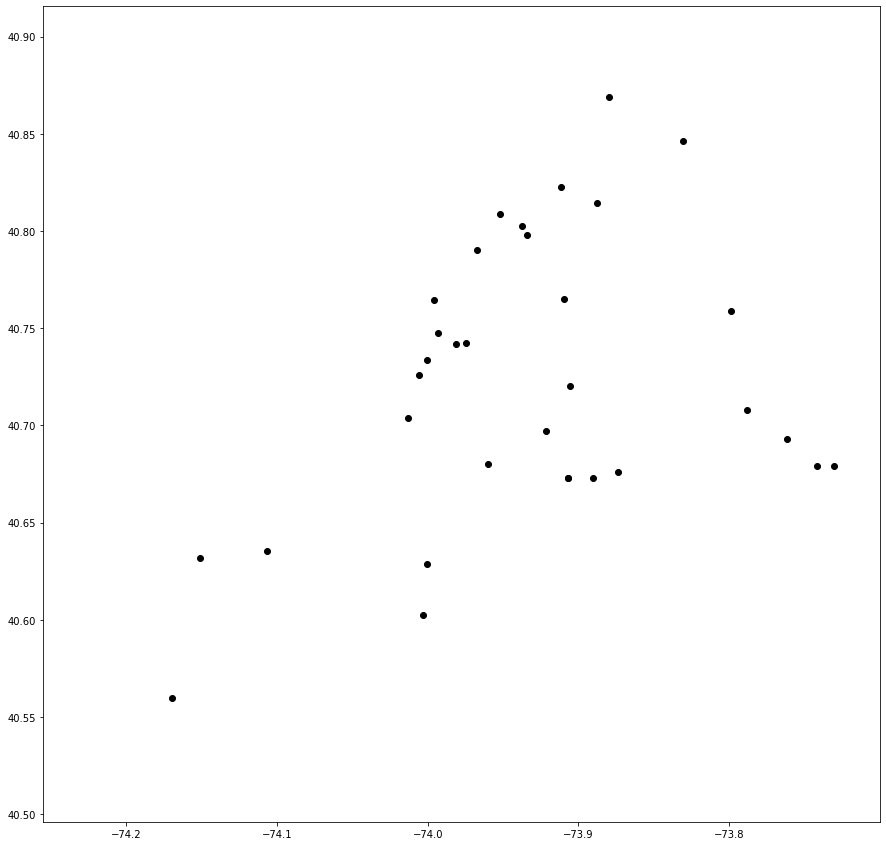

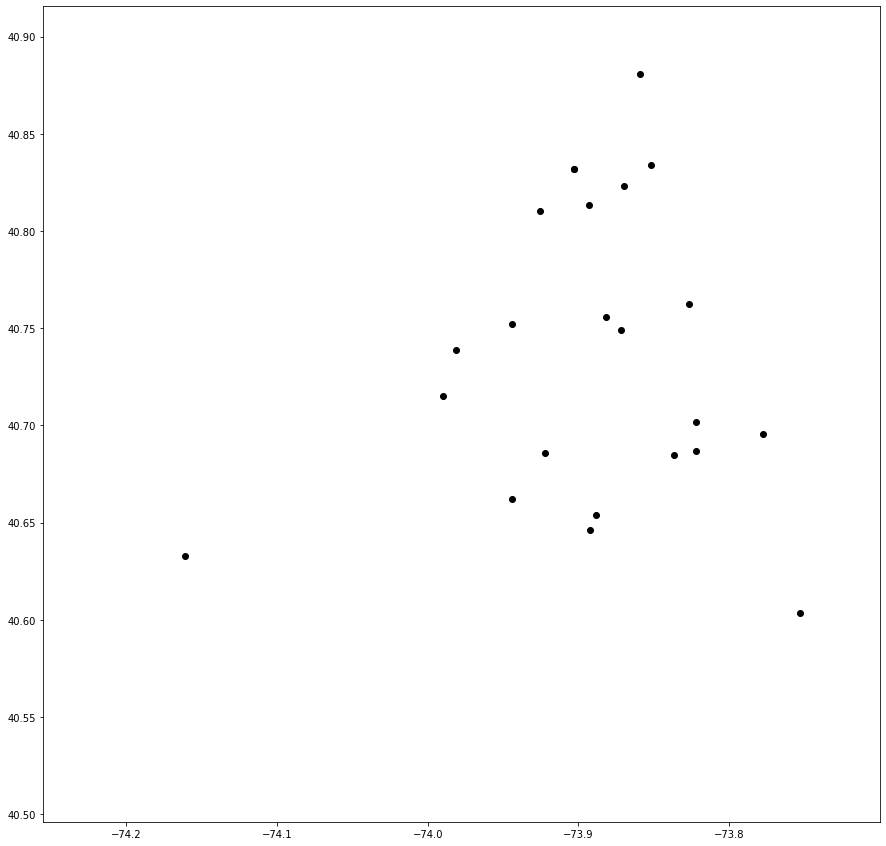

In [11]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [15,15]

img_list = []
for i in range (100):
    
    fig, ax = plt.subplots()
    ax.set_xlim(left=-74.25559136315213, right=-73.70000906387347)
    ax.set_ylim(bottom = 40.49611539518921, top=40.91553277600008)
    
    ax.scatter(lons[i], lats[i] , color='black')
    
    #save plot
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('../images/image.jpeg', bbox_inches=extent)
    
    #read plot as np.array
    img = io.imread('../images/image.jpeg')
    grayscale = color.rgb2gray(img)
    
    # add np.array to list
    img_list.append(grayscale)
img_list = np.array(img_list)

In [12]:
img_list.shape

(100, 815, 837)

# Go through gaussian filter

In [13]:
img3D_conv = gaussian_filter(img_list, sigma=(2,2,2))

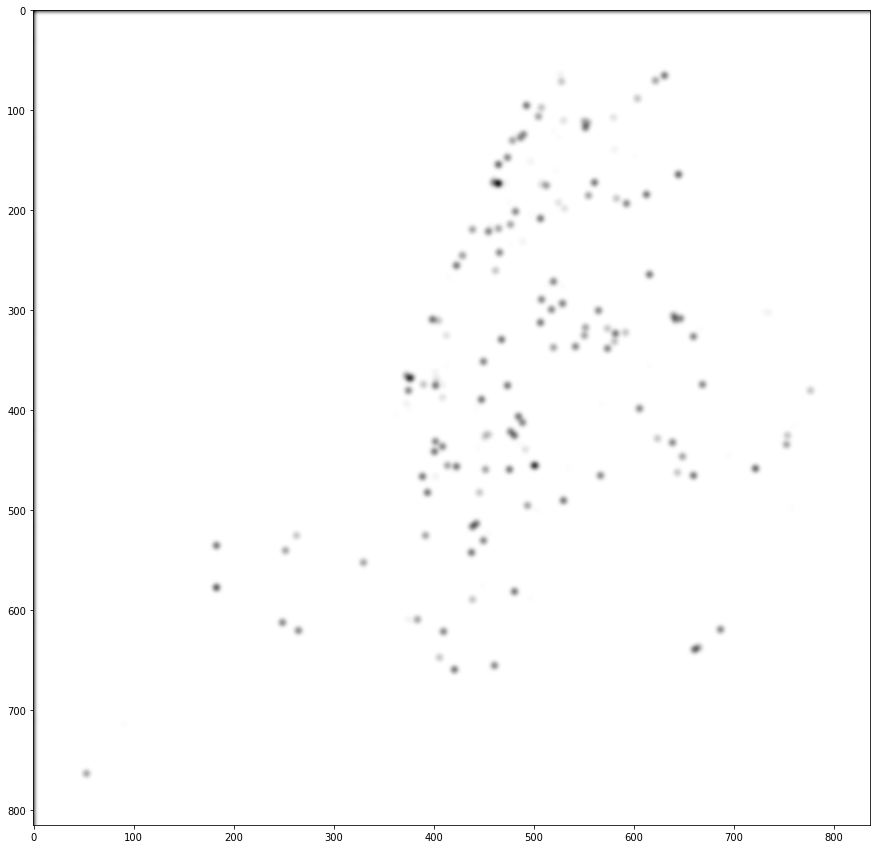

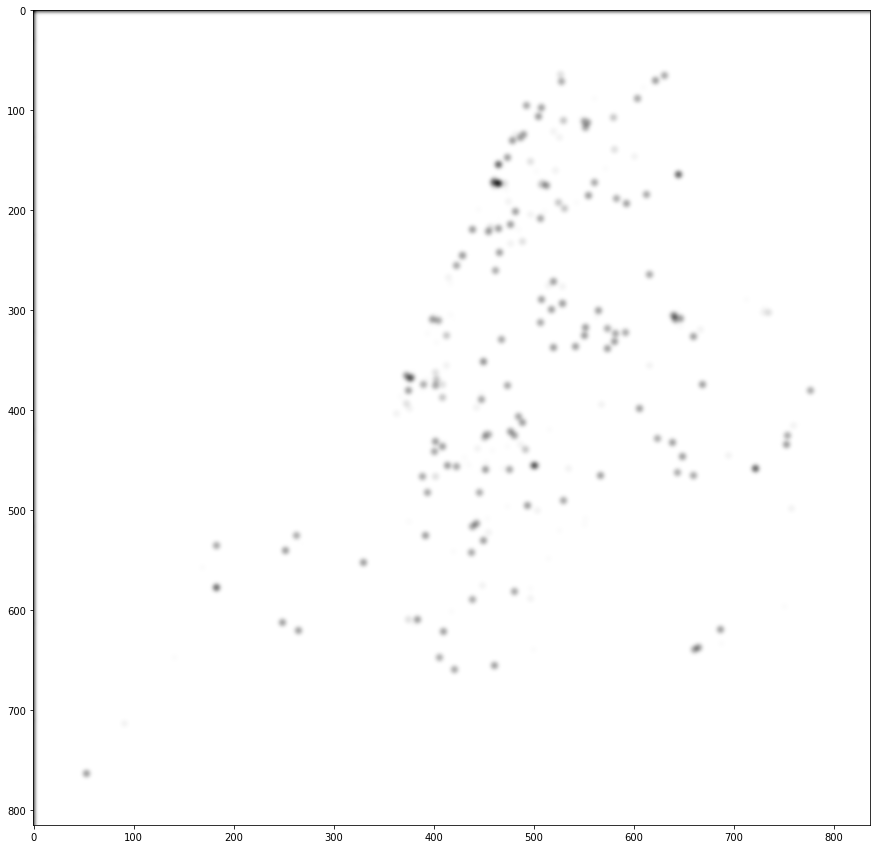

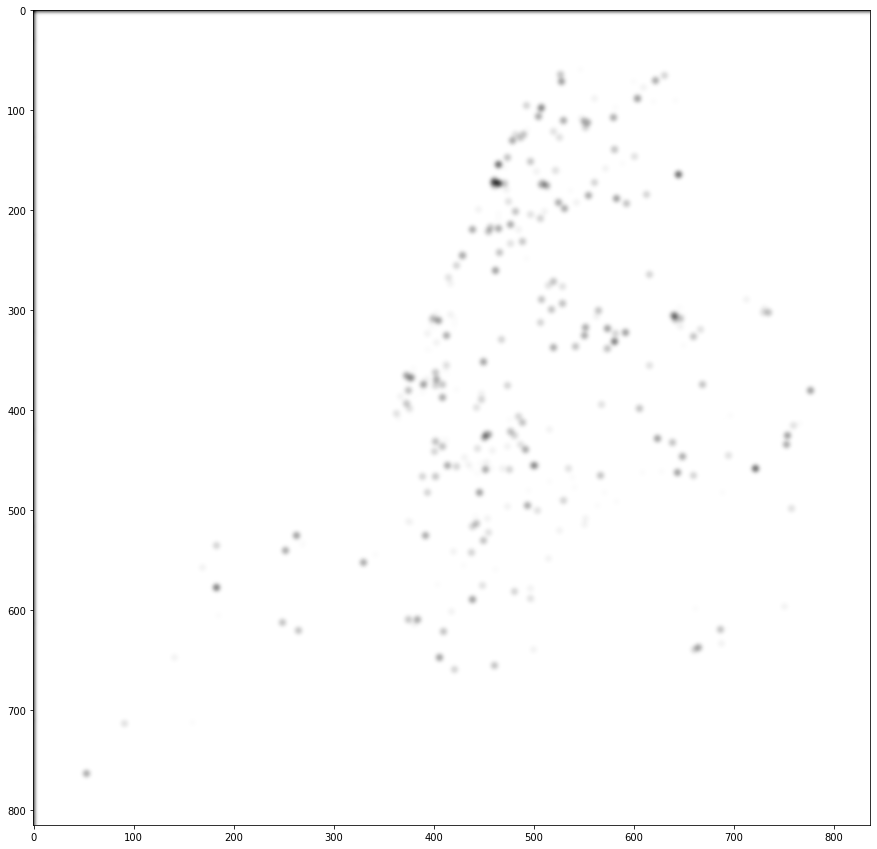

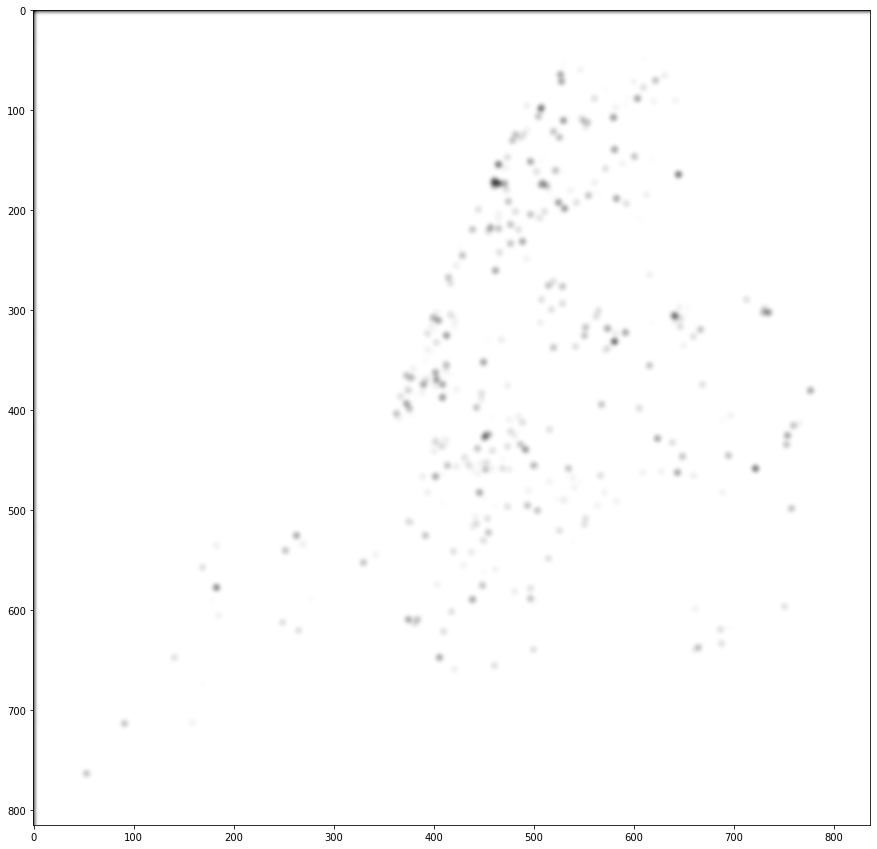

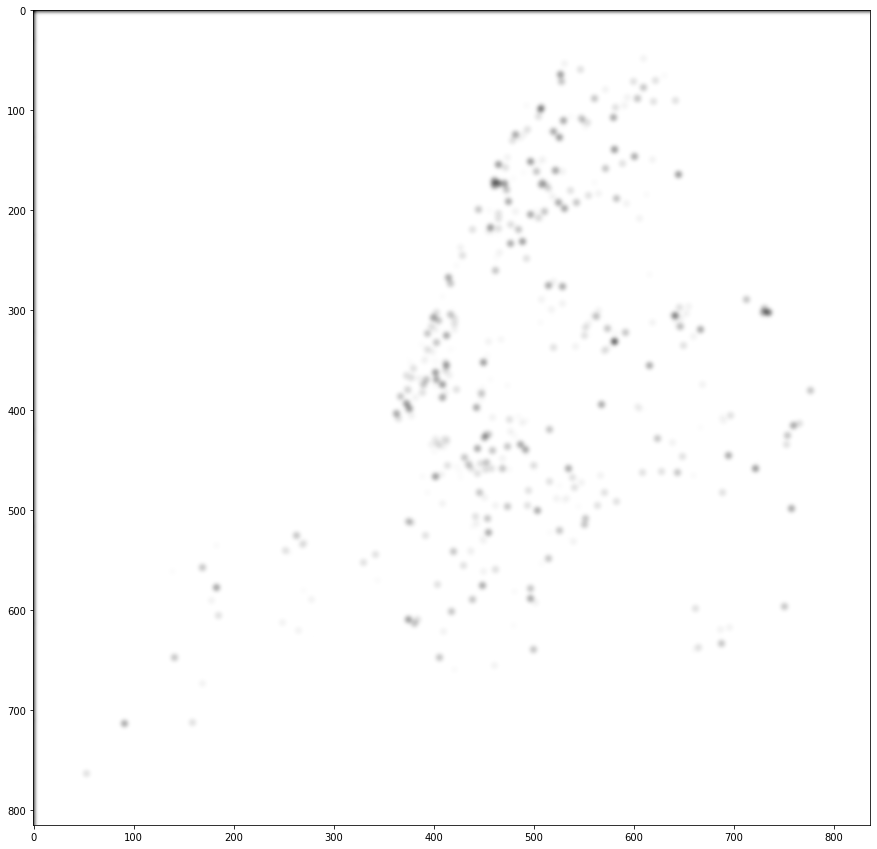

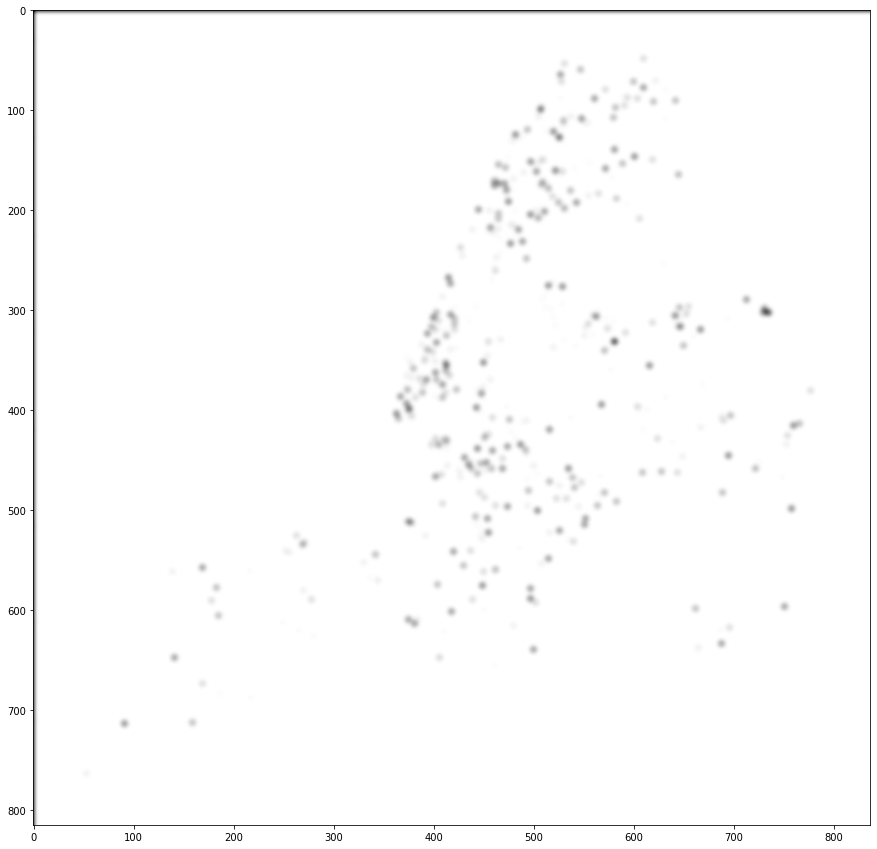

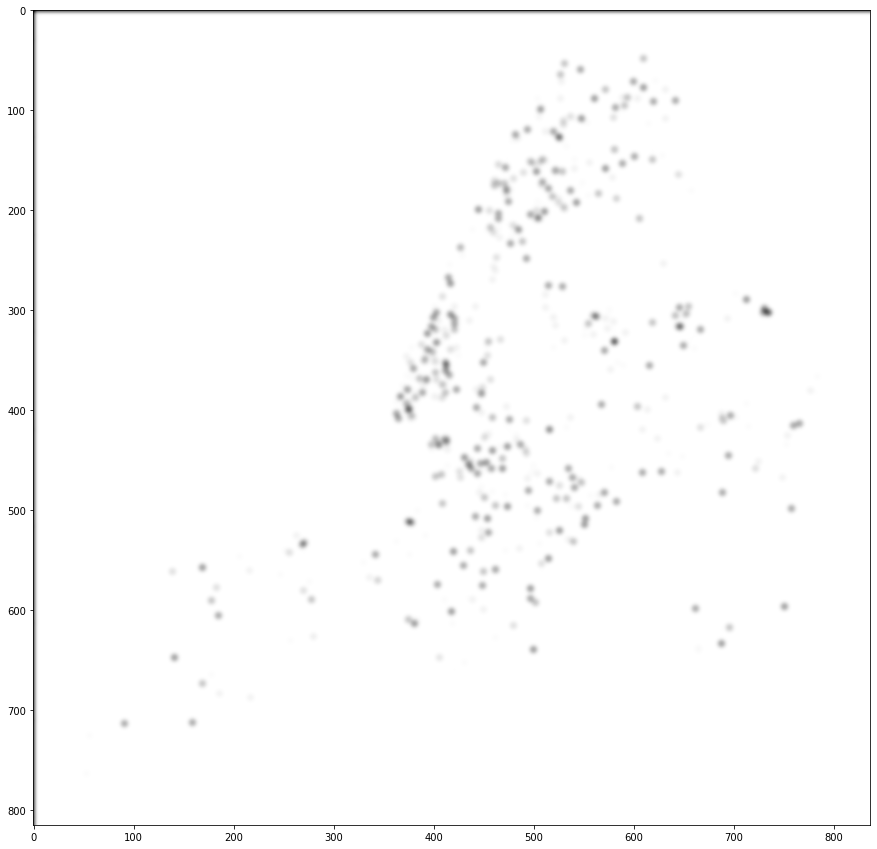

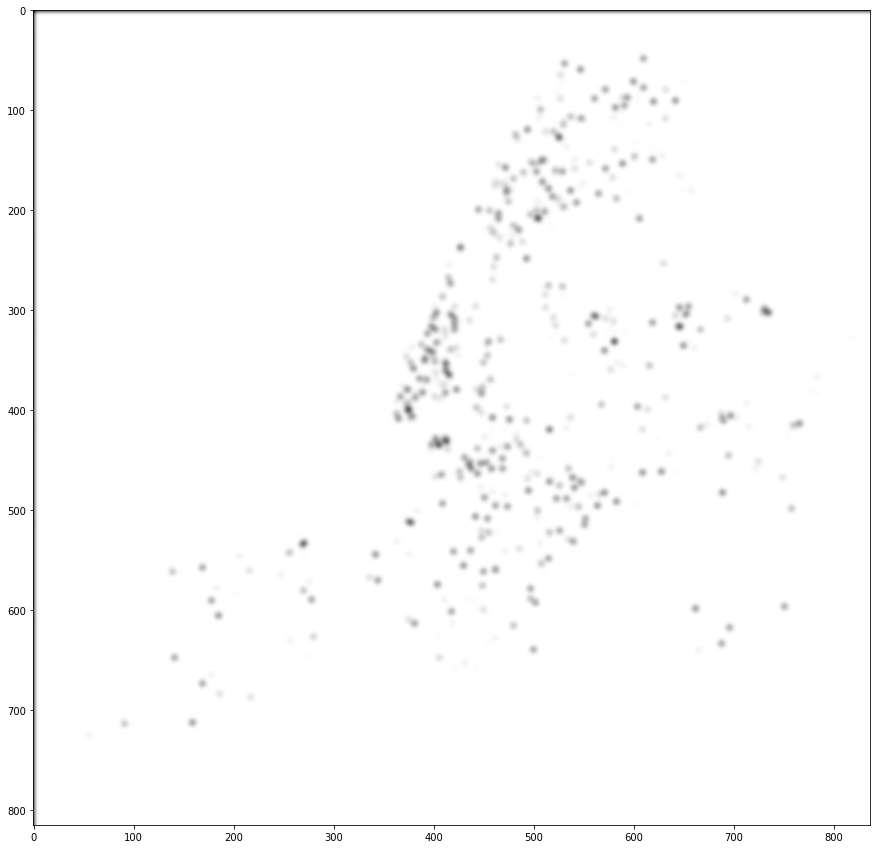

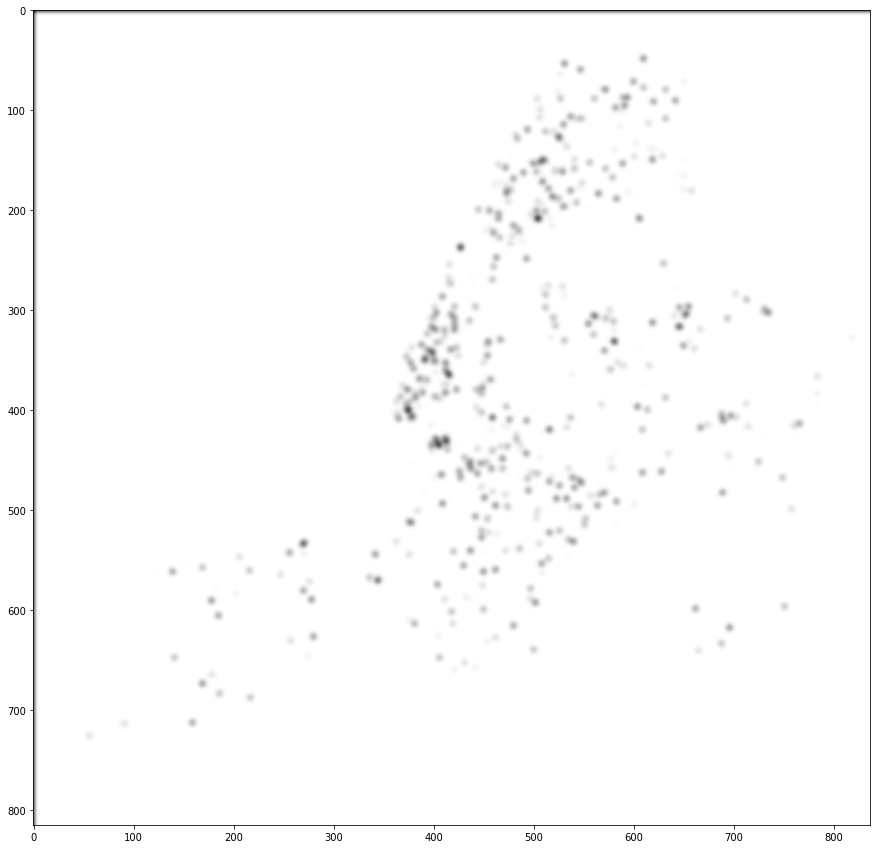

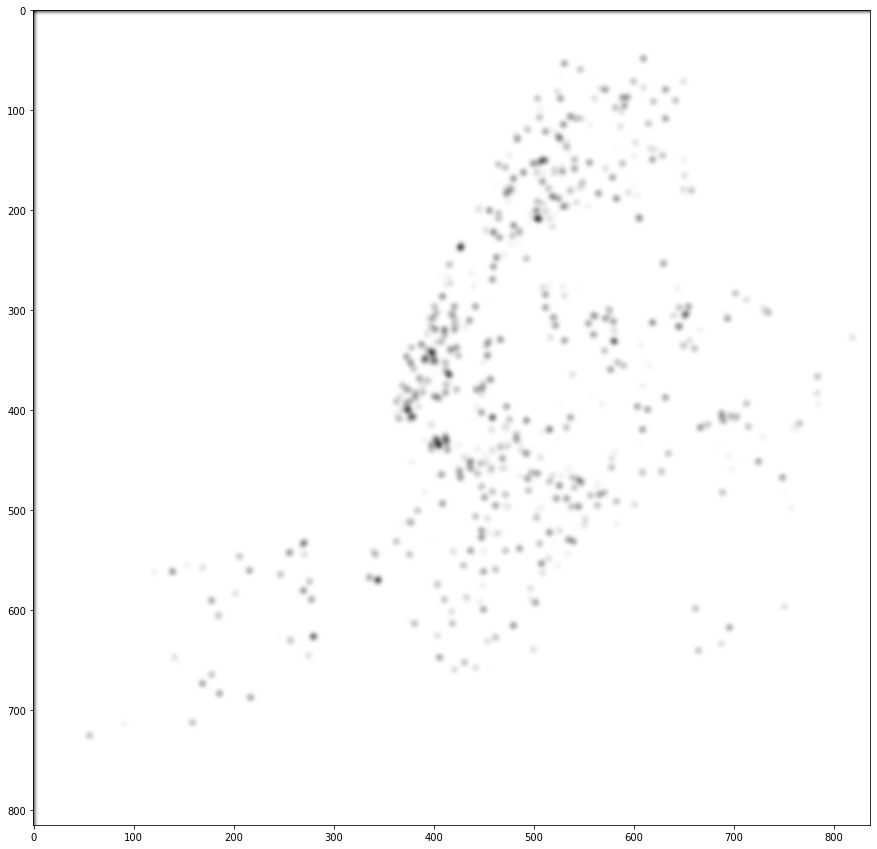

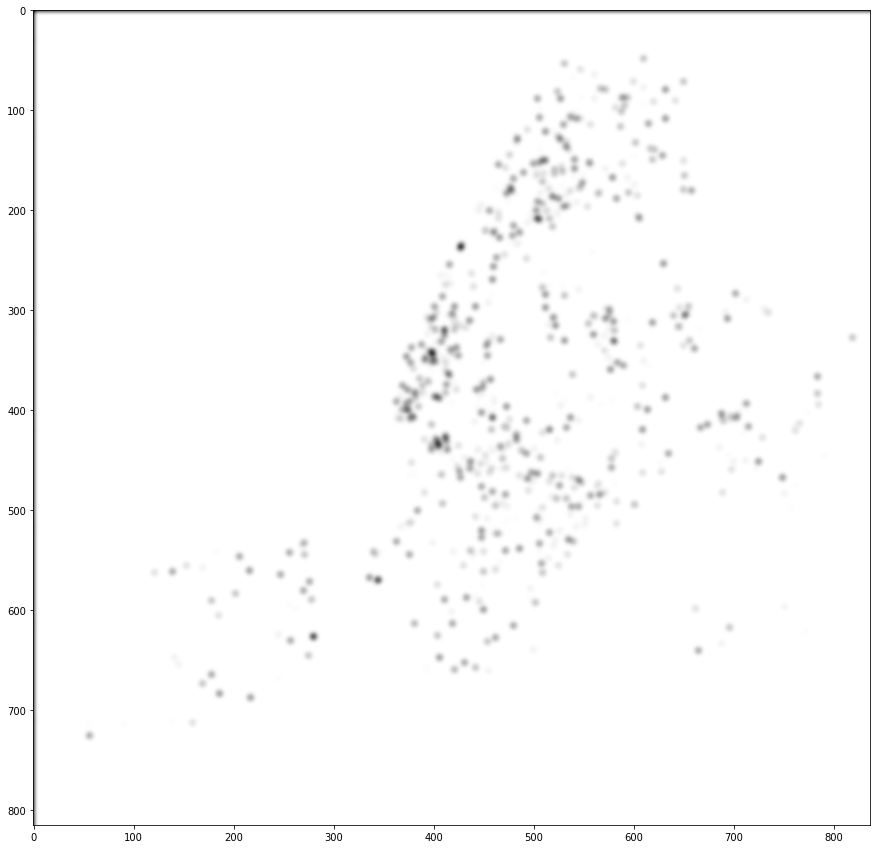

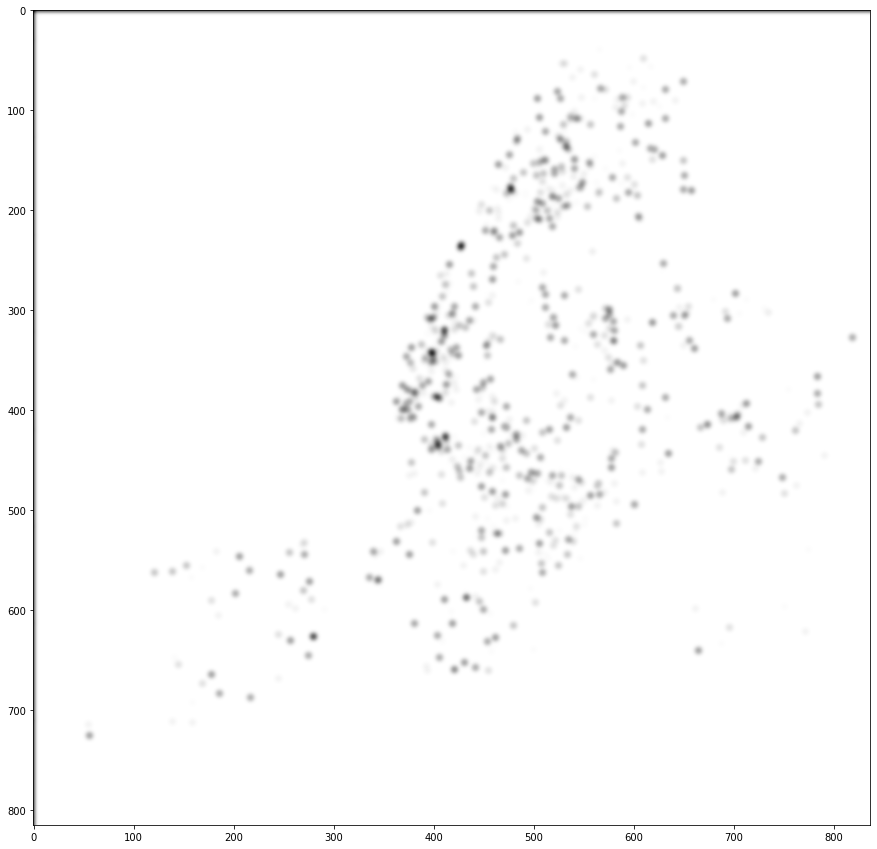

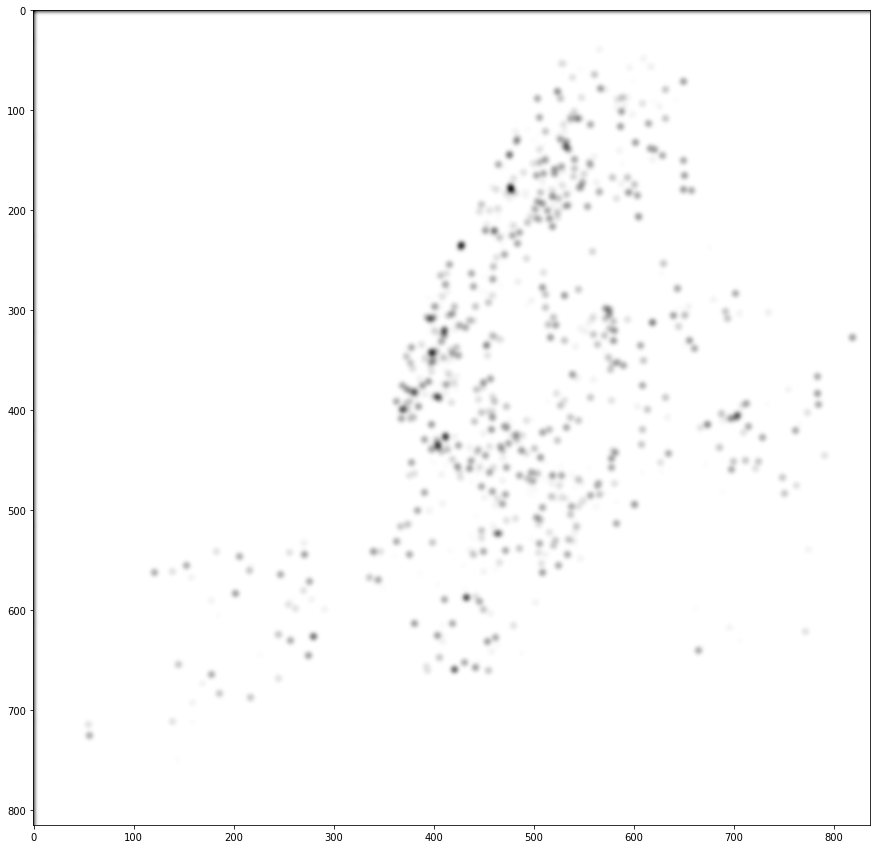

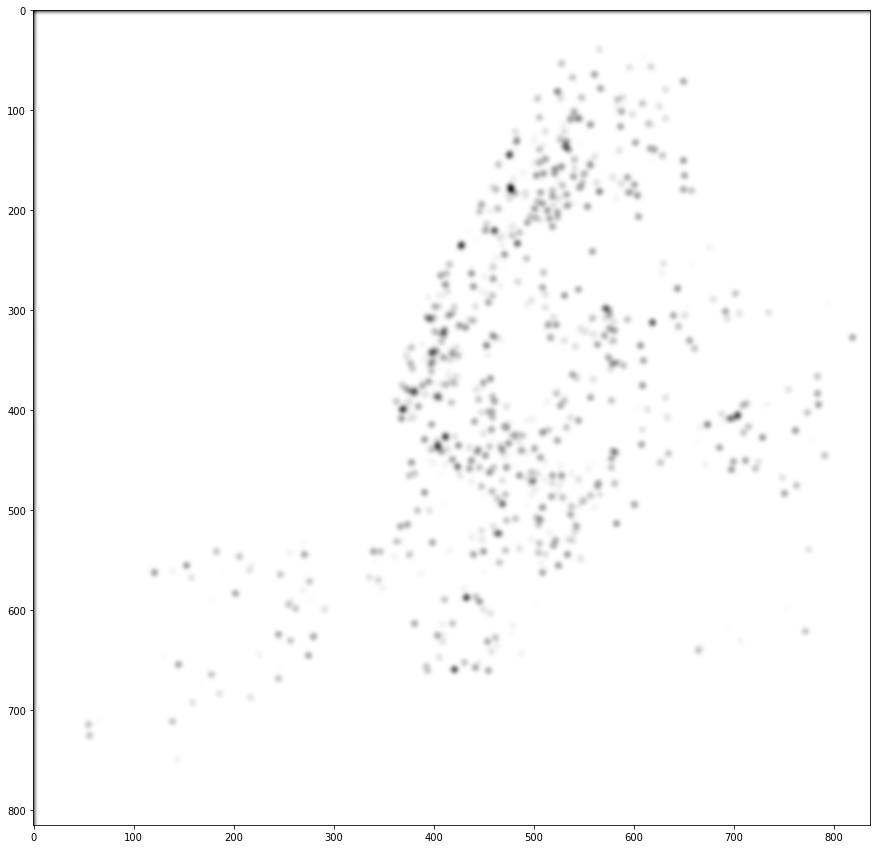

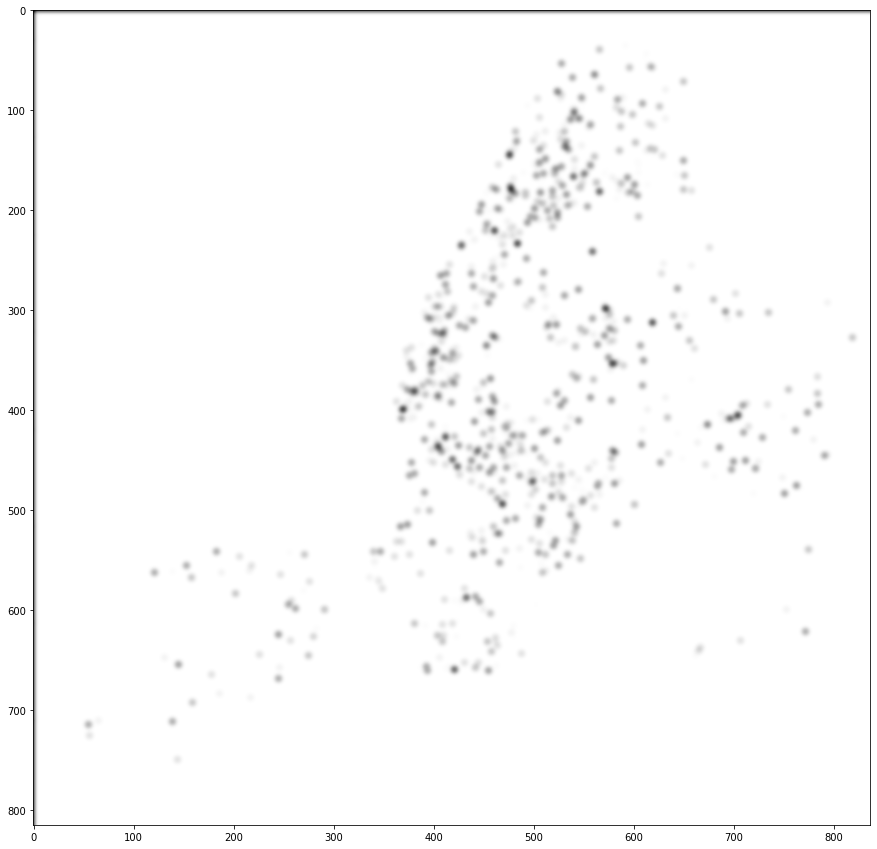

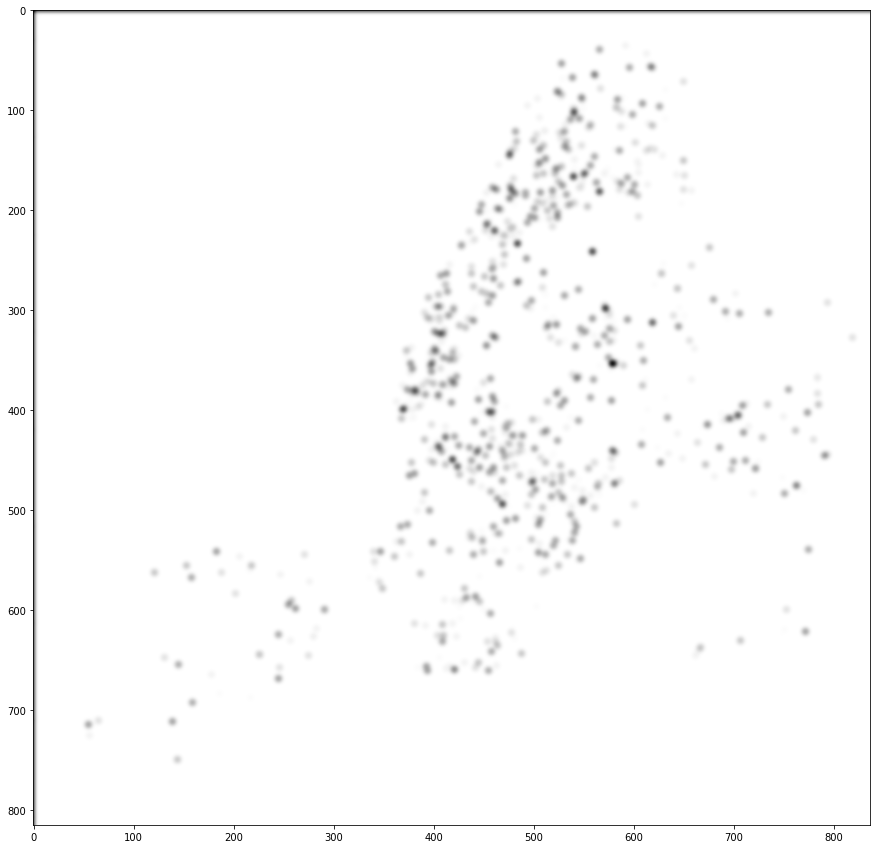

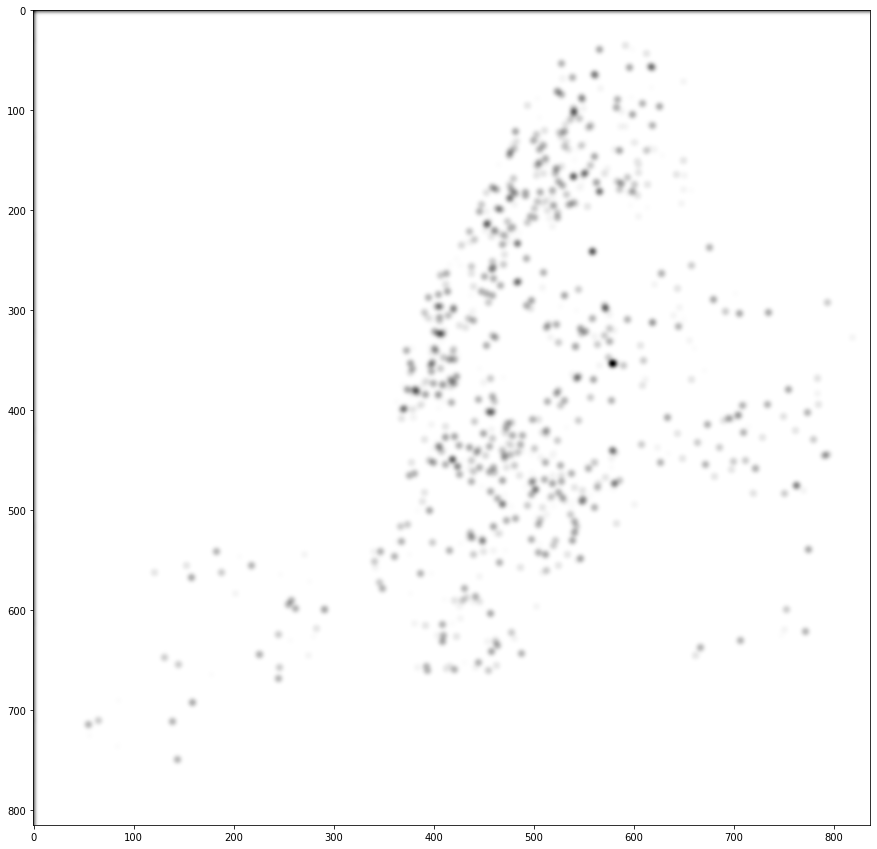

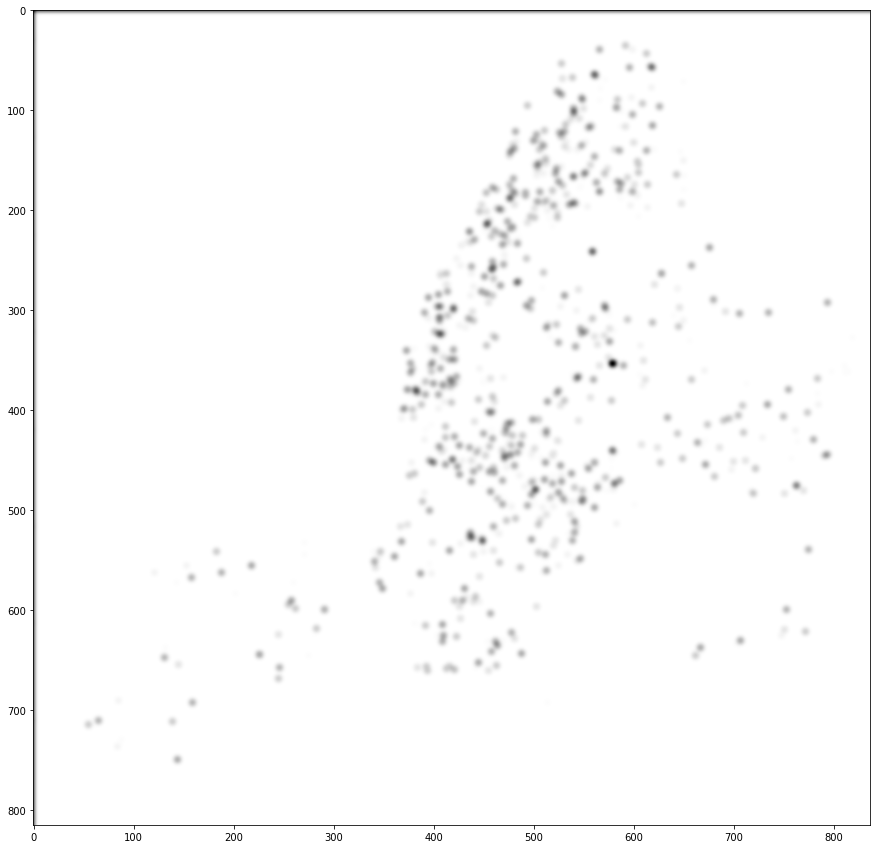

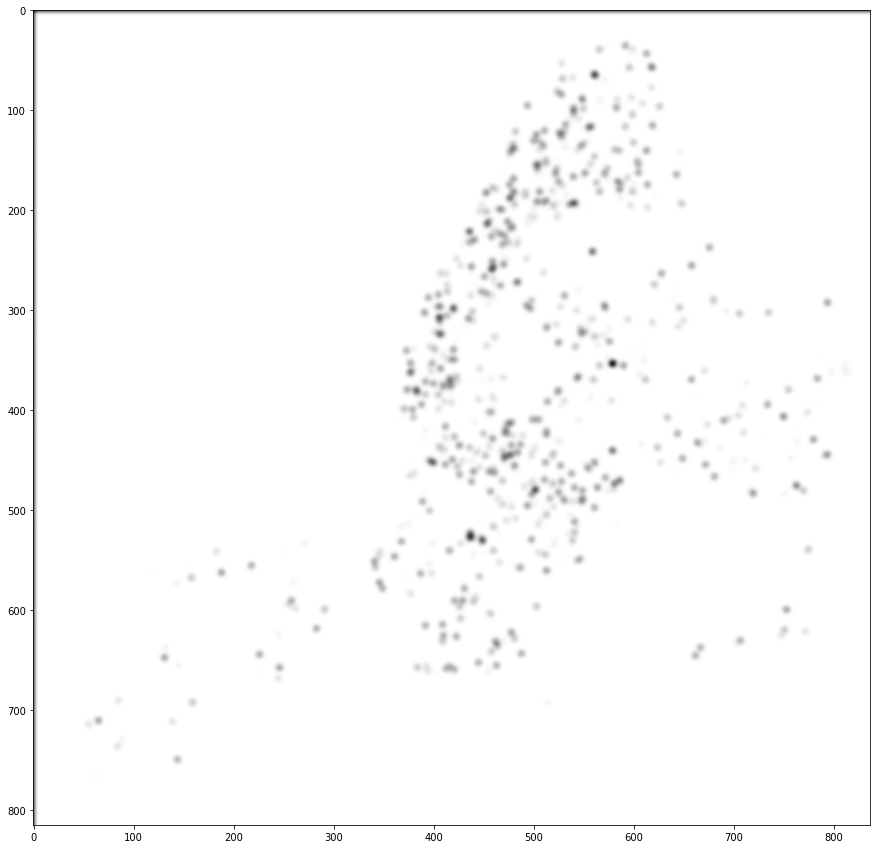

In [14]:
max_lum = img3D_conv.max()
for i in range(19):
    plt.imshow(img3D_conv[i+1,:,:], cmap='gray')
    plt.show()

# Get X and y

In [15]:
def get_observation_target(img3D_conv):
    position = np.random.randint(0,img3D_conv.shape[0]-27)
    observation = img3D_conv[position:position+24]
    target = img3D_conv[position+24:position+27]
    return observation, target

In [16]:
def get_X_y(img3D_conv, number_of_observations):
    X = []
    y = []
    for n in range(number_of_observations):
        X_subsample, y_subsample = get_observation_target(img3D_conv)
        X.append(X_subsample)
        y.append(y_subsample)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [17]:
X, y = get_X_y(img3D_conv, 50 )

In [18]:
X.shape

(50, 24, 815, 837)

In [19]:
y.shape

(50, 3, 815, 837)

# Other